# Network embedding

In this notebook we aim to derive a node embedding for the regulatory network of U2OS cells that we derived in our preceeding analyses. To this end, we will train a Graph-convolutional AutoEncoder. To assess the stability of the embeddings we will experiment with different input features, training objectives and initializations and compare the clustering of the inferred latent spaces i.a. to embeddings obtained from a DeepWalk model. On the basis of those analyses we will finally identify a stable node embedding for the genes in the input regulatory network. Those embeddings will span our estimate of the regulatory state in U2OS cells.

---

## 0. Environmental setup

First, we will load all required libraries.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from node2vec import Node2Vec
from torch_geometric.nn import GAE
from torch_geometric.utils import train_test_split_edges, from_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import InnerProductDecoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scanpy as sc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr, pearsonr
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer

from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

sys.path.append("../../../")

from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *
from src.utils.basic.io import get_genesets_from_gmt_file
from src.models.ae import CustomGAE, GCNEncoder

seed = 1234

plt.style.use("default")

%load_ext nb_black

<IPython.core.display.Javascript object>

In [29]:
def label_point(x, y, val, ax):
    for i in range(len(x)):
        ax.text(x[i] + 0.02, y[i], val[i], {"size": 10})

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we will read in the regulatory graph data along side with a scRNA-seq data set and a number of hallmark geneset information. The latter two will be used to define further node features and update the correlation information for the interactions in the graph.

In [2]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/conf_hub_spearman_sol.pkl"
)
print(nx.info(spearman_interactome))

Name: conf_hub_spearman_sol
Type: Graph
Number of nodes: 163
Number of edges: 328
Average degree:   4.0245


<IPython.core.display.Javascript object>

In [3]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

In addition to the 50 Hallmark gene sets, we also load the gene sets corresponding to pathways involved in mechanotransduction: cell cycle control, regulation of chromatin organization and actin cytoskeleton, DNA damage repair, cell death and transcription factors.

In [4]:
cc_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_cycle.txt", index_col=0).index
)
co_genes = set(
    pd.read_csv("../../../data/other/reactome_chrom_org.txt", index_col=0).index
)
dr_genes = set(
    pd.read_csv("../../../data/other/reactome_dna_repair.txt", index_col=0).index
)
cd_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_death.txt", index_col=0).index
)
cr_genes = set(
    pd.read_csv("../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0).index
)
tfs = set(pd.read_csv("../../../data/other/human_tf_list.txt", index_col=0).index)

spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results.csv", index_col=0
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../data/other/h.all.v7.4.symbols.gmt"
)

<IPython.core.display.Javascript object>

---
---

## 2. Preprocessing

We will now set the respective node and edge attributes computed based on the previously loaded information. Note, that the single-cell gene expression data is min-max-scaled.

### 2.1. Attribute setting

In [5]:
gex_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(gex_data),
    index=gex_data.index,
    columns=gex_data.columns,
)

<IPython.core.display.Javascript object>

In [6]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["name"] = node[0]
    node[-1]["cell_cycle"] = node[0] in cc_genes
    node[-1]["chromatin_org"] = node[0] in co_genes
    node[-1]["dna_repair"] = node[0] in dr_genes
    node[-1]["cytoskeleton_org"] = node[0] in cr_genes
    node[-1]["cell_death"] = node[0] in cd_genes
    node[-1]["tf"] = node[0] in tfs
    node[-1]["spec_target"] = node[0] in spec_orf_targets

    gene_memberships = []
    for geneset in hallmark_geneset_dict.values():
        if node[0] in geneset:
            gene_memberships.append(1.0)
        else:
            gene_memberships.append(0.0)

    node[-1]["hallmark"] = np.array(gene_memberships)
    node[-1]["sc_gex_hallmark"] = np.concatenate(
        [node[-1]["sc_gex"], node[-1]["hallmark"]]
    )

for edge in spearman_interactome.edges(data=True):
    edge[-1]["spearmanr"] = spearmanr(
        gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]]
    )[0]
    edge[-1]["pearsonr"] = pearsonr(gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]])[
        0
    ]

<IPython.core.display.Javascript object>

---

### 2.2 Data preparation

Next, we transform the graph into a data object complient with the used pytorch_geometric framework to learn the graph embeddings.

In [16]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

graph_data = from_networkx(spearman_interactome)
graph_data.id = torch.FloatTensor(np.identity(len(spearman_interactome)))
graph_data = T.ToDevice(
    device,
    attrs=[
        "id",
        "sc_gex",
        "pbulk_gex",
        "hallmark",
        "sc_gex_hallmark",
        "pbulk_gex_hallmark",
    ],
)(graph_data)

<IPython.core.display.Javascript object>

---
---

## 3. Node embeddings


After having finally prepared the data, we can now start inferring node embeddings from the data. For each model type, we will vary the initialization 5 times using different random seeds. In a first step, we will assess the similarity between the inferred latent spaces by pairwise comparing the hierarchical co-clustering of the inferred spaces pairwise using the adjusted mutual information.
In the second step, we will assess the individual inferred latent spaces for a fixed random initialization and compare the similarity of the inferred embeddings between the different model setups in a similar fashion.

---

### 3.1. Assessing the stability of the inferred latent spaces

#### 3.1.1. Node2Vec

We will first start with a simple baseline model that is purely based on the network topology and embedds the nodes via encoding neighborhood simularity using random walks on the graph. The model requires a number of hyperparameters, which we initially keep constant for the stability assessment.

In [8]:
seeds = [1234, 2345, 3456, 4567, 5678]
latent_dims = [32, 64, 128]

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [01:53<00:00,  1.13s/it]

Final loss: 0.9565745039684016


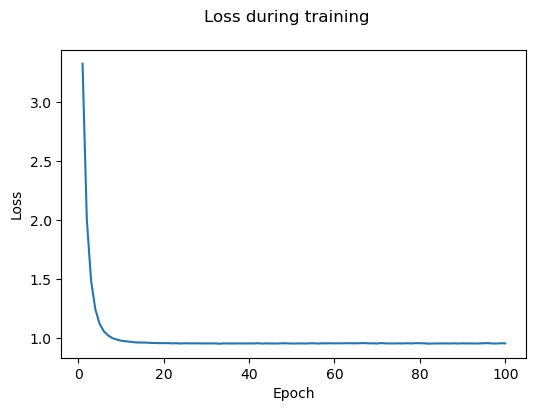

100%|██████████| 100/100 [01:51<00:00,  1.11s/it]

Final loss: 0.9552900325961229


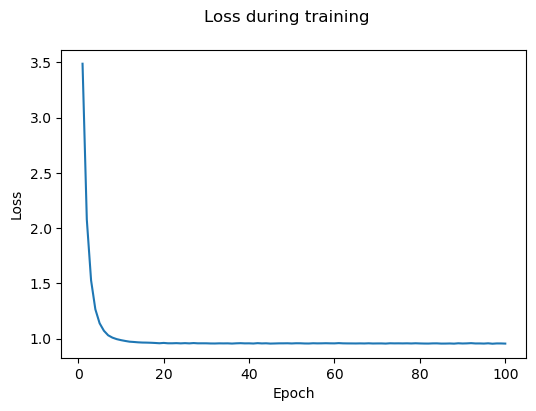

100%|██████████| 100/100 [01:48<00:00,  1.08s/it]

Final loss: 0.9554190286775914


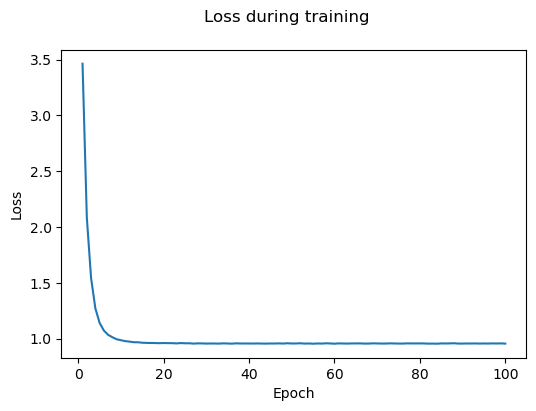

100%|██████████| 100/100 [01:53<00:00,  1.14s/it]

Final loss: 0.9565193754870717


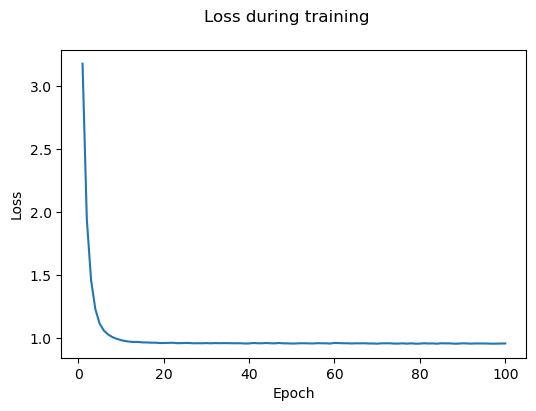

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]

Final loss: 0.9543255087805957


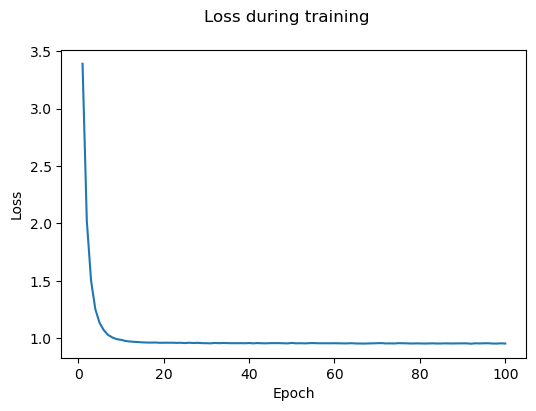

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


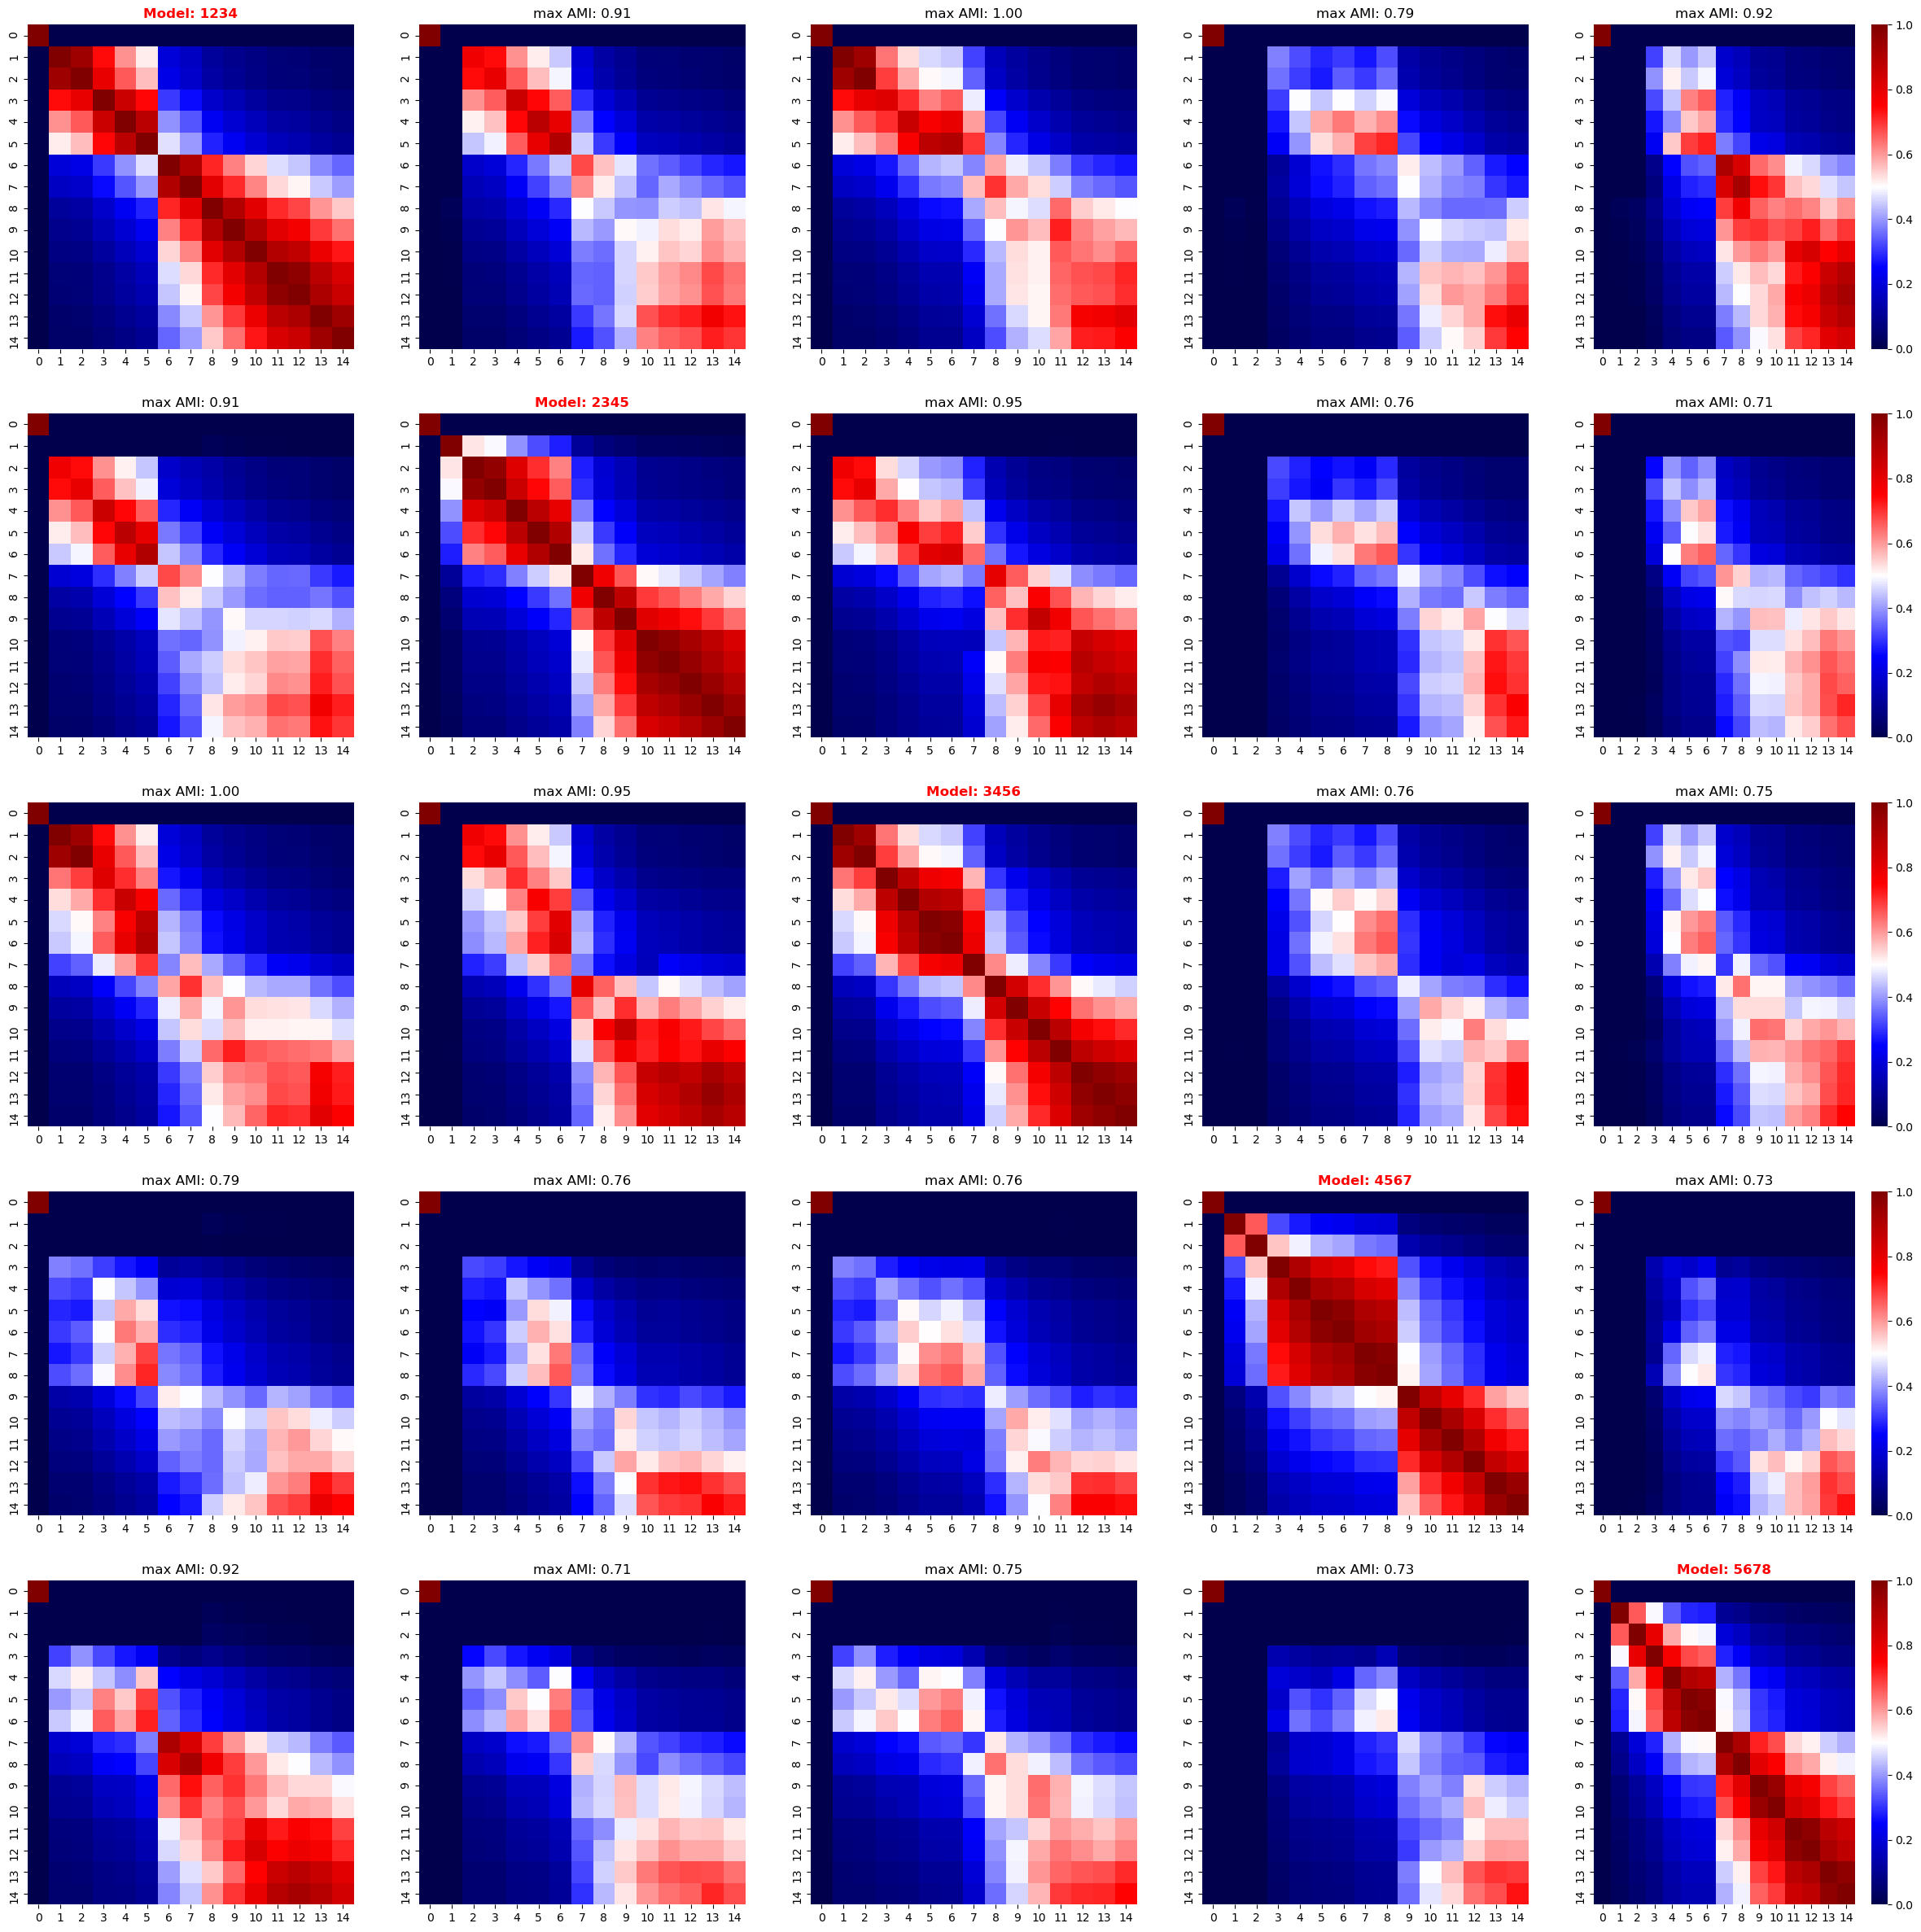

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

Final loss: 0.9601940294591392


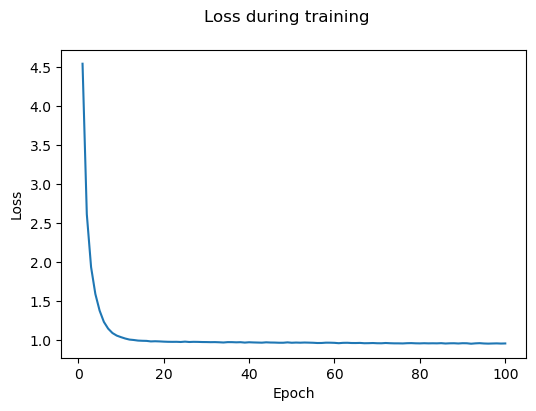

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]

Final loss: 0.9572951531991726


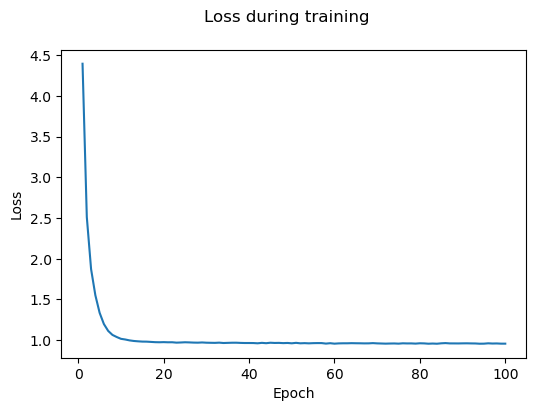

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]

Final loss: 0.9671956271660037


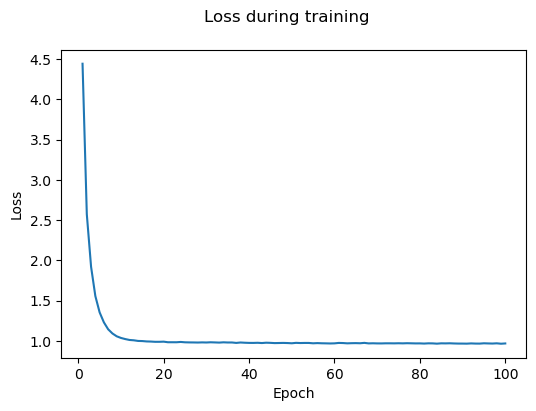

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]

Final loss: 0.9586110580258254


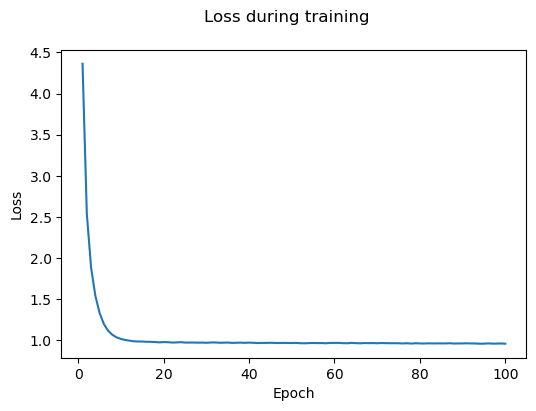

100%|██████████| 100/100 [01:24<00:00,  1.18it/s]

Final loss: 0.9467777842428626


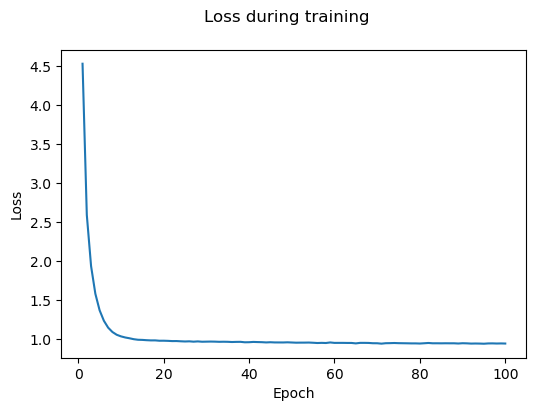

100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


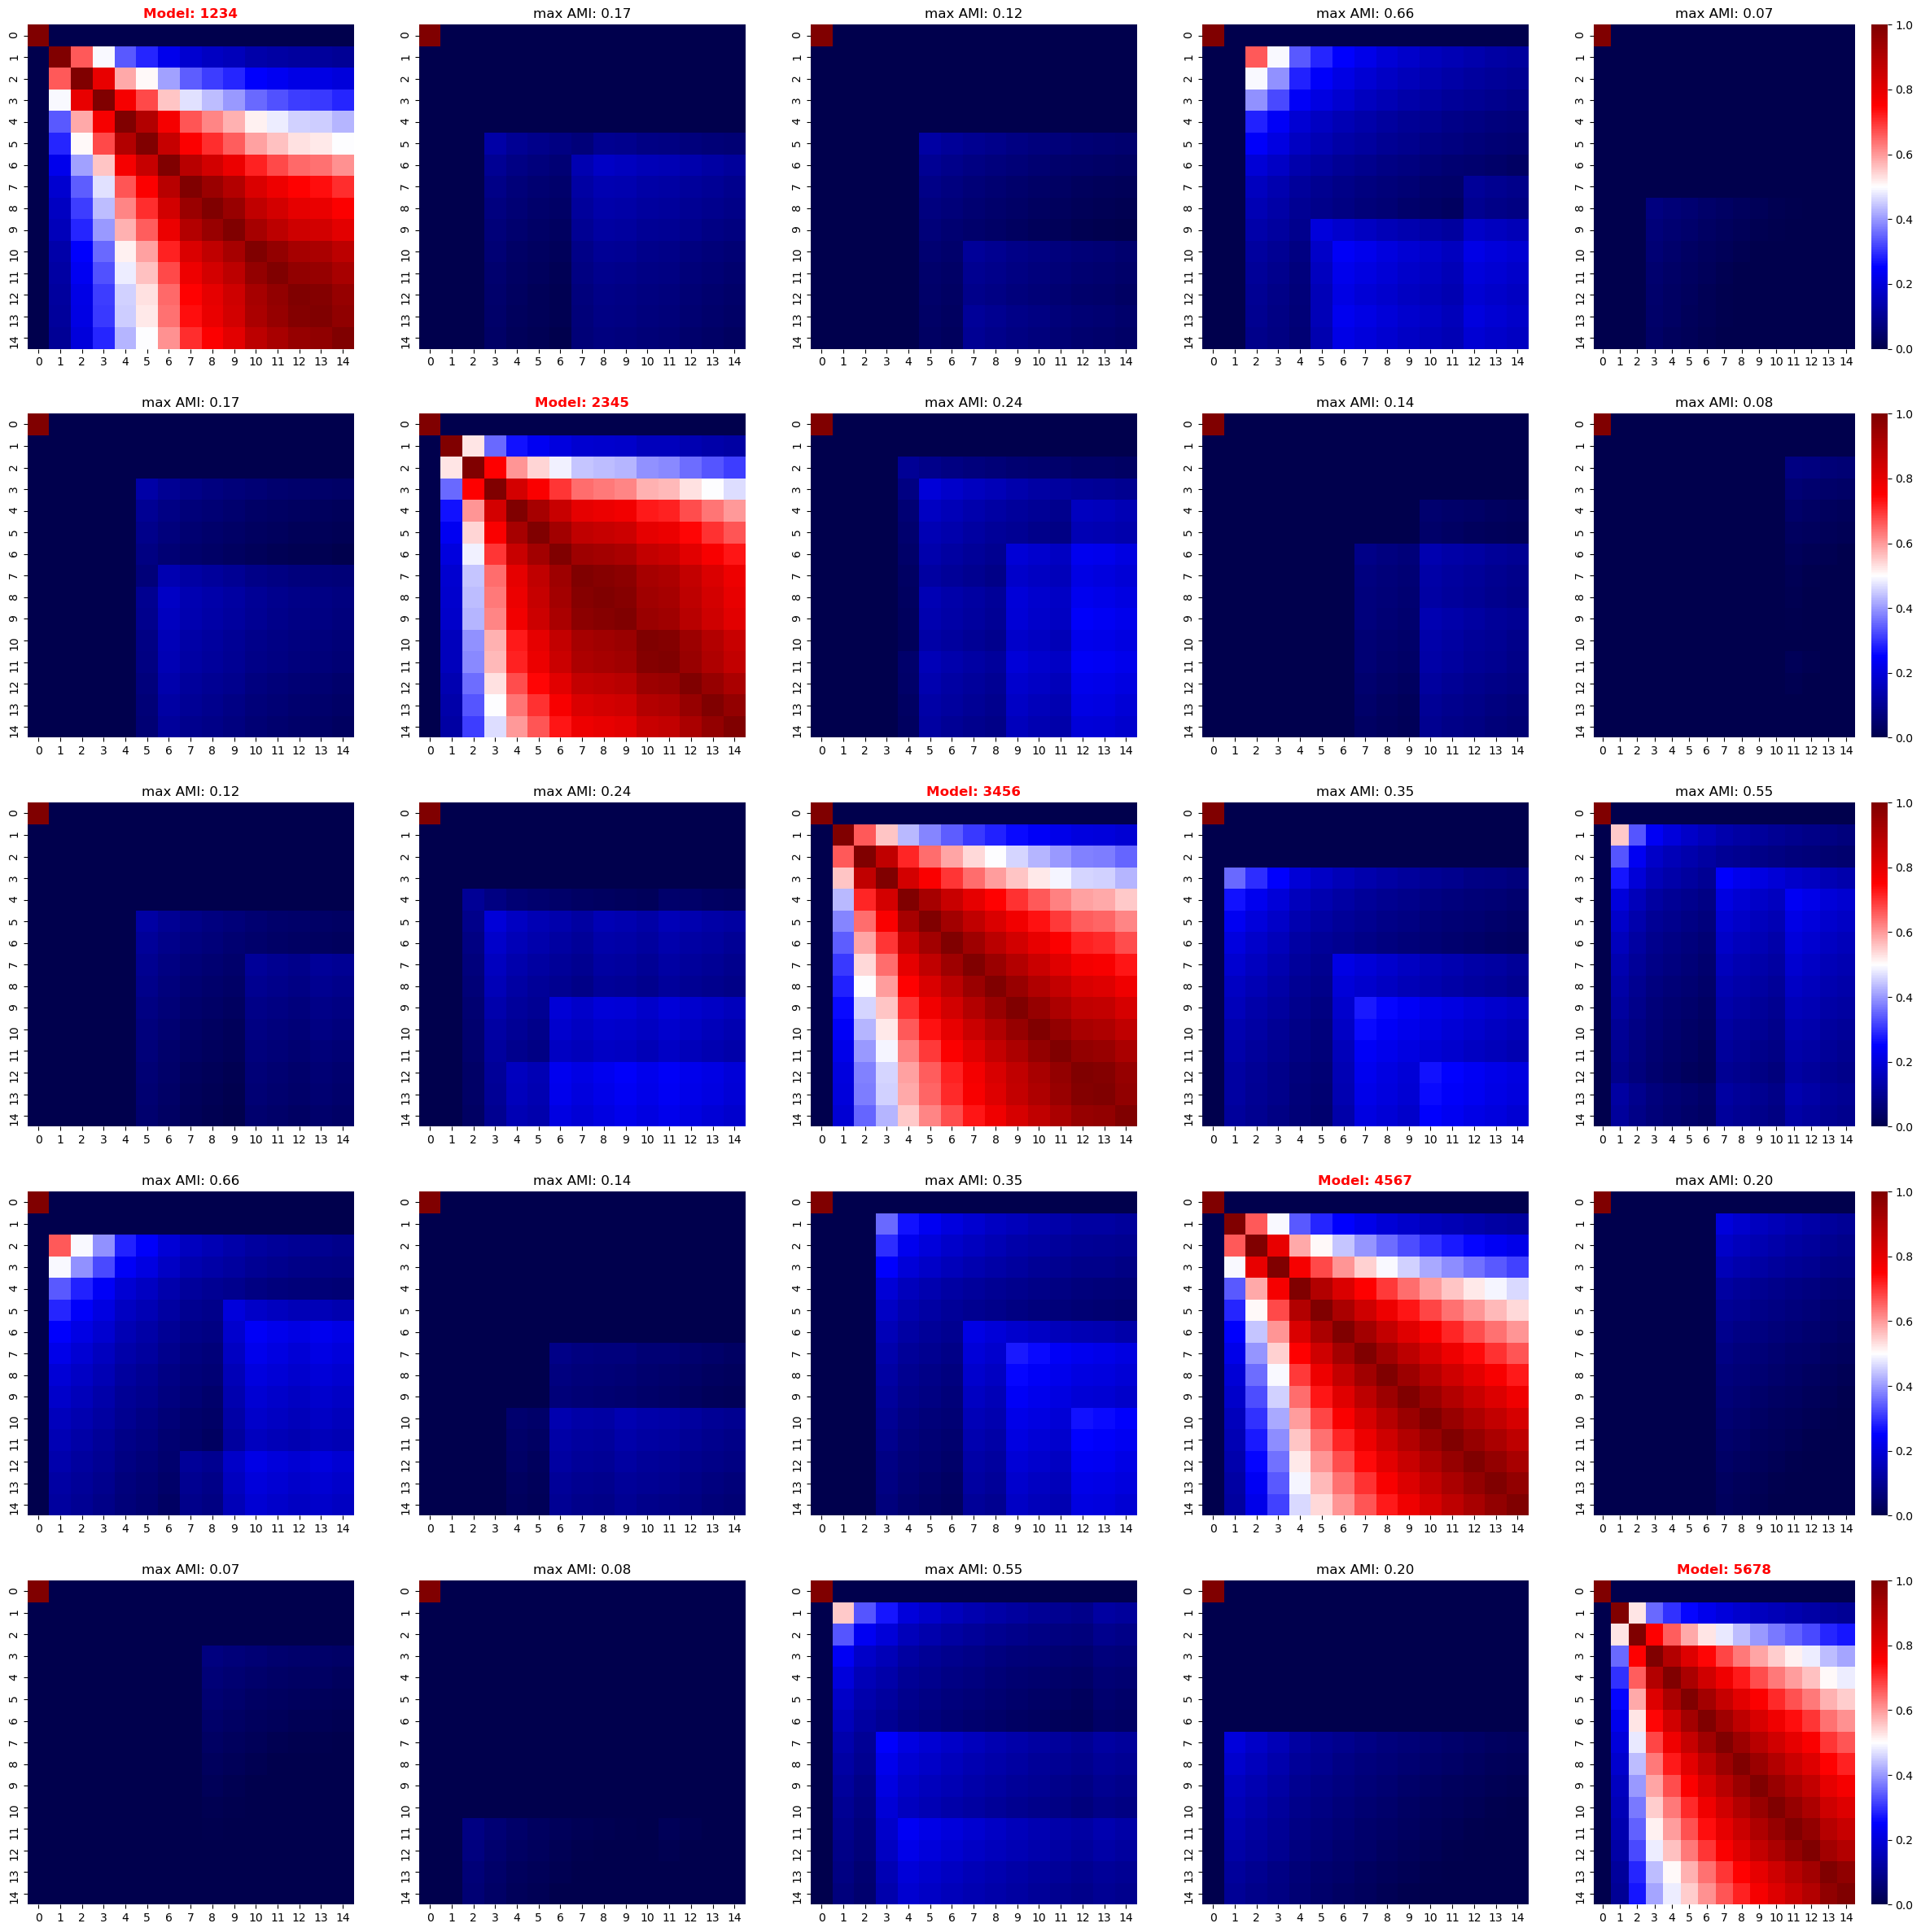

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]

Final loss: 1.74010949890788


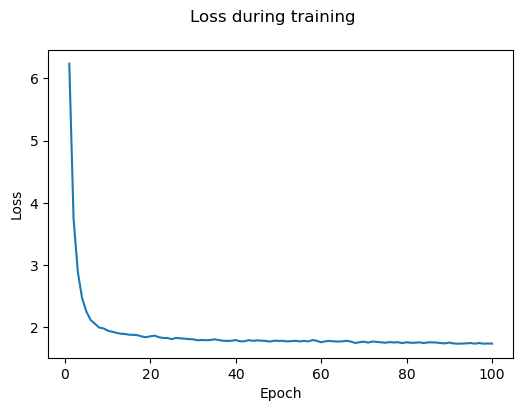

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]

Final loss: 1.6966628679415074


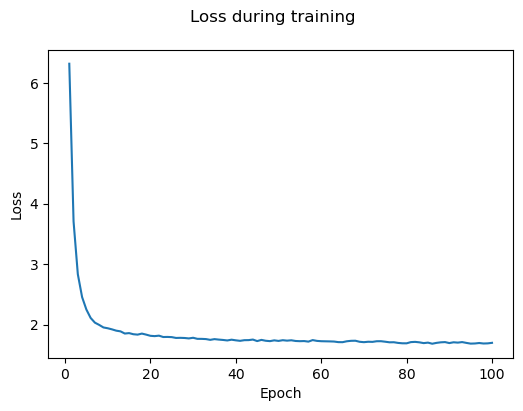

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

Final loss: 1.7137171146346302


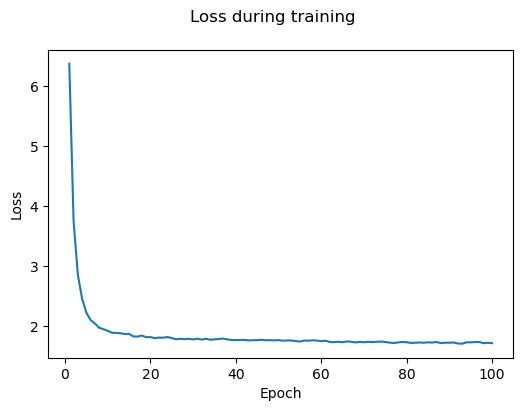

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]

Final loss: 1.6677530218915242


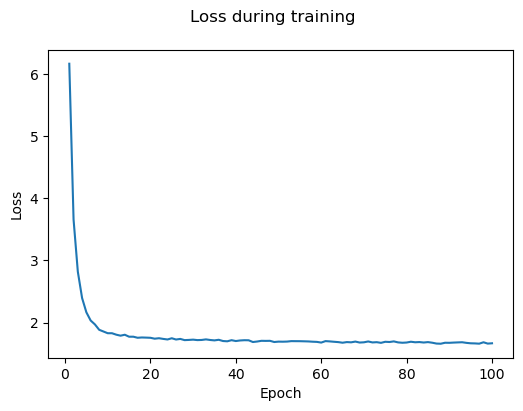

100%|██████████| 100/100 [01:29<00:00,  1.11it/s]

Final loss: 1.6658639995063222


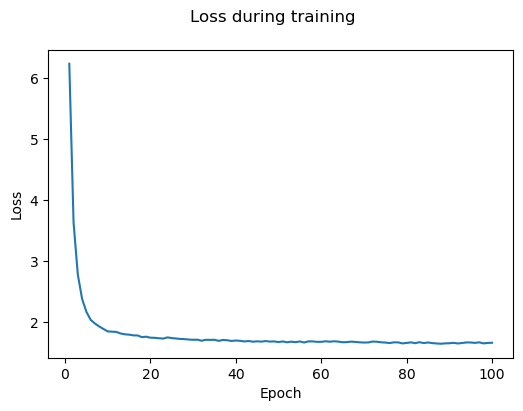

100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


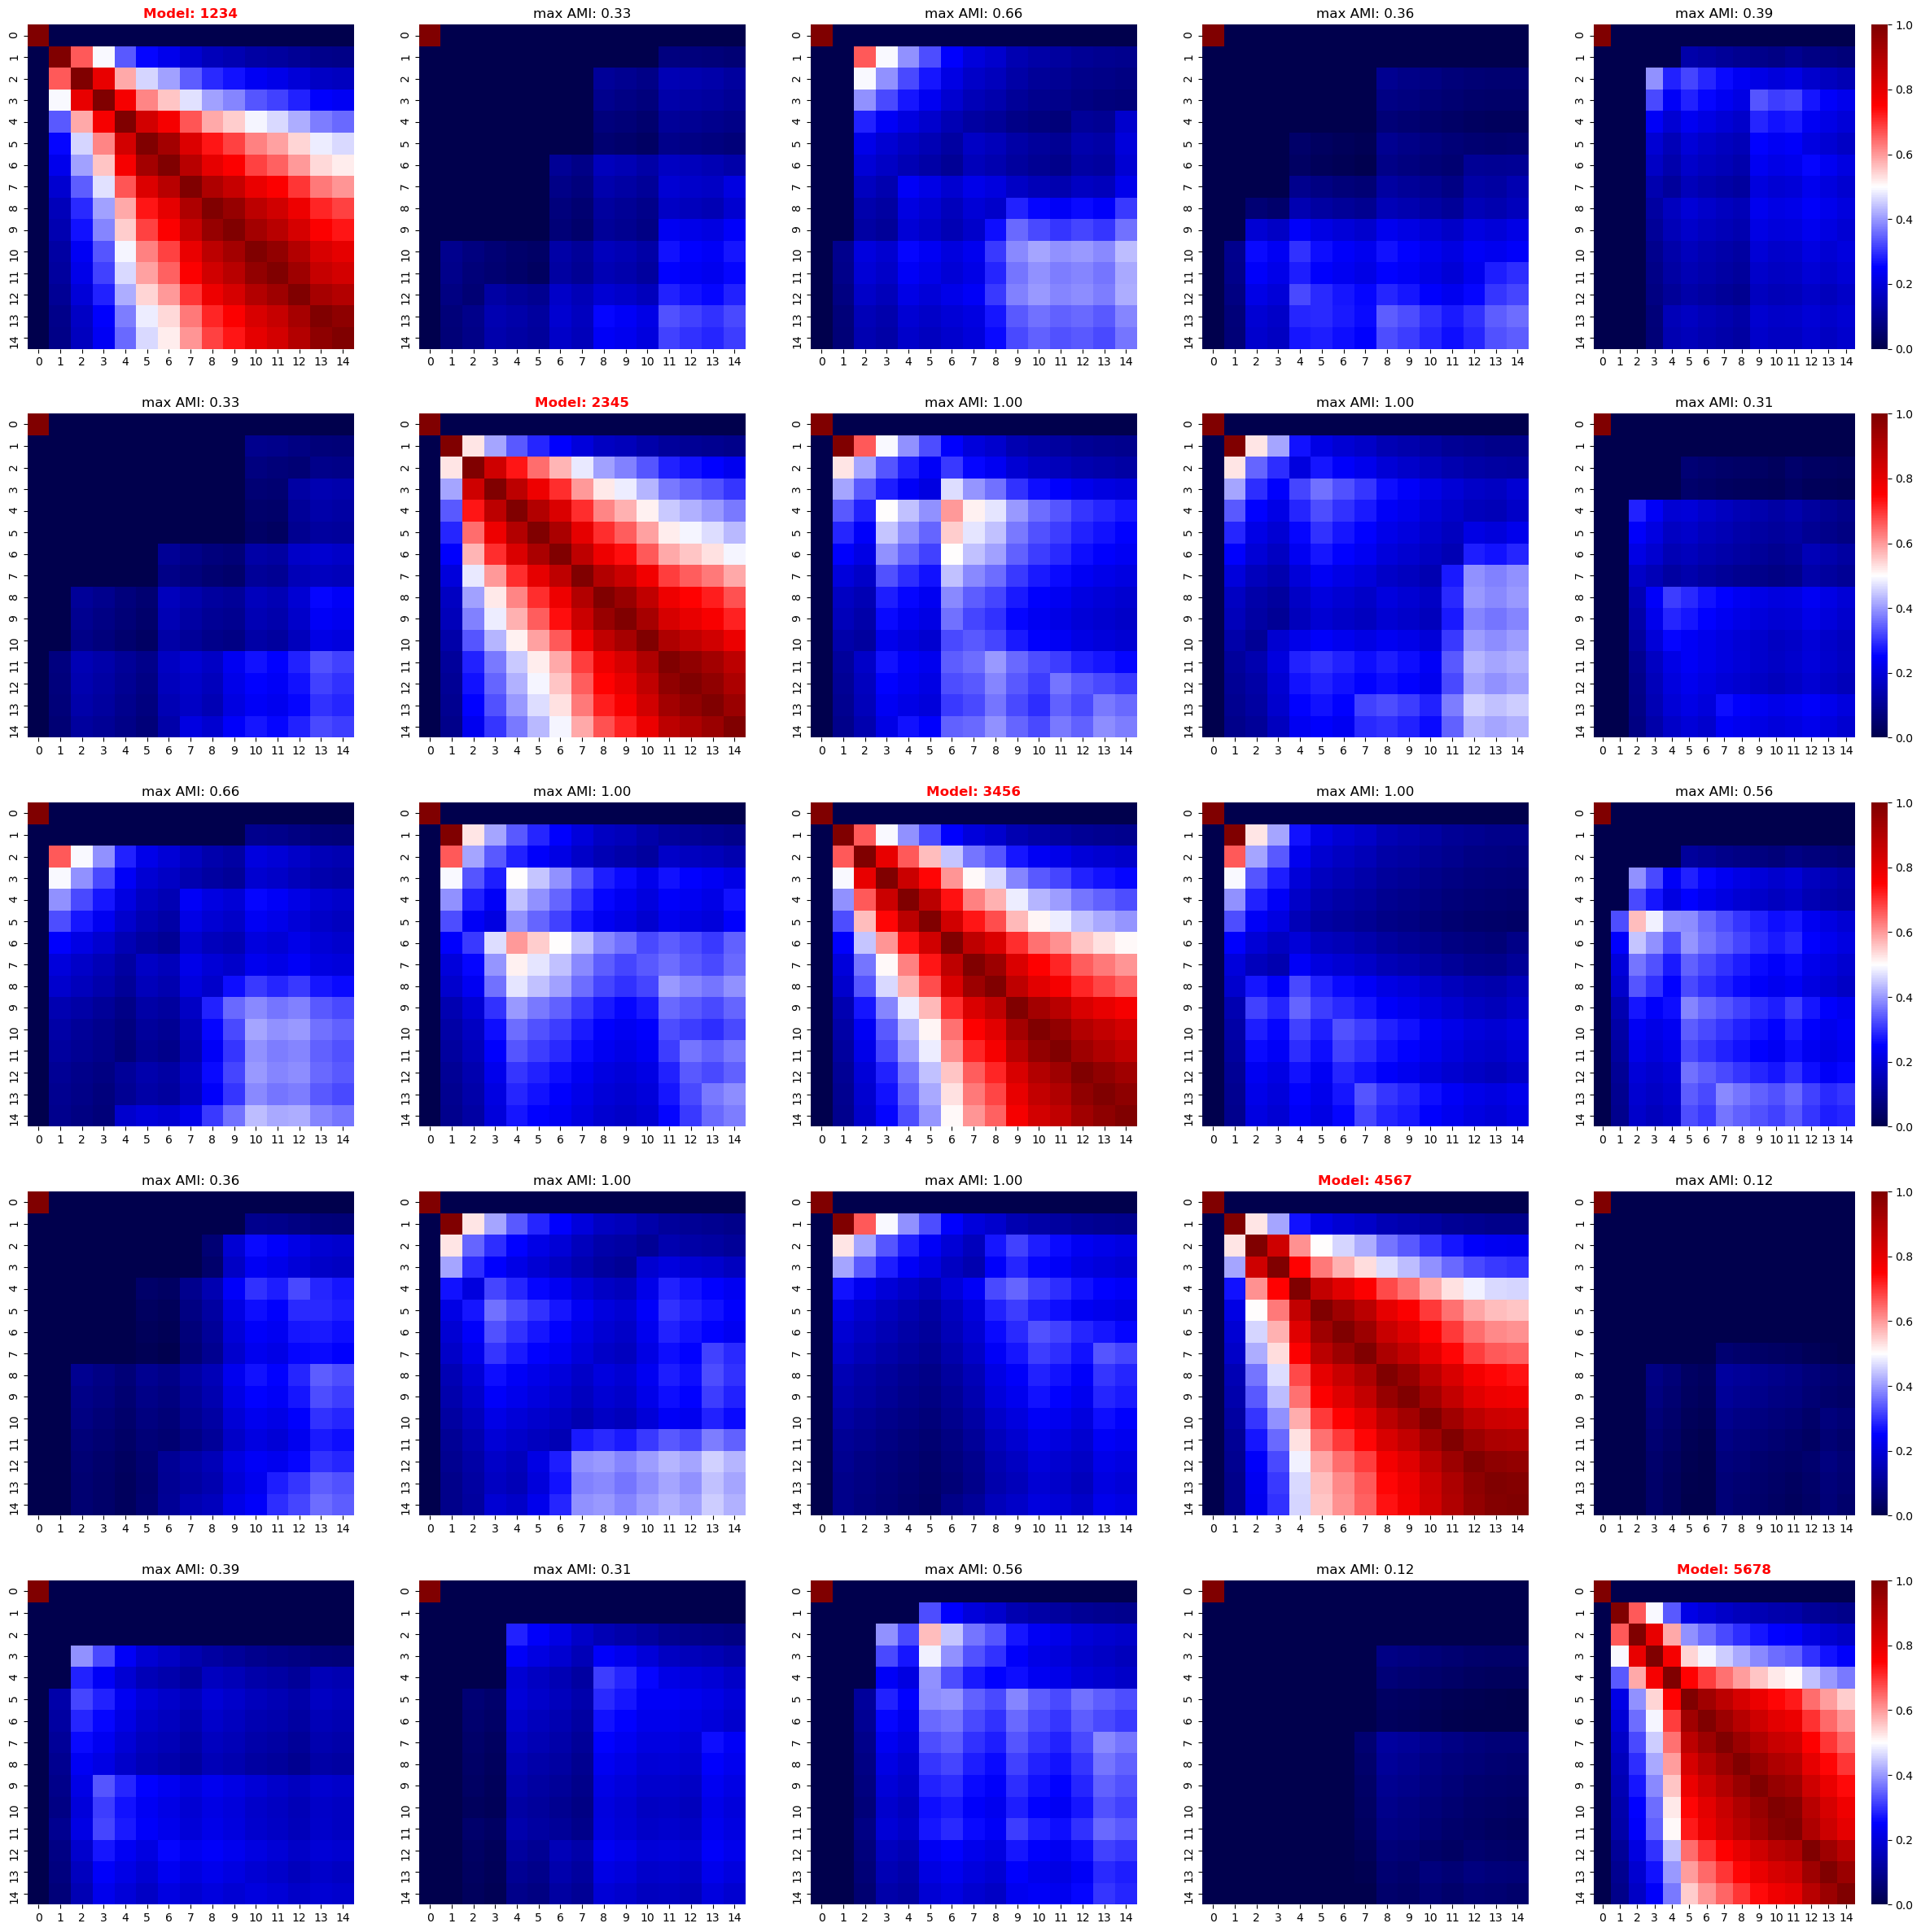

<IPython.core.display.Javascript object>

In [9]:
for latent_dim in latent_dims:
    latents_dict_n2v = get_n2v_latents_for_seed(
        graph_data,
        seeds,
        latent_dim=latent_dim,
        walk_length=50,
        context_size=5,
        walks_per_node=20,
        batch_size=4,
        num_workers=4,
        lr=0.01,
        n_epochs=100,
        plot_loss=True,
    )
    stability_amis_n2v = stability_cocluster_screen(
        latents_dict_n2v, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_n2v)

---

#### 3.1.2. GAE

After having assess the stability of the Node2Vec embeddings we will now run a similar analyses using a GAE model. Hereby, we will first vary the type of input features that we provide alongside with the adjacency matrix, before we also assess setups with different training objectives and different model configurations.

##### Topology-GAE

The first model does not uses any meaningful input features but is simply the identity matrix. Thus, the network should mostly focus on the graph structure. We will train the model on the task of reconstructing the adjacency matrix. Note that we do not split the data but simply aim to find a low-dimensional embedding that encodes the adjacency matrix.

 39%|███▉      | 391/1000 [00:18<00:28, 21.46it/s]


------------------------------------------------------------


 40%|███▉      | 398/1000 [00:18<00:27, 22.11it/s]


------------------------------------------------------------


 33%|███▎      | 328/1000 [00:06<00:12, 52.64it/s] 


------------------------------------------------------------


 50%|████▉     | 499/1000 [00:14<00:14, 34.02it/s] 


------------------------------------------------------------


 25%|██▌       | 252/1000 [00:11<00:34, 21.78it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


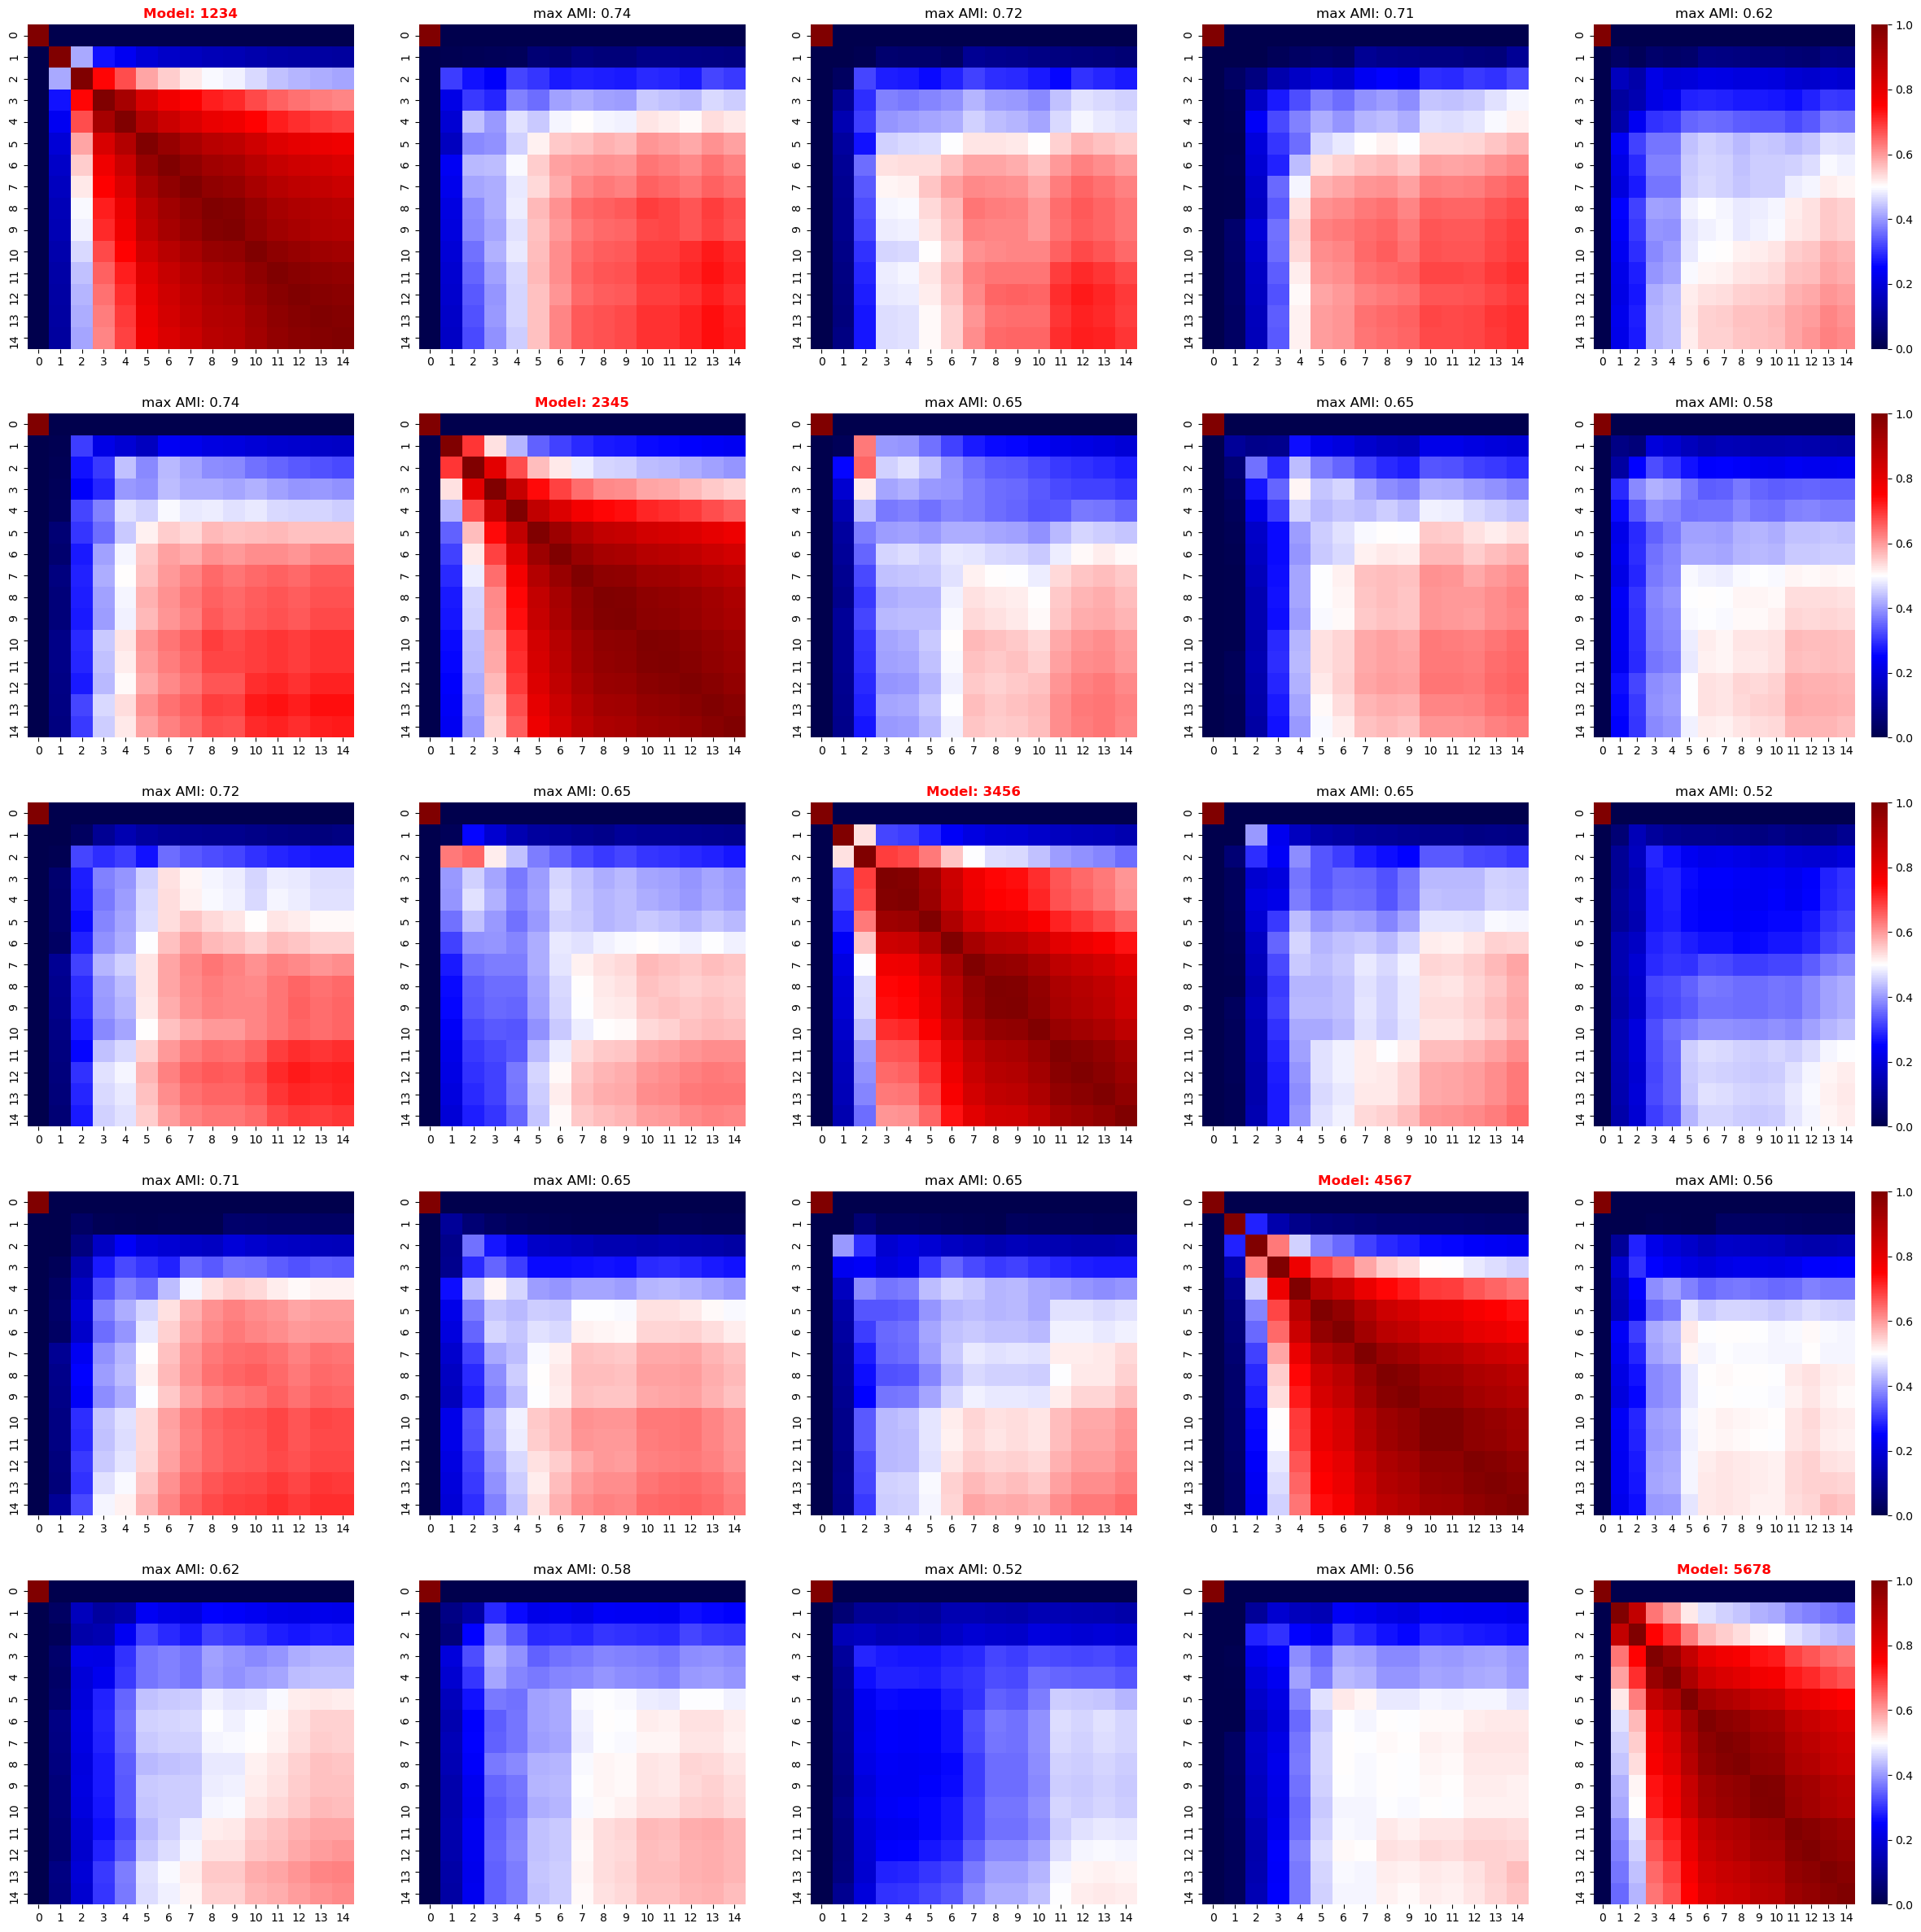

 38%|███▊      | 382/1000 [00:17<00:28, 21.86it/s]


------------------------------------------------------------


 39%|███▉      | 389/1000 [00:17<00:27, 21.82it/s]


------------------------------------------------------------


 37%|███▋      | 367/1000 [00:09<00:16, 39.12it/s] 


------------------------------------------------------------


 30%|██▉       | 298/1000 [00:04<00:11, 59.90it/s] 


------------------------------------------------------------


 23%|██▎       | 231/1000 [00:09<00:29, 25.66it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


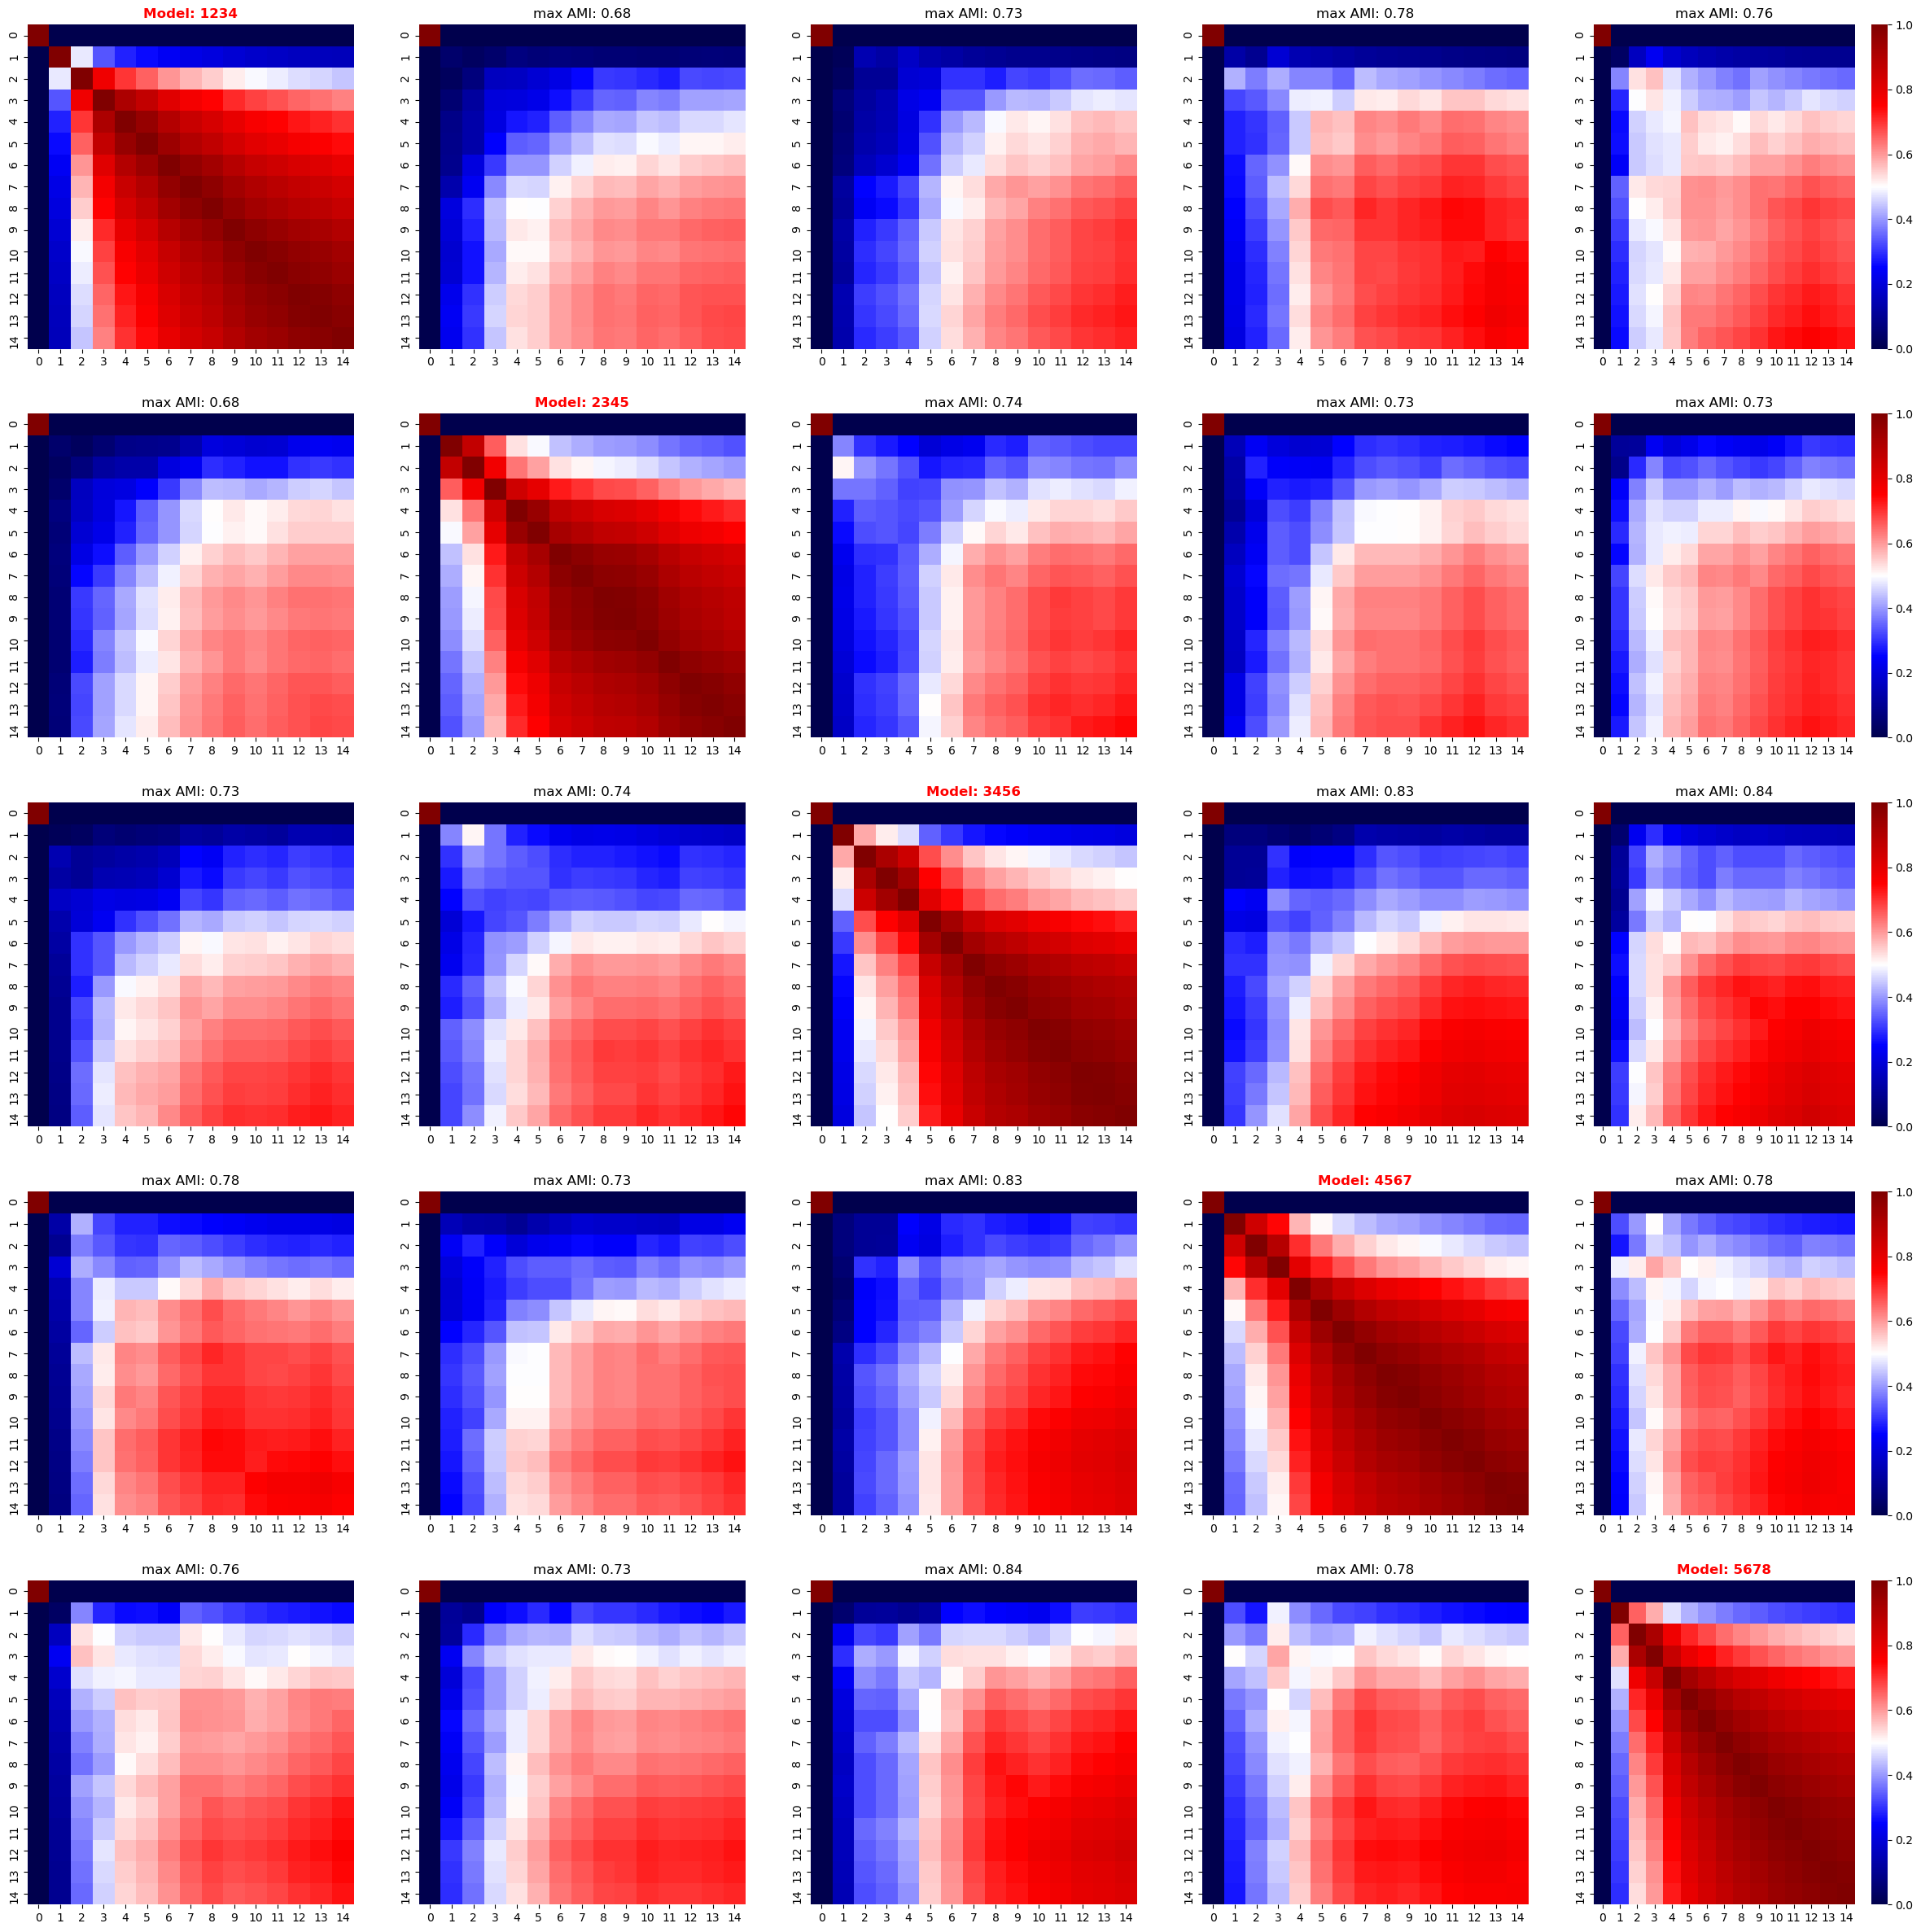

 40%|████      | 400/1000 [00:10<00:15, 38.08it/s] 


------------------------------------------------------------


 36%|███▌      | 355/1000 [00:08<00:15, 41.44it/s] 


------------------------------------------------------------


 34%|███▍      | 340/1000 [00:15<00:30, 21.93it/s]


------------------------------------------------------------


 36%|███▌      | 362/1000 [00:17<00:30, 20.87it/s]


------------------------------------------------------------


 41%|████      | 410/1000 [00:10<00:14, 40.36it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


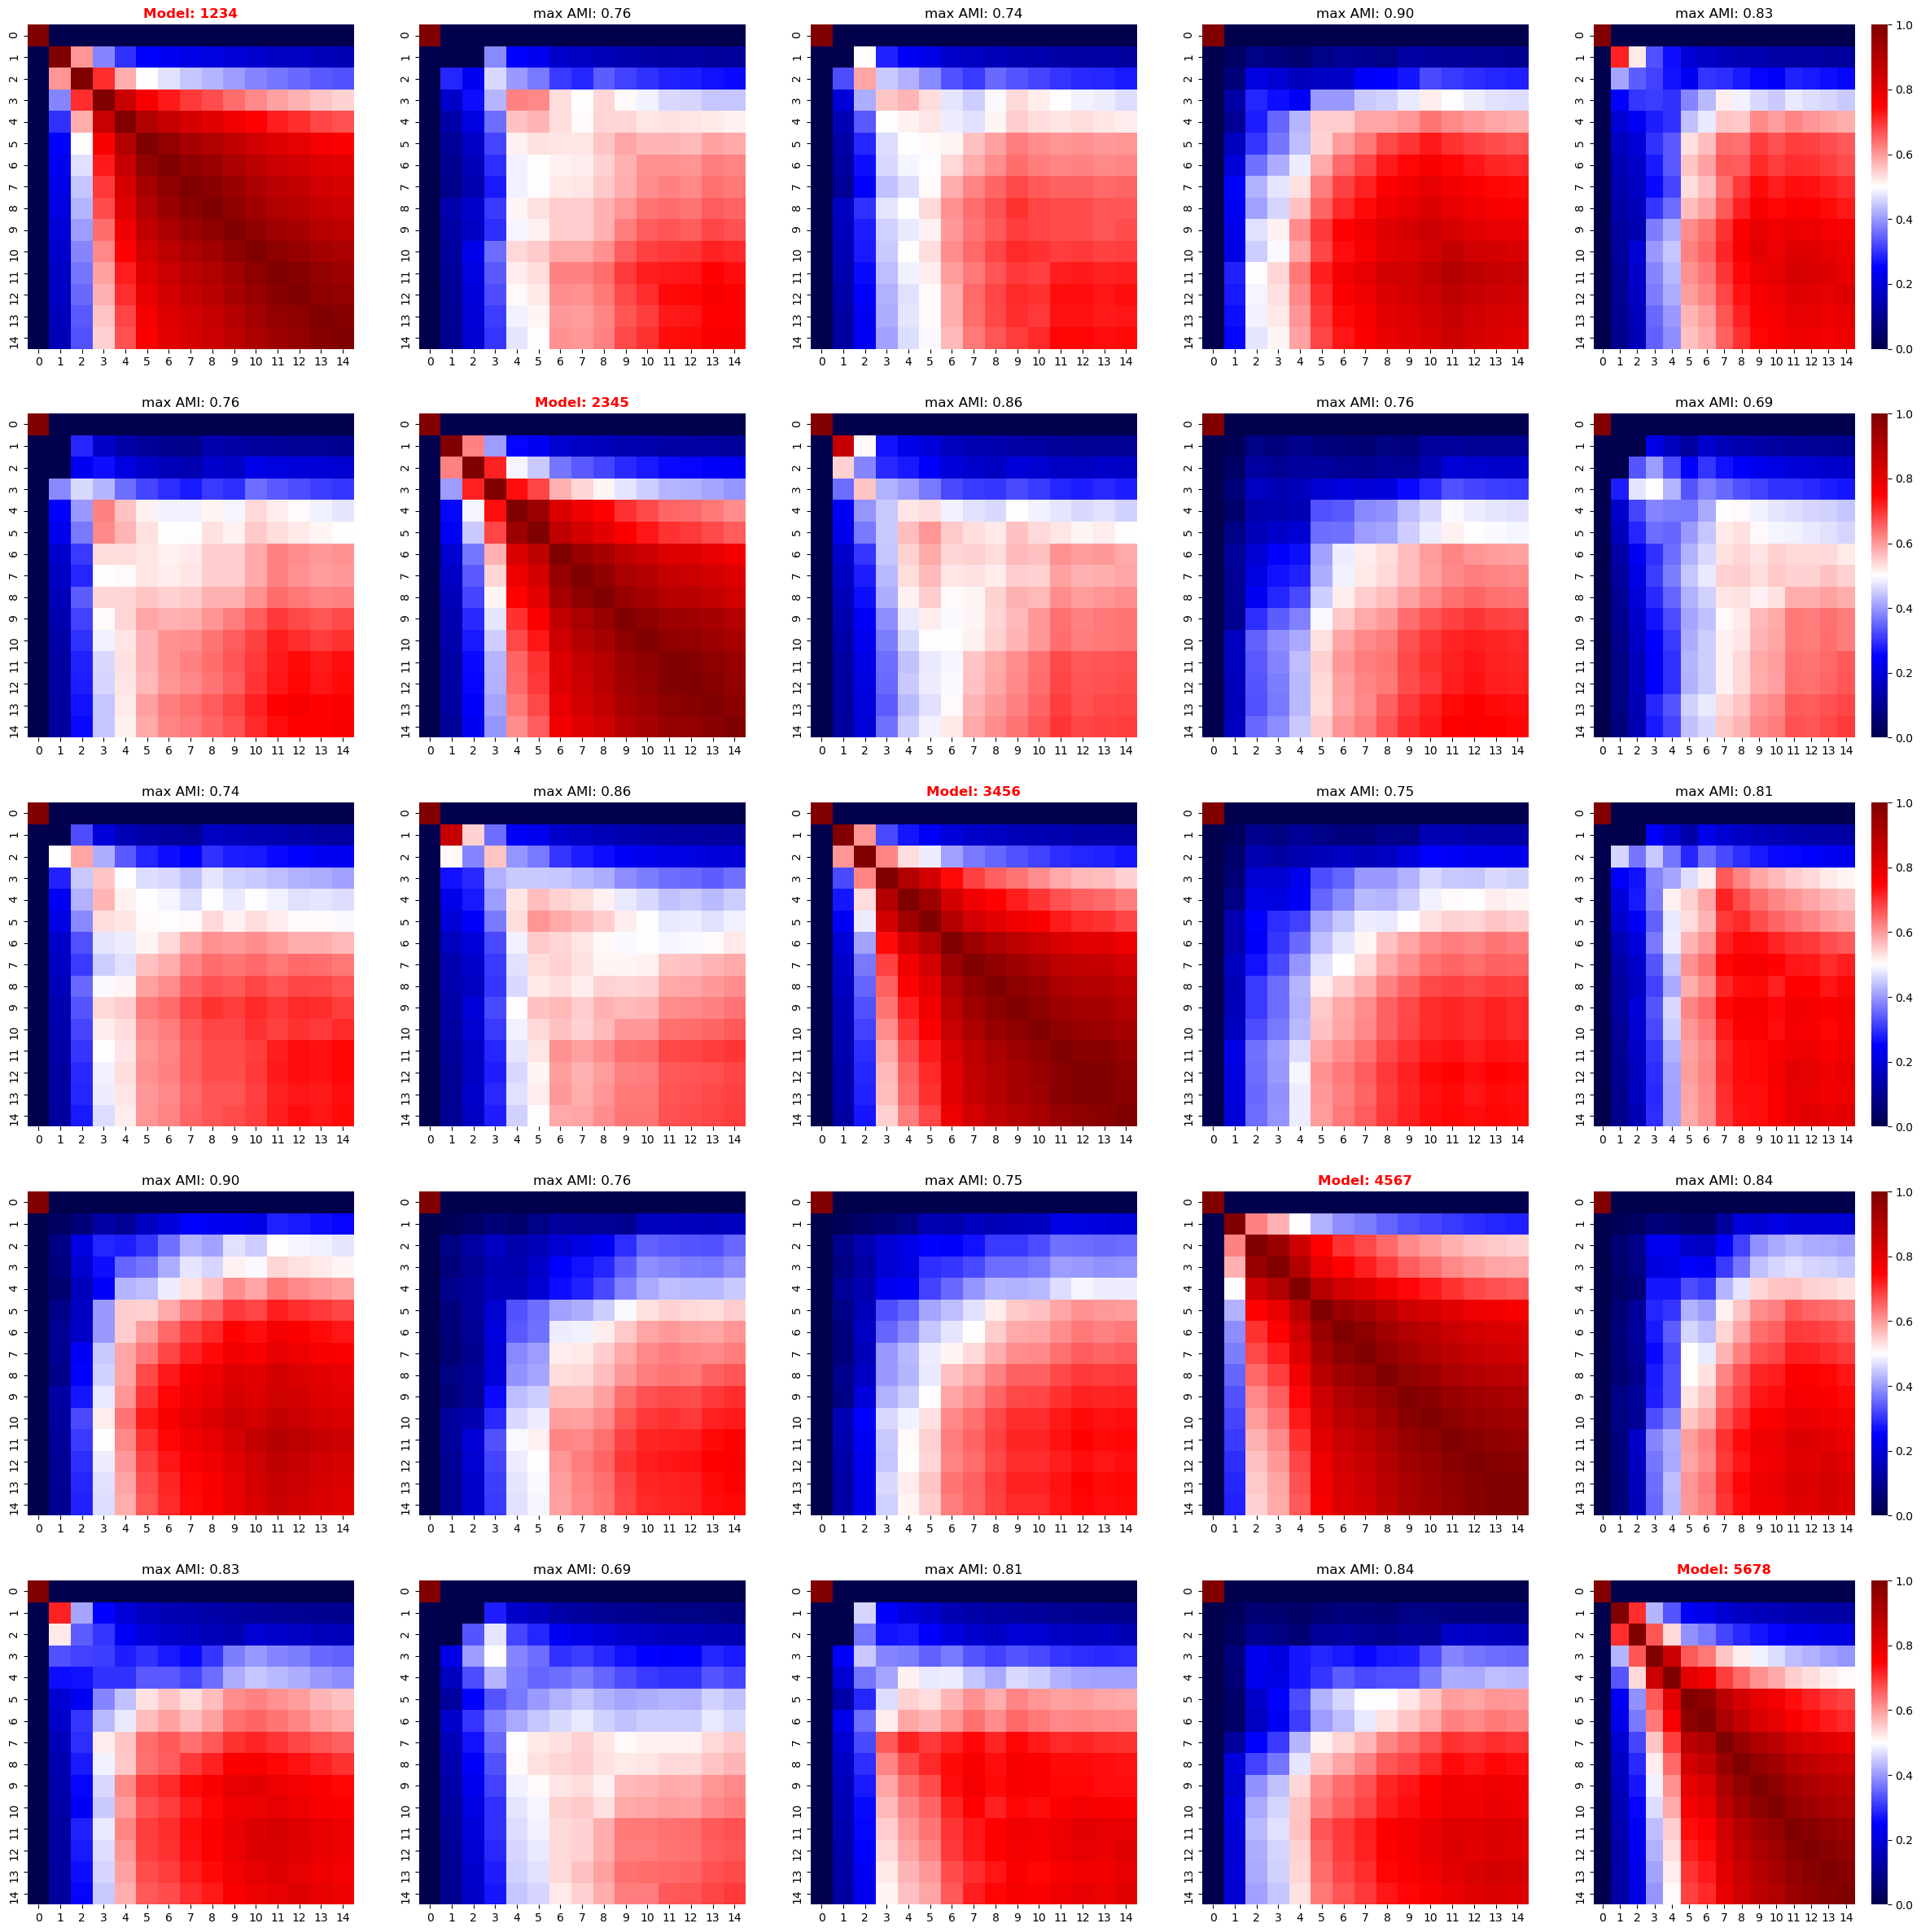

<IPython.core.display.Javascript object>

In [10]:
node_feature_key = "id"

for latent_dim in latent_dims:
    latents_dict_topogae = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=163,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        plot_loss=False,
    )
    stability_amis_topogae = stability_cocluster_screen(
        latents_dict_topogae, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_topogae)

We see that for the GAE trained on solely minimizing the loss of the reconstruction of the adjacency matrix shows a significant dependence of the random initialization. Interestingly, we obtain more stable embeddings for 64 latent dimensions than we obtain for 128 or 32.

---

##### Hallmark GAE

The next model is trained on a similar task but uses geneset memberships as node features, i.e. indicator variables assessing the inclusion of each node in one of the 50 Hallmark gene sets.

 31%|███▏      | 313/1000 [00:14<00:31, 21.72it/s]


------------------------------------------------------------


 20%|██        | 203/1000 [00:03<00:13, 58.18it/s] 


------------------------------------------------------------


 32%|███▏      | 316/1000 [00:05<00:12, 53.80it/s] 


------------------------------------------------------------


 55%|█████▍    | 546/1000 [00:20<00:17, 26.42it/s]


------------------------------------------------------------


 41%|████▏     | 414/1000 [00:19<00:27, 21.66it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


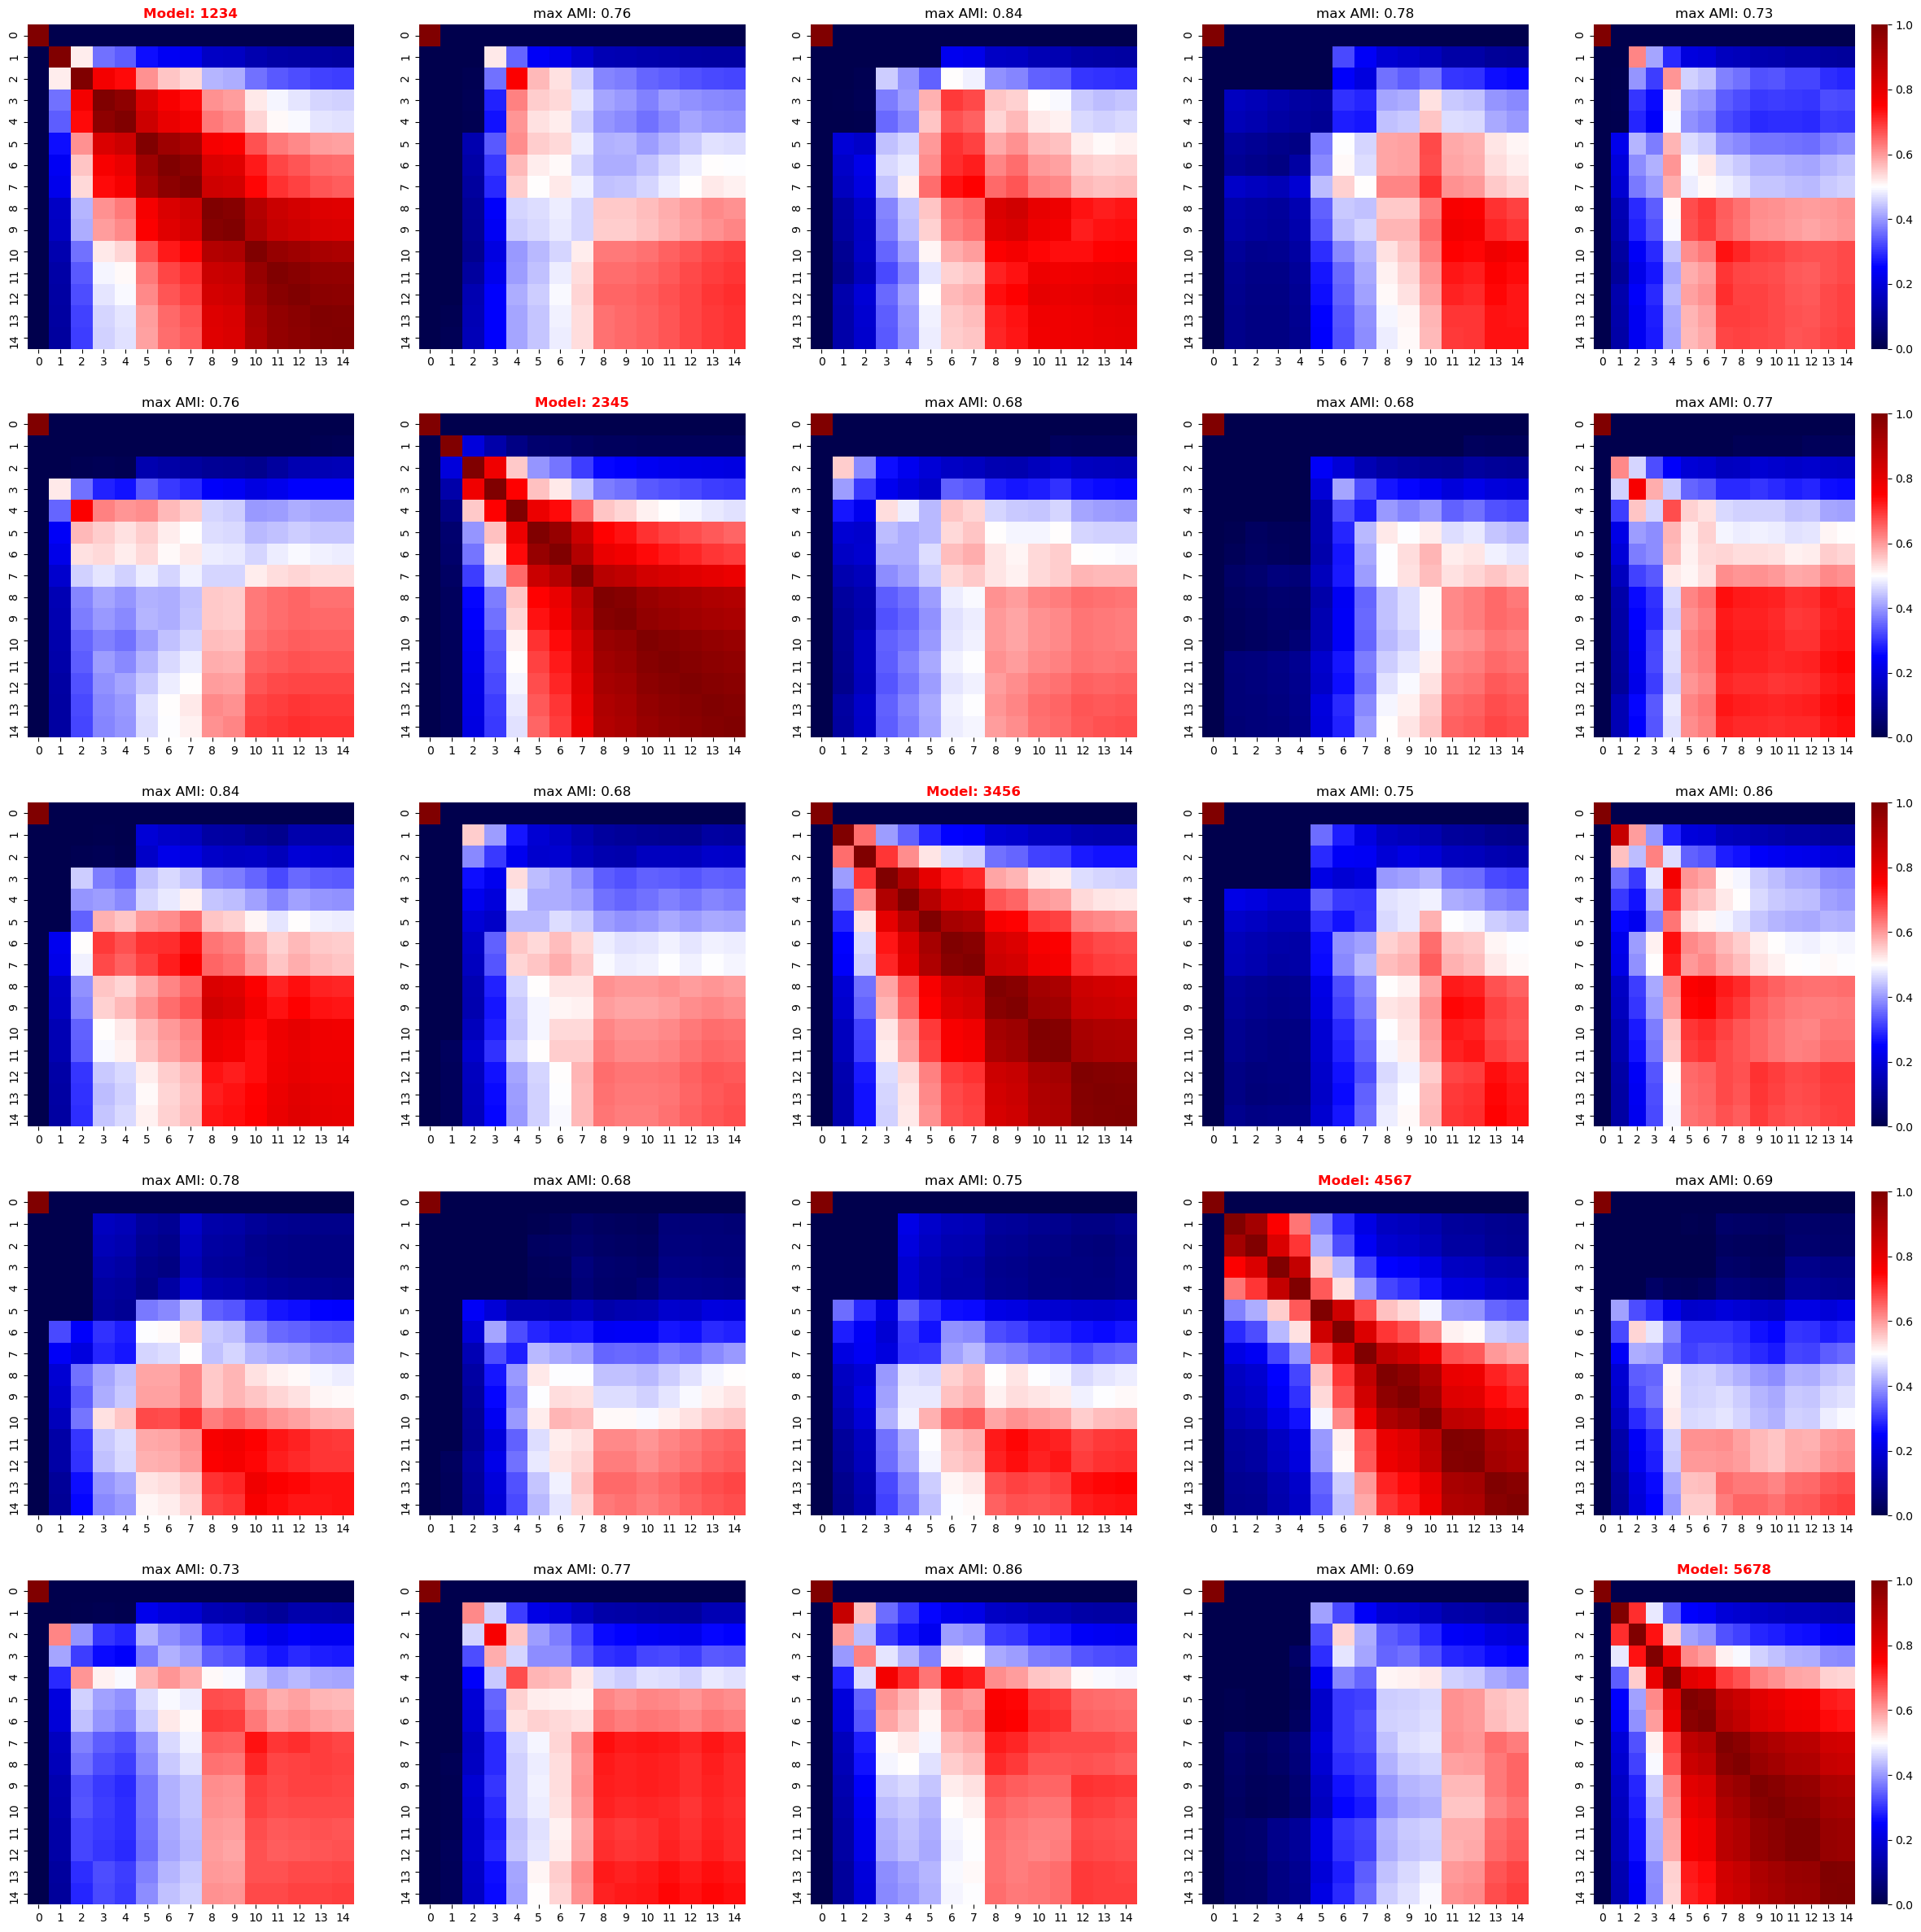

 50%|████▉     | 497/1000 [00:23<00:23, 21.45it/s]


------------------------------------------------------------


 38%|███▊      | 375/1000 [00:07<00:12, 49.42it/s] 


------------------------------------------------------------


 39%|███▉      | 394/1000 [00:10<00:15, 39.33it/s] 


------------------------------------------------------------


 33%|███▎      | 332/1000 [00:15<00:30, 21.59it/s]


------------------------------------------------------------


 35%|███▍      | 348/1000 [00:16<00:30, 21.55it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


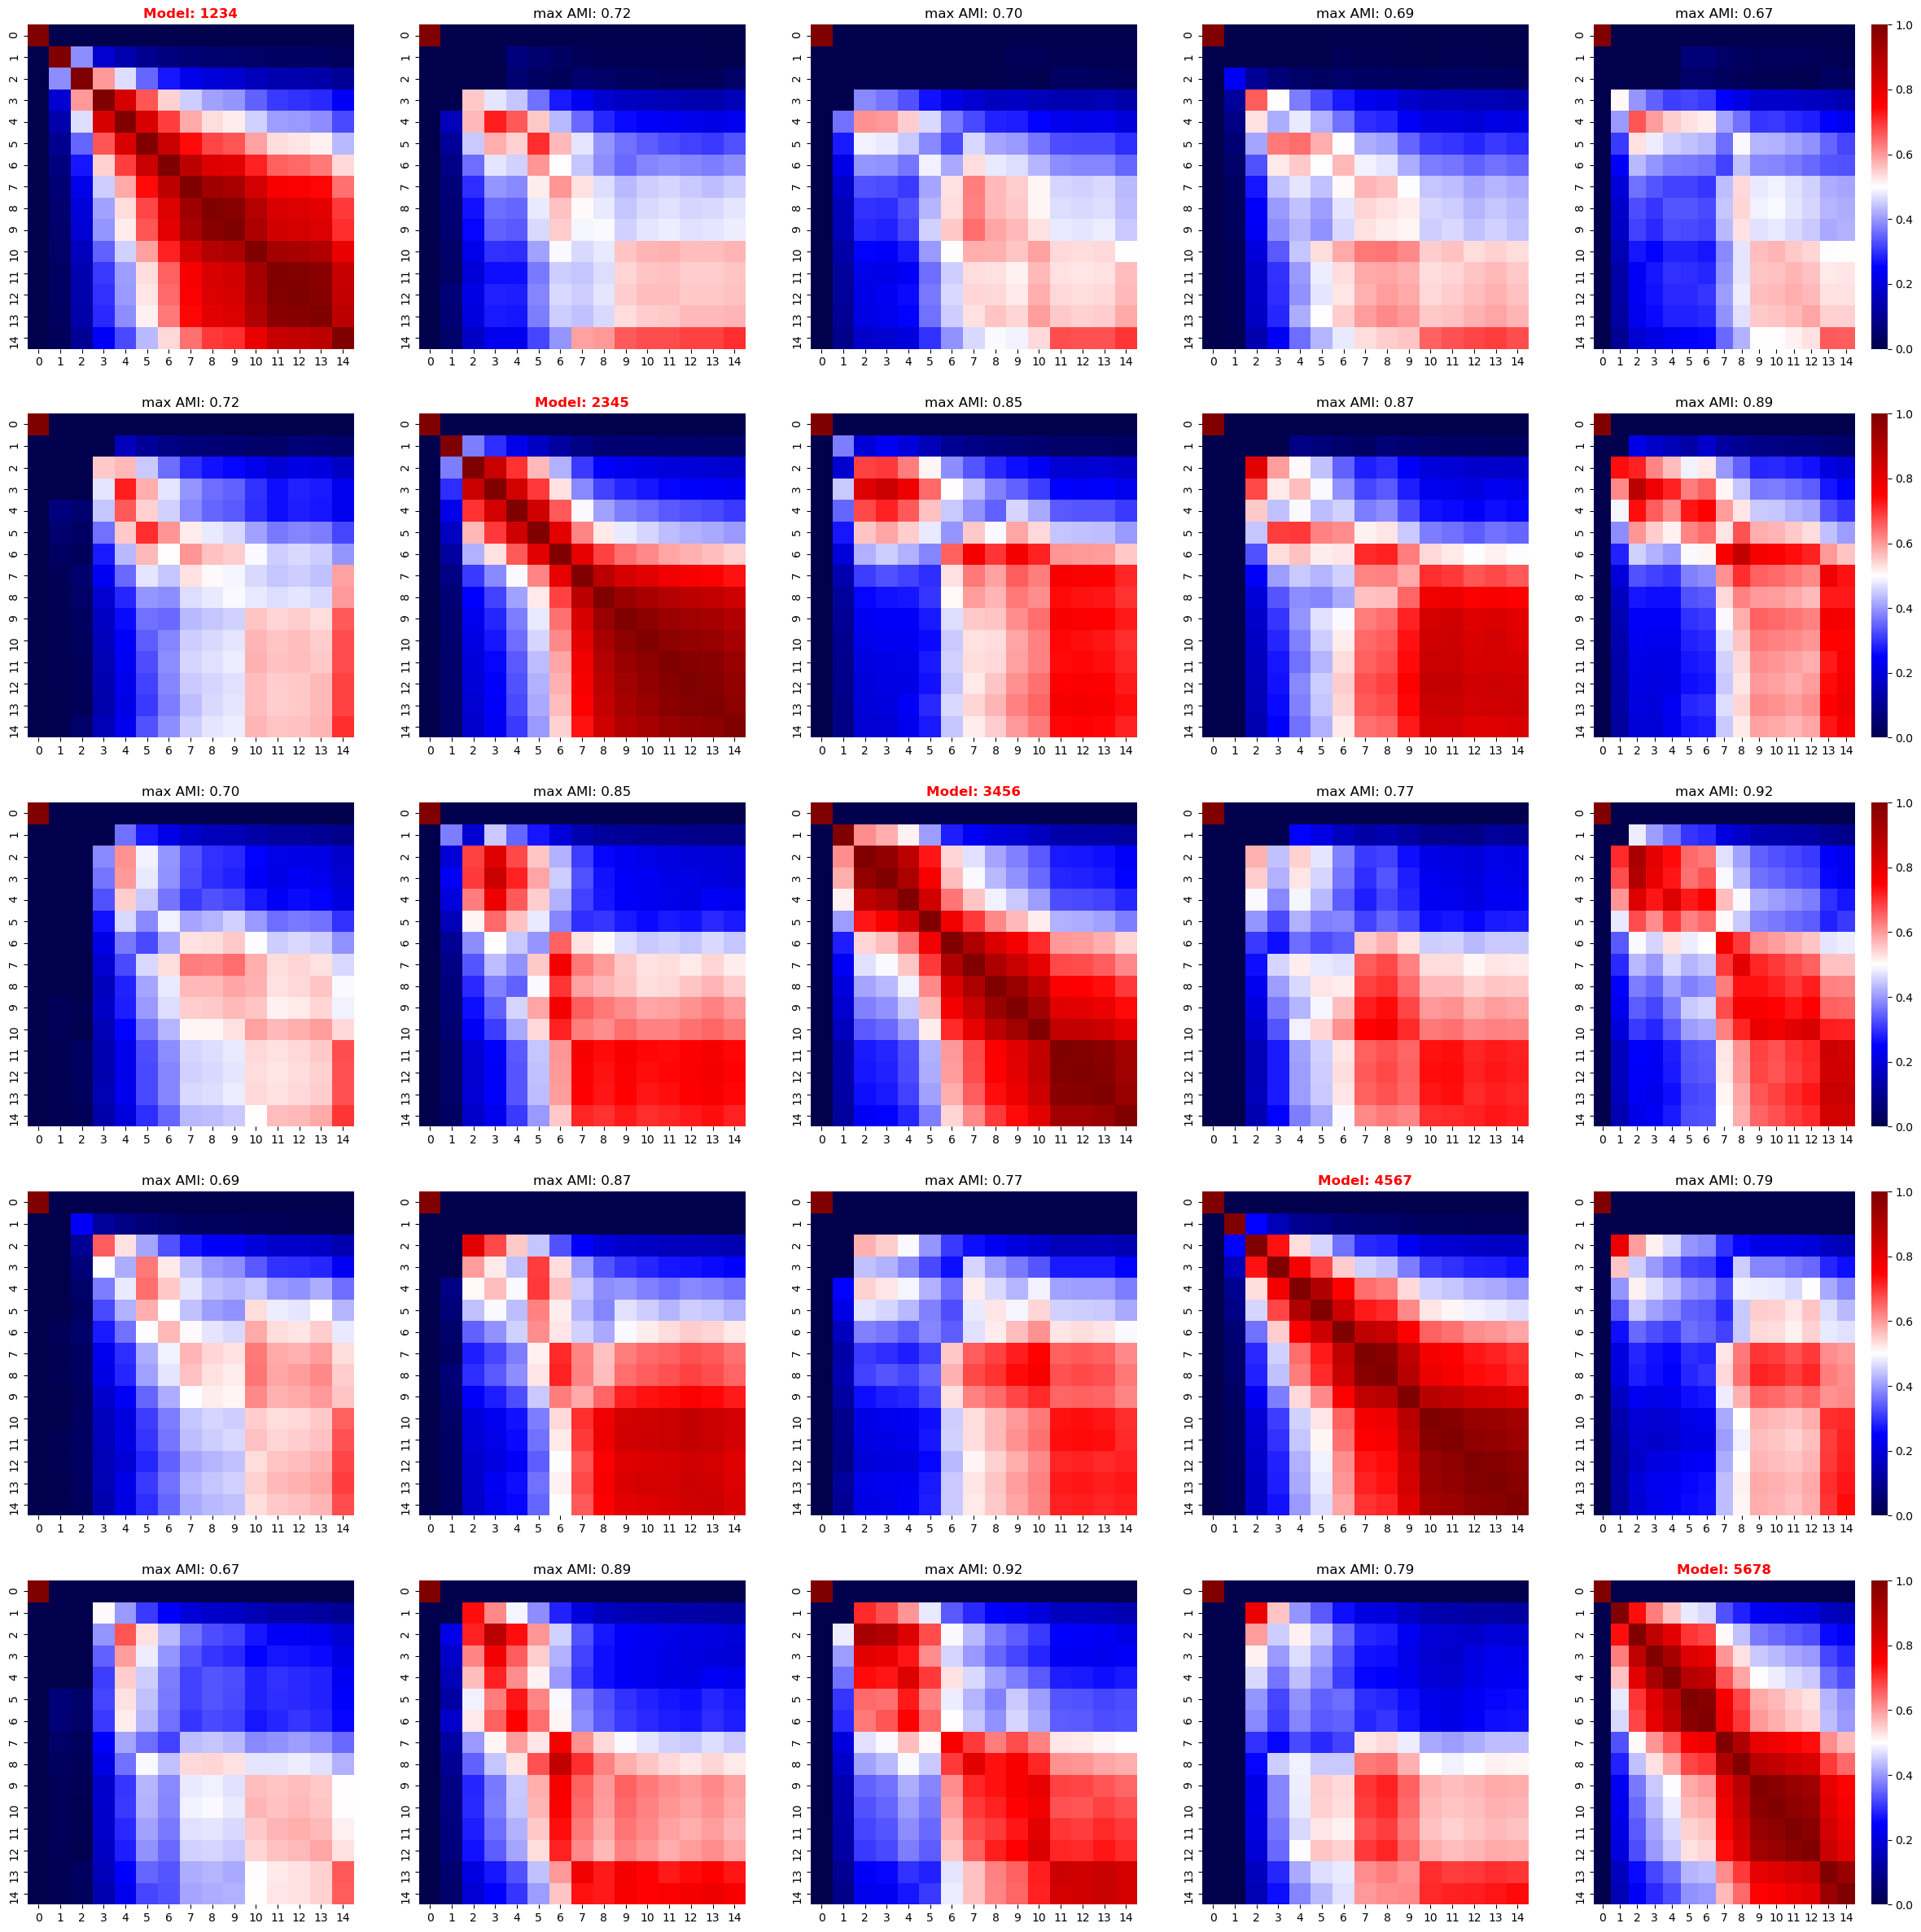

 33%|███▎      | 331/1000 [00:15<00:30, 21.89it/s]


------------------------------------------------------------


 31%|███▏      | 314/1000 [00:10<00:23, 29.55it/s] 


------------------------------------------------------------


 32%|███▏      | 323/1000 [00:06<00:12, 53.28it/s] 


------------------------------------------------------------


 31%|███       | 306/1000 [00:11<00:25, 27.36it/s]


------------------------------------------------------------


 38%|███▊      | 384/1000 [00:17<00:28, 21.78it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


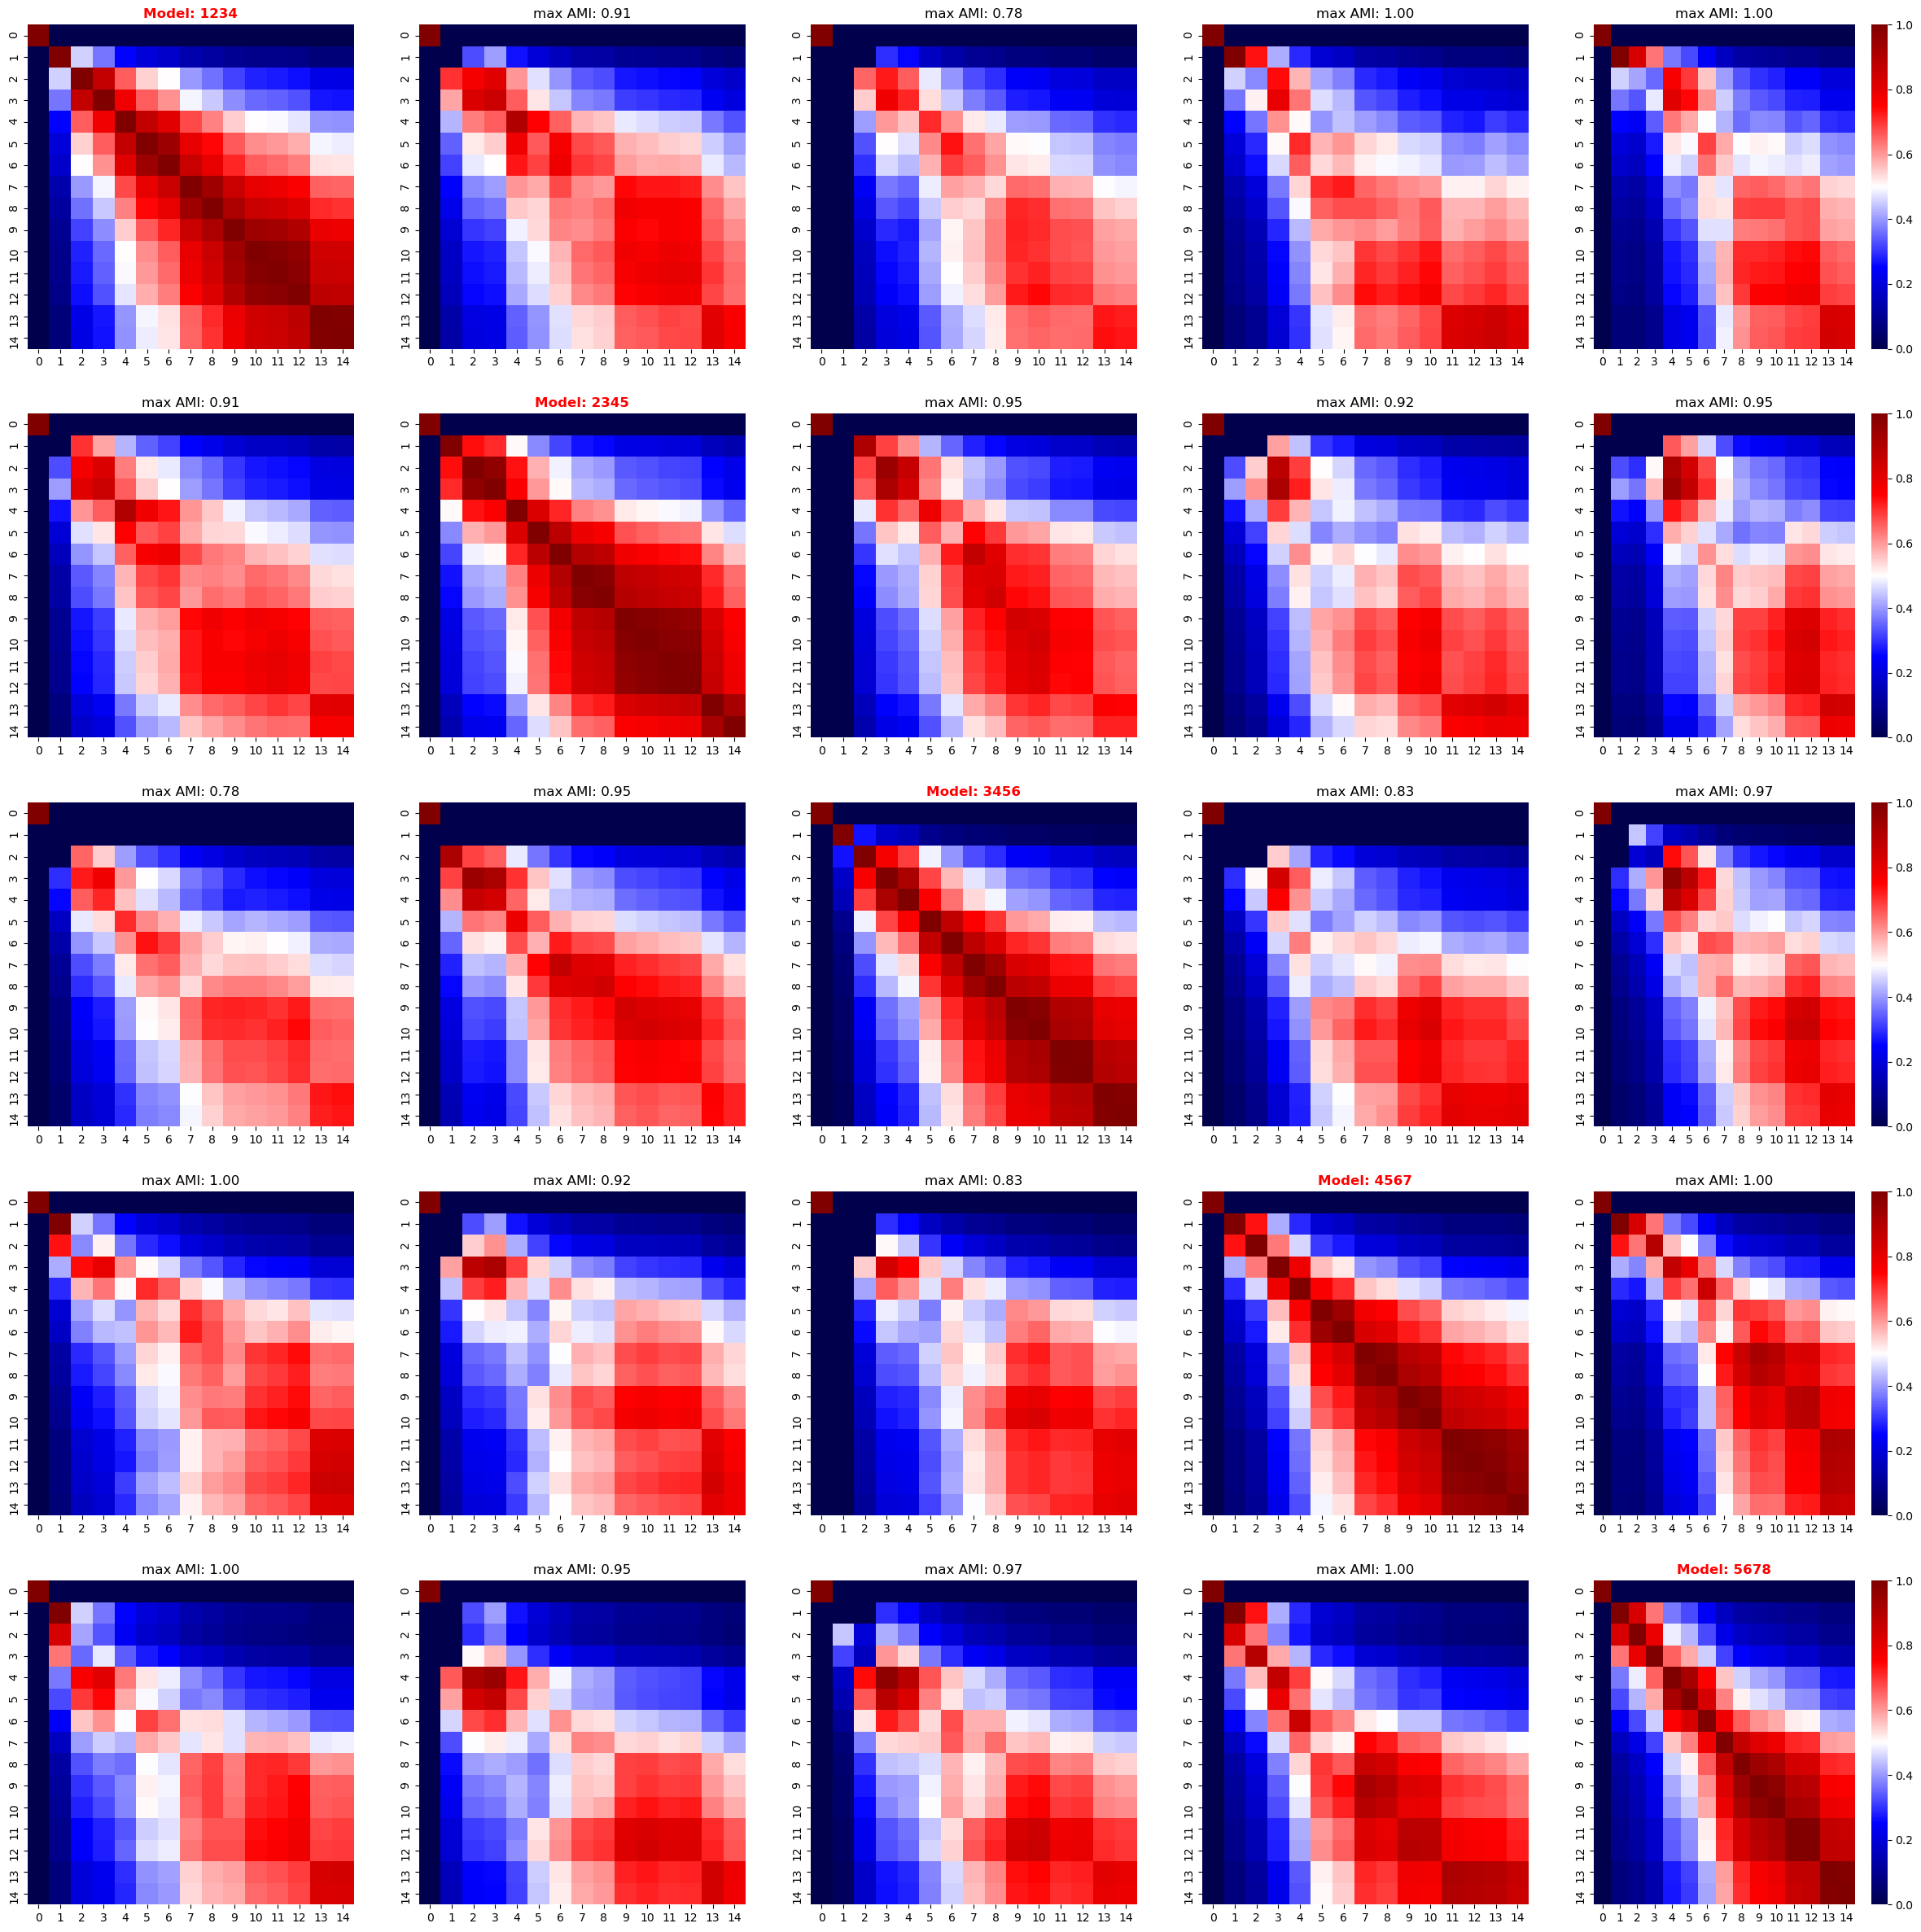

<IPython.core.display.Javascript object>

In [11]:
node_feature_key = "hallmark"
for latent_dim in latent_dims:
    latents_dict_hallgae = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=50,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        plot_loss=False,
    )
    stability_amis_hallgae = stability_cocluster_screen(
        latents_dict_hallgae, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgae)

We find the embeddings for the Hallmark GAE to be relatively stable for different numbers of latent dimensions.

---

##### Hallmark-GEX GAE

Finally, we train an autoencoder using both the binary hallmark geneset features and the min-max-scaled gene expression data as inputs.

 75%|███████▌  | 750/1000 [00:34<00:11, 21.68it/s]


------------------------------------------------------------


 44%|████▎     | 437/1000 [00:07<00:09, 58.00it/s] 


------------------------------------------------------------


 91%|█████████ | 908/1000 [00:37<00:03, 23.90it/s]


------------------------------------------------------------


100%|█████████▉| 995/1000 [00:27<00:00, 35.63it/s] 


------------------------------------------------------------


 82%|████████▏ | 818/1000 [00:33<00:07, 24.77it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


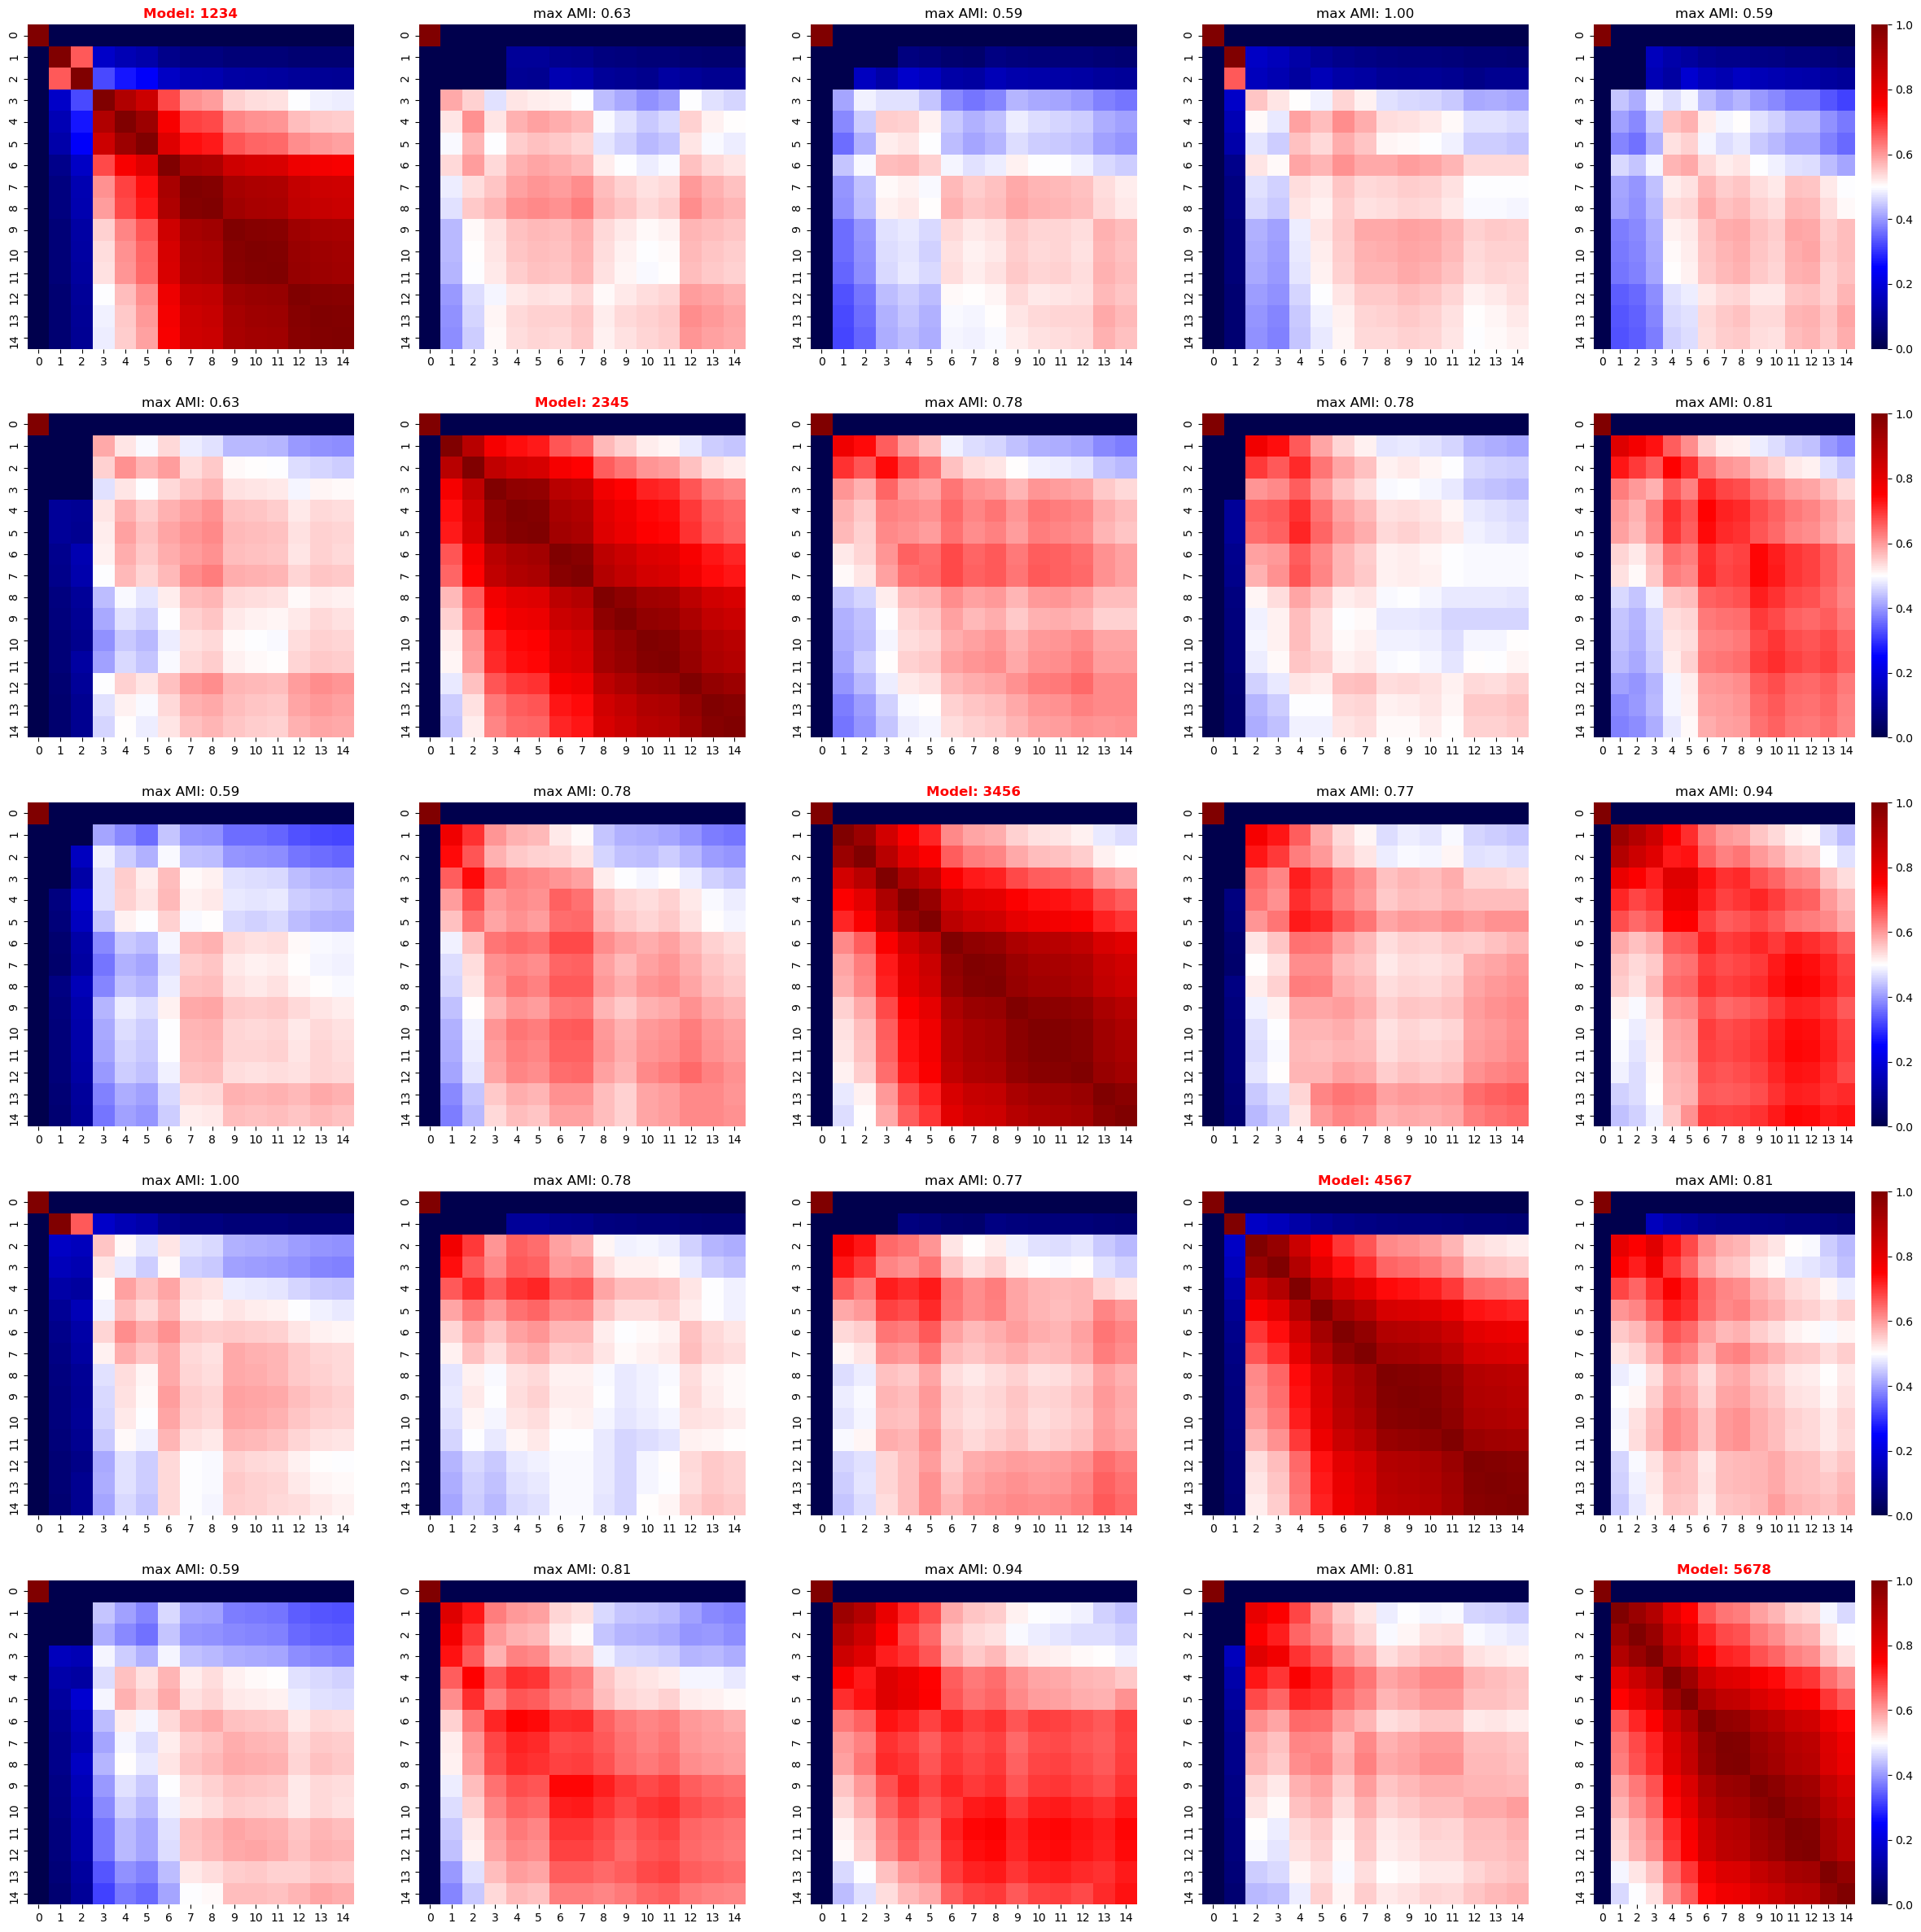

 66%|██████▌   | 661/1000 [00:22<00:11, 29.72it/s] 


------------------------------------------------------------


 64%|██████▎   | 635/1000 [00:21<00:12, 29.38it/s] 


------------------------------------------------------------


100%|██████████| 1000/1000 [00:32<00:00, 30.38it/s]


------------------------------------------------------------


 77%|███████▋  | 766/1000 [00:31<00:09, 24.21it/s]


------------------------------------------------------------


 54%|█████▎    | 536/1000 [00:17<00:15, 30.83it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


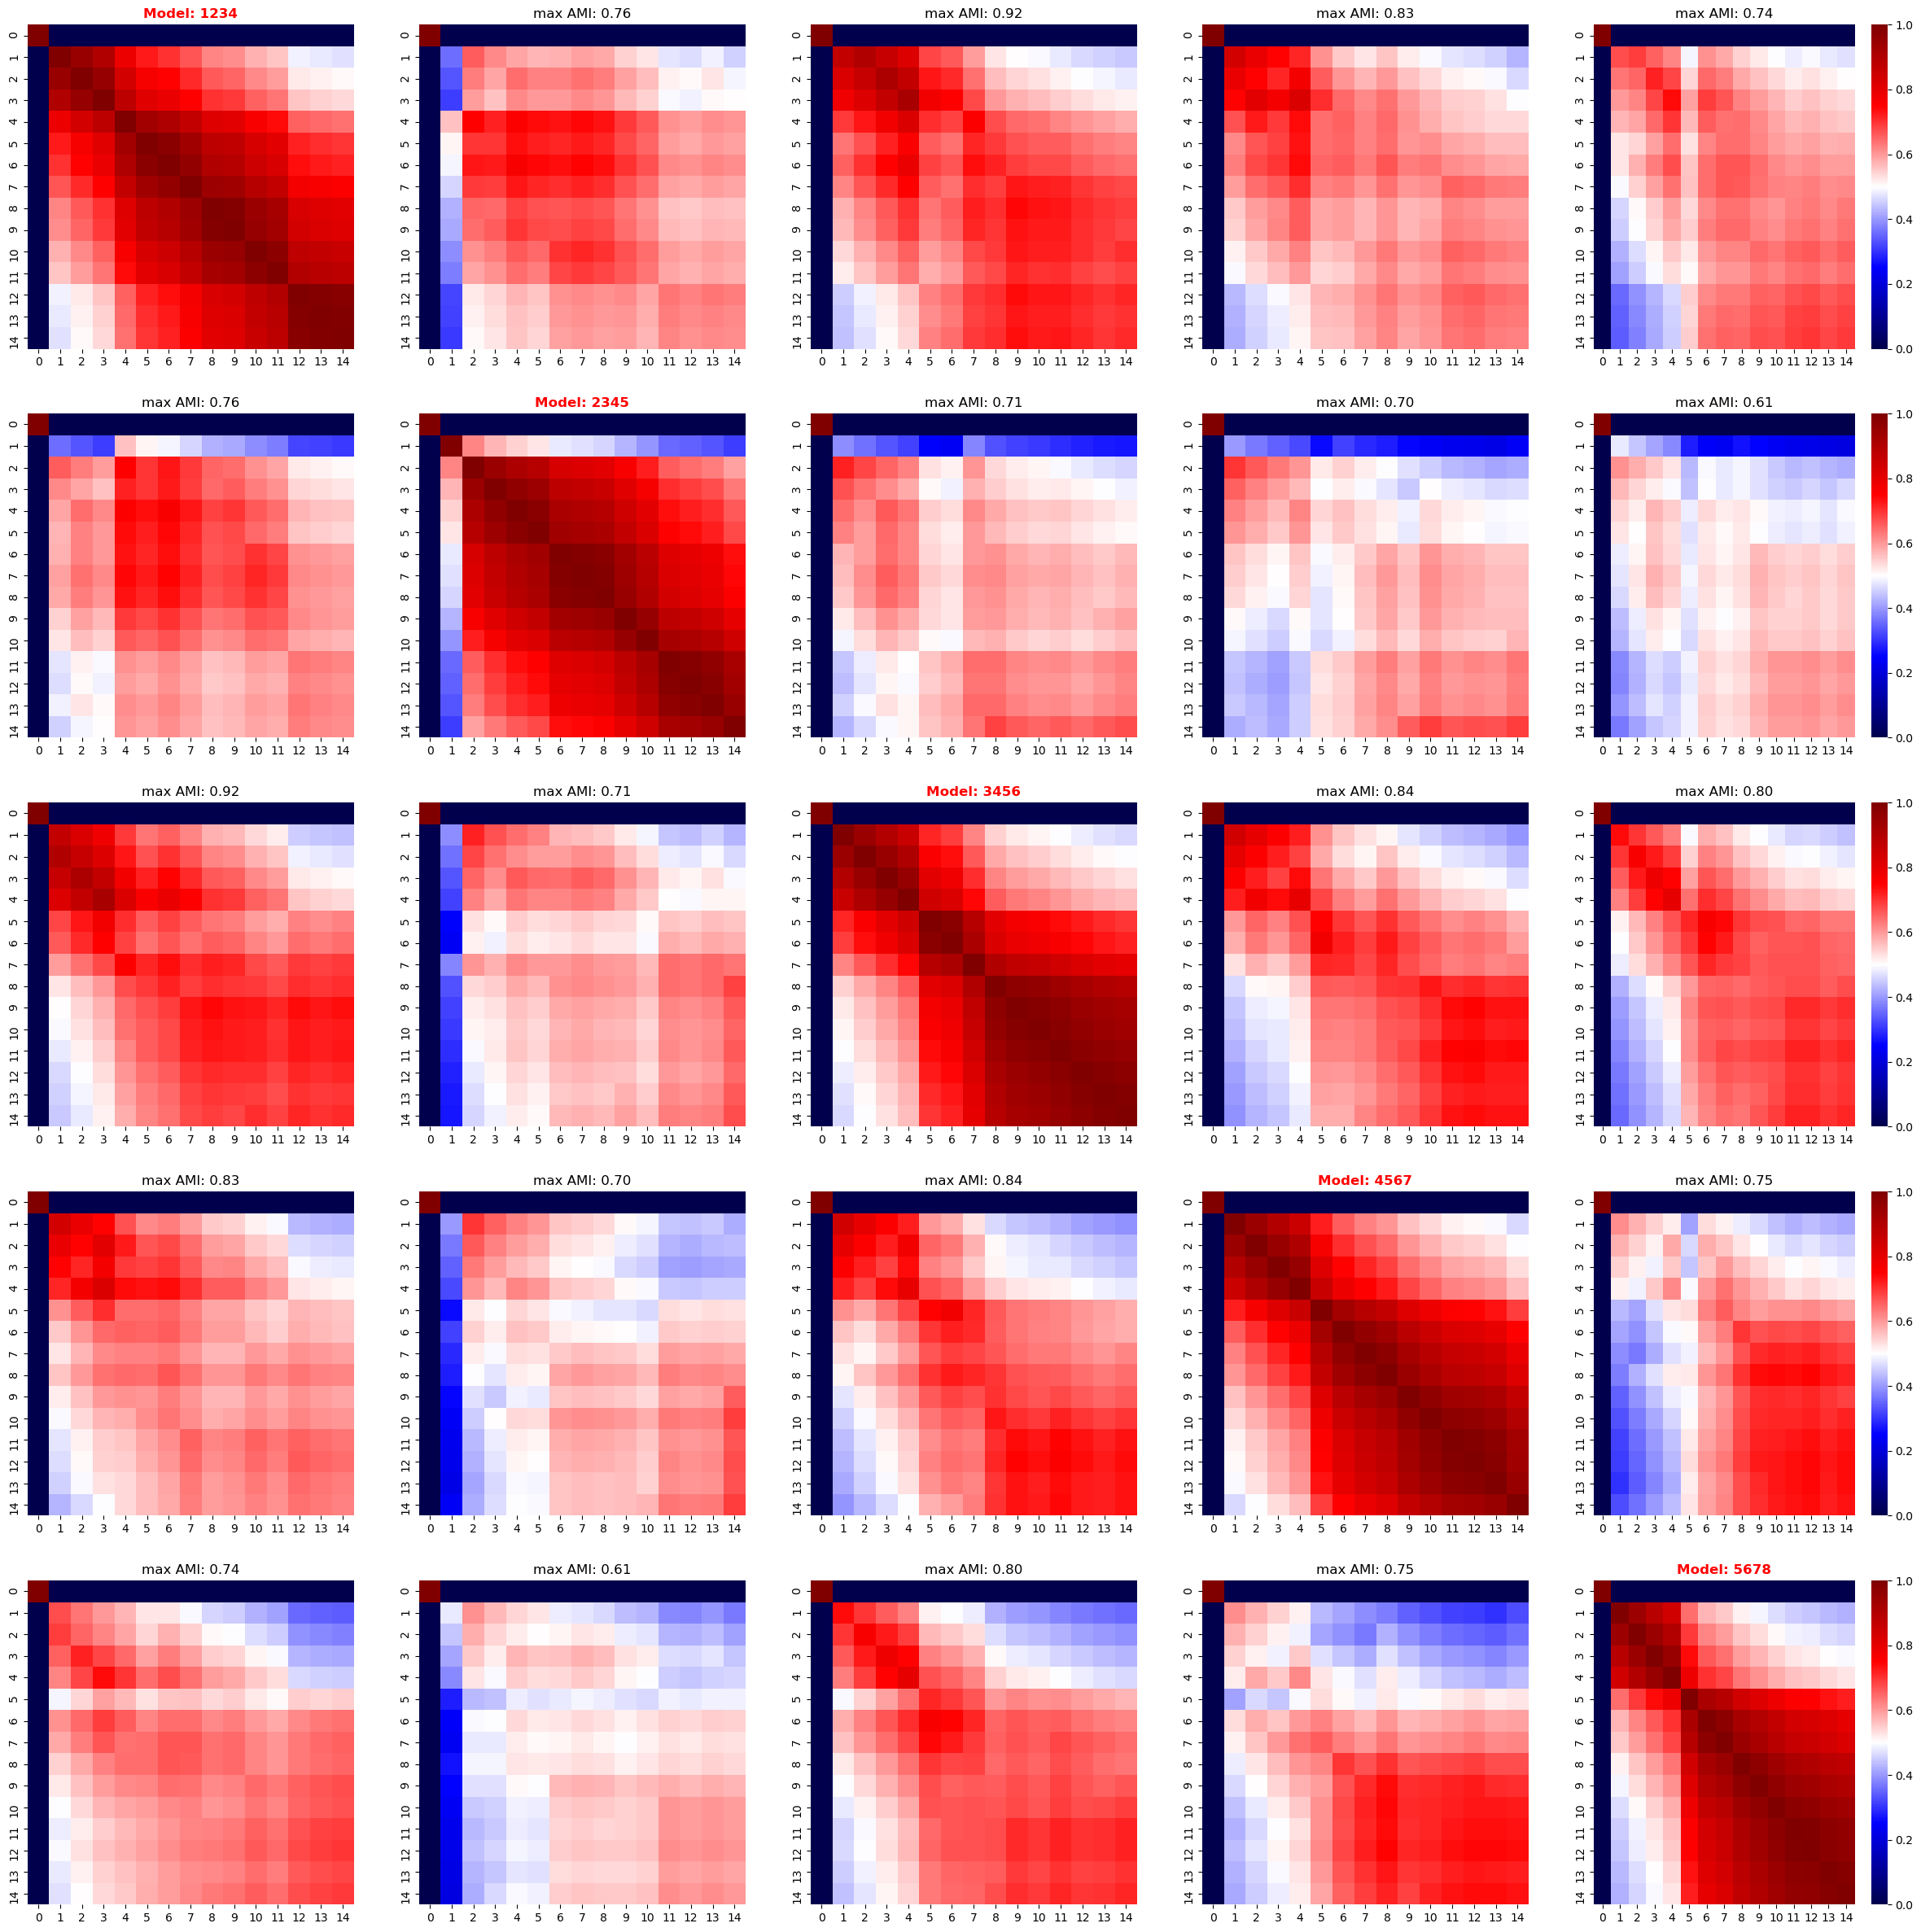

 73%|███████▎  | 733/1000 [00:34<00:12, 21.44it/s]


------------------------------------------------------------


 61%|██████    | 611/1000 [00:17<00:11, 34.62it/s] 


------------------------------------------------------------


 62%|██████▏   | 617/1000 [00:22<00:13, 27.38it/s]


------------------------------------------------------------


 66%|██████▌   | 661/1000 [00:30<00:15, 21.64it/s]


------------------------------------------------------------


 58%|█████▊    | 576/1000 [00:14<00:10, 39.94it/s] 


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


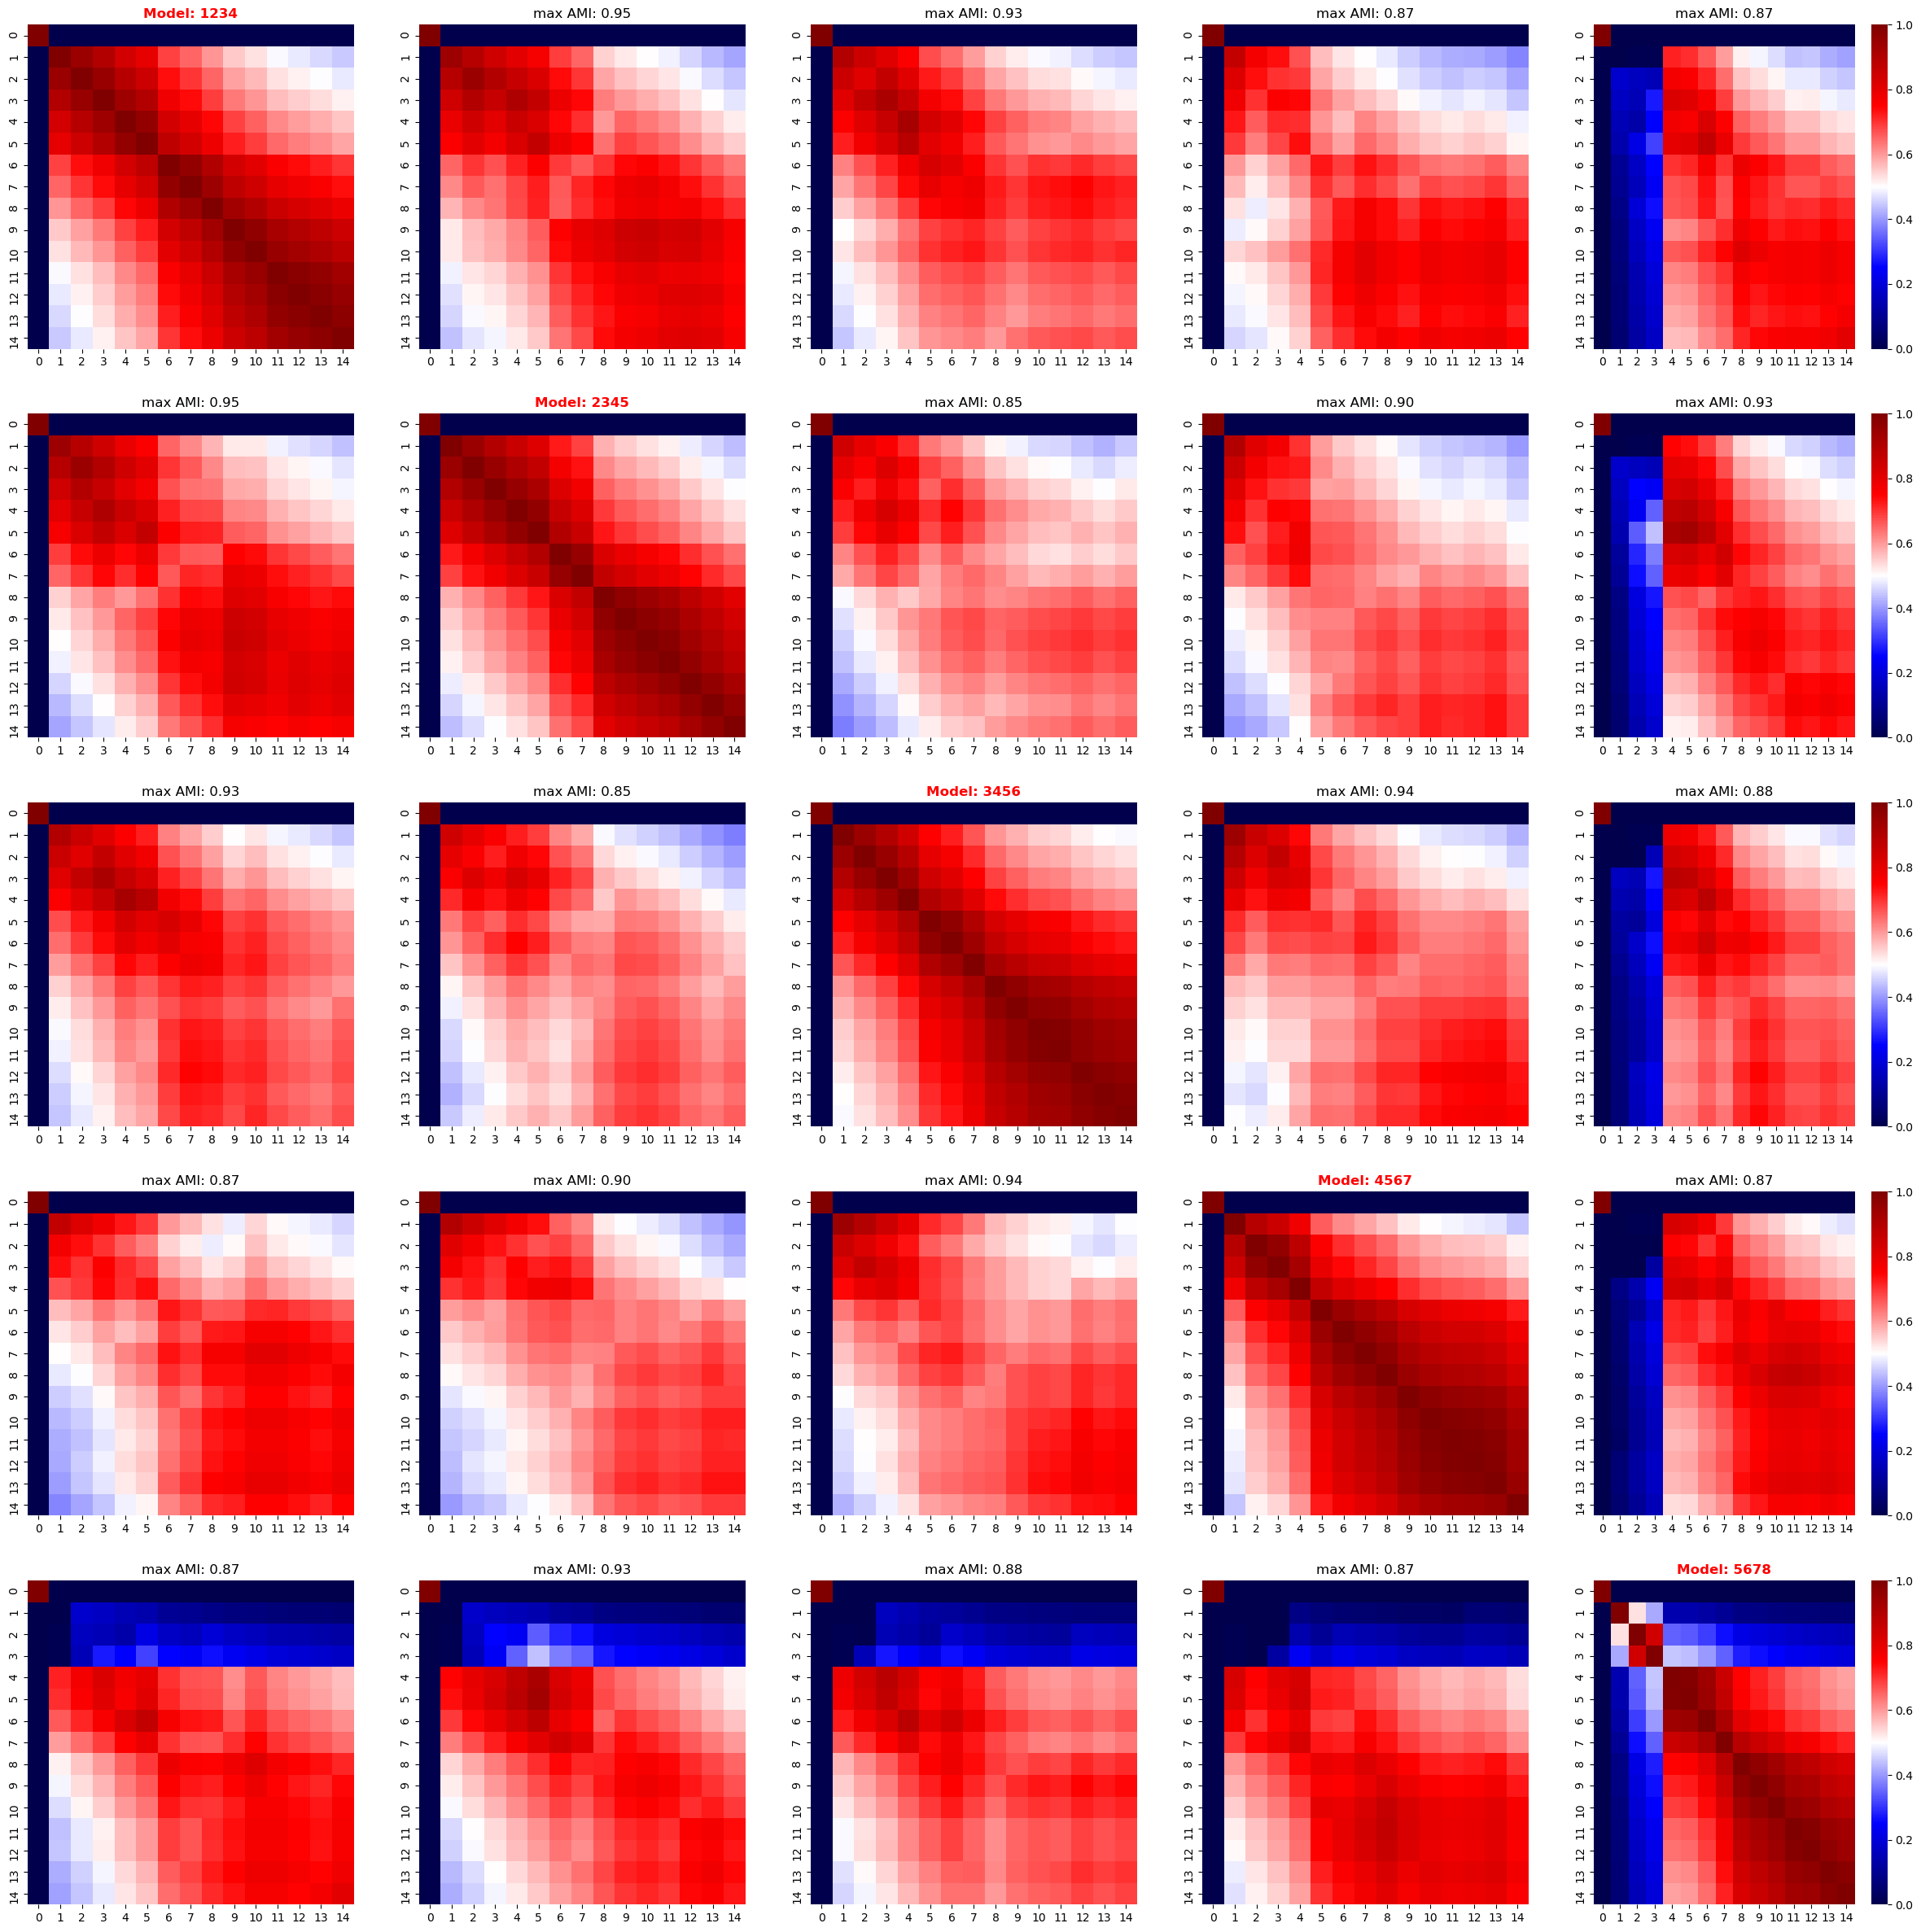

<IPython.core.display.Javascript object>

In [12]:
node_feature_key = "sc_gex_hallmark"

for latent_dim in latent_dims:
    latents_dict_hallgexgae = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=1176,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        lr=0.00001,
        plot_loss=False,
    )
    stability_amis_hallgexgae = stability_cocluster_screen(
        latents_dict_hallgexgae, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgexgae)

We obtain fairly stable results for different choices of the size of the latent space as well.

---

##### Hallmark-GEX GAE (link prediction)

We will now reassess the previous model's stability when training it on a link-prediction task.
That is the data will also be split differently for each term.

 40%|████      | 405/1000 [00:23<00:34, 17.04it/s]


------------------------------------------------------------
TEST AUC: 0.7299408284023668 	 AP: 0.7226773776980981


 45%|████▌     | 451/1000 [00:12<00:15, 36.50it/s]


------------------------------------------------------------
TEST AUC: 0.7057071960297768 	 AP: 0.7212284733325687


 56%|█████▋    | 565/1000 [00:32<00:24, 17.62it/s]


------------------------------------------------------------
TEST AUC: 0.8348557692307692 	 AP: 0.8070035930127439


 72%|███████▏  | 720/1000 [00:33<00:12, 21.80it/s]


------------------------------------------------------------
TEST AUC: 0.6906508875739644 	 AP: 0.717559240641934


 61%|██████    | 610/1000 [00:27<00:17, 21.95it/s]


------------------------------------------------------------
TEST AUC: 0.7360195360195361 	 AP: 0.7331507506221215


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


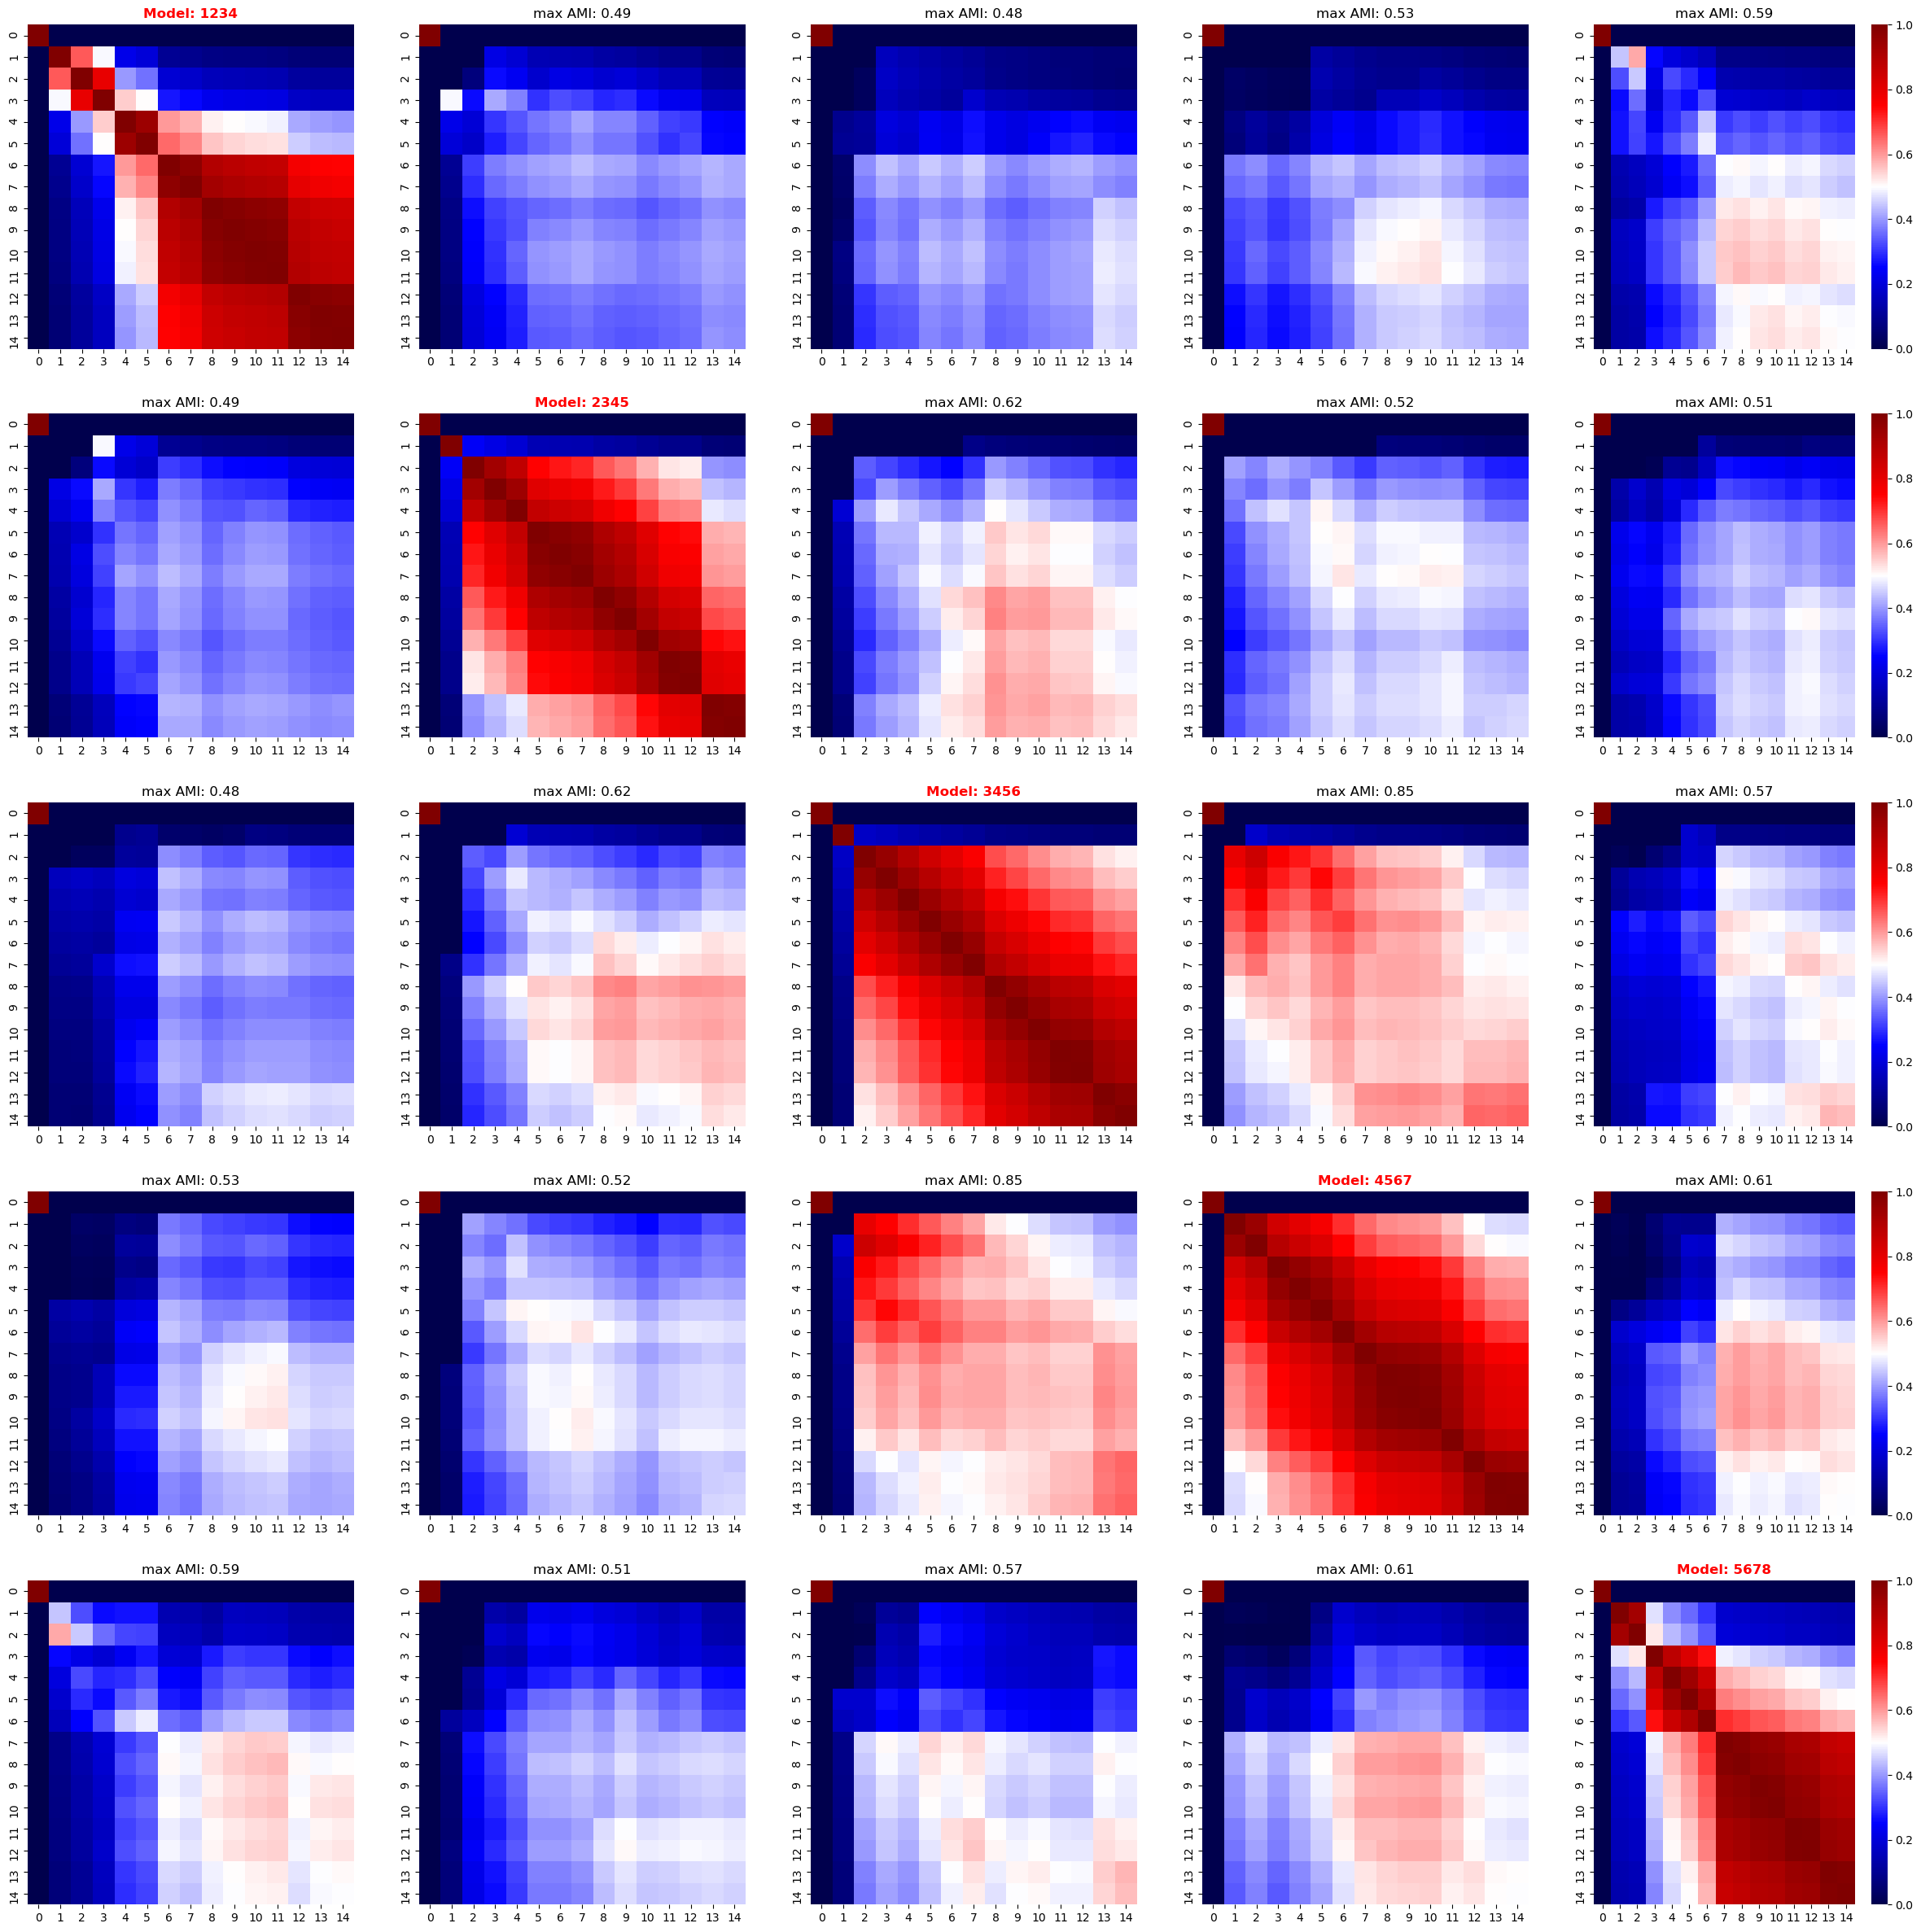

 50%|█████     | 500/1000 [00:13<00:13, 36.84it/s]


------------------------------------------------------------
TEST AUC: 0.7514792899408284 	 AP: 0.771818224825348


 47%|████▋     | 471/1000 [00:27<00:30, 17.13it/s]


------------------------------------------------------------
TEST AUC: 0.6686390532544378 	 AP: 0.7112910070187488


 61%|██████    | 612/1000 [00:29<00:18, 20.56it/s]


------------------------------------------------------------
TEST AUC: 0.810887573964497 	 AP: 0.8224966521518415


 39%|███▉      | 389/1000 [00:13<00:21, 28.32it/s]


------------------------------------------------------------
TEST AUC: 0.69396449704142 	 AP: 0.7489188493625696


 48%|████▊     | 475/1000 [00:27<00:29, 17.59it/s]


------------------------------------------------------------
TEST AUC: 0.7843786982248521 	 AP: 0.8009785740800415


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


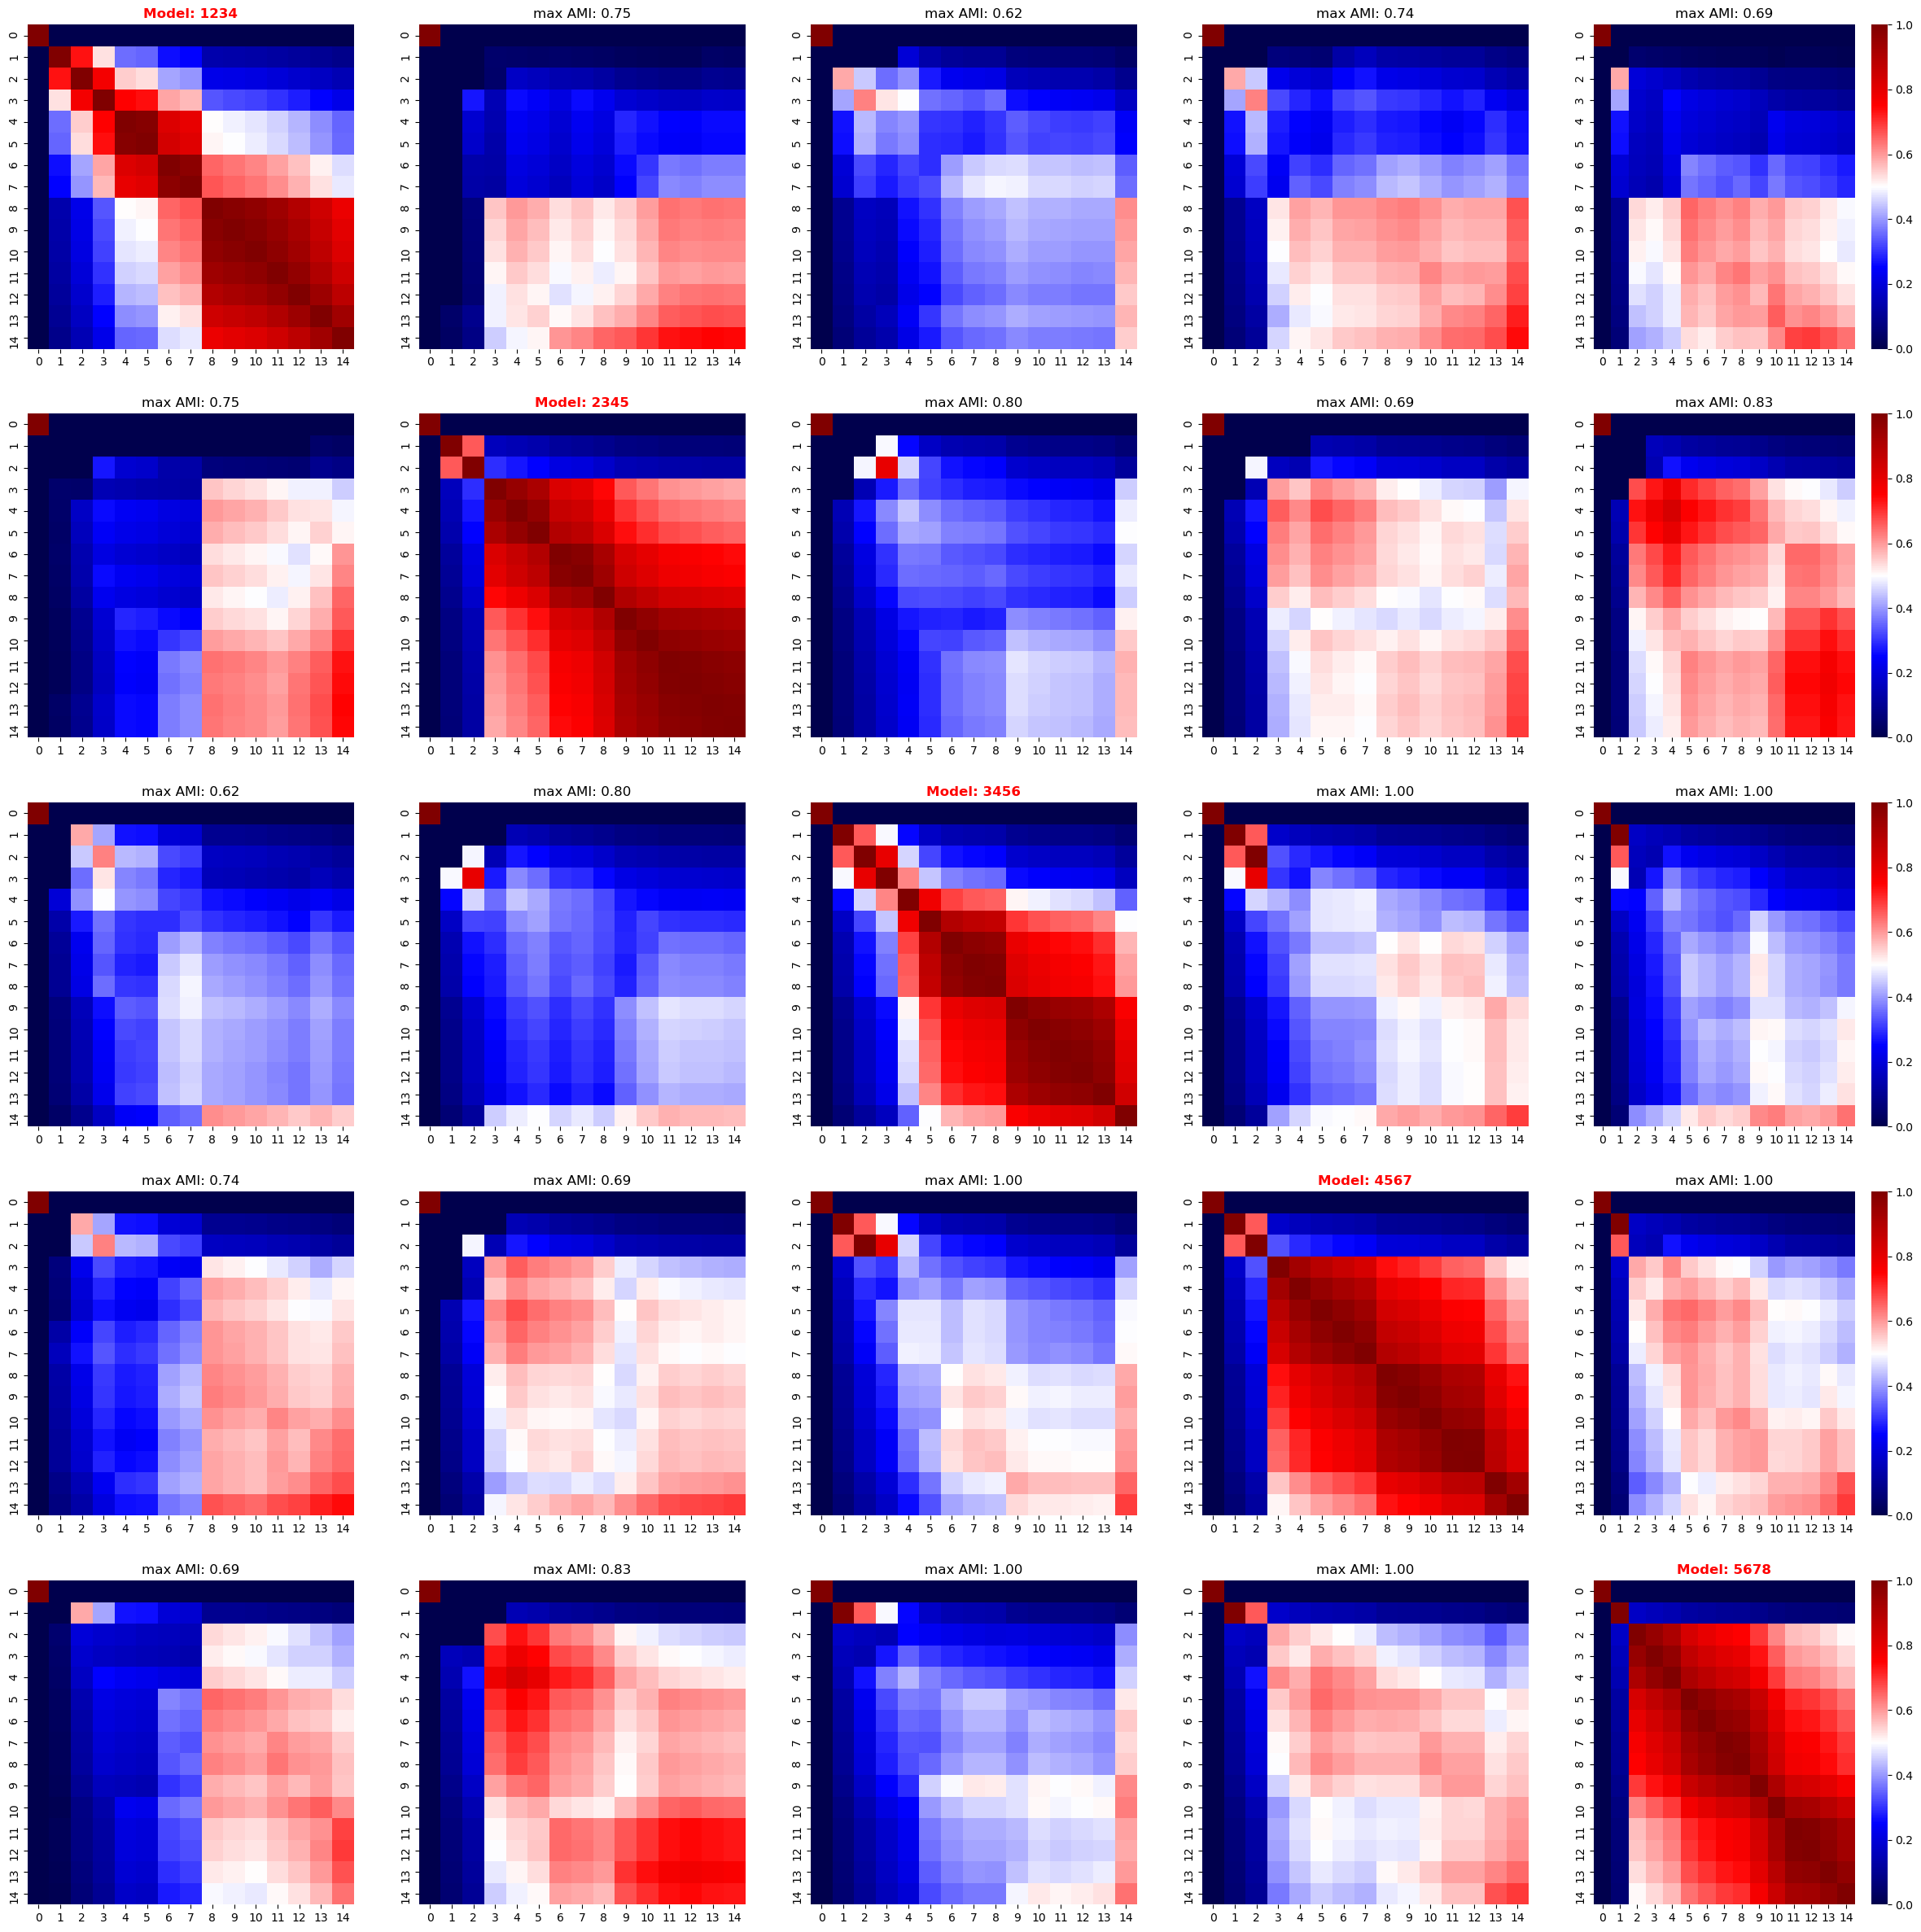

 34%|███▎      | 335/1000 [00:15<00:30, 21.76it/s]


------------------------------------------------------------
TEST AUC: 0.7453254437869822 	 AP: 0.7458613308928319


 54%|█████▍    | 540/1000 [00:31<00:26, 17.31it/s]


------------------------------------------------------------
TEST AUC: 0.7225961538461538 	 AP: 0.7614992507812981


 54%|█████▍    | 540/1000 [00:20<00:17, 26.76it/s]


------------------------------------------------------------
TEST AUC: 0.8217751479289942 	 AP: 0.8027162290006424


 41%|████      | 407/1000 [00:19<00:28, 21.01it/s]


------------------------------------------------------------
TEST AUC: 0.7682539682539682 	 AP: 0.8006963486656964


 47%|████▋     | 470/1000 [00:27<00:30, 17.31it/s]


------------------------------------------------------------
TEST AUC: 0.7742011834319527 	 AP: 0.7846320765341495


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


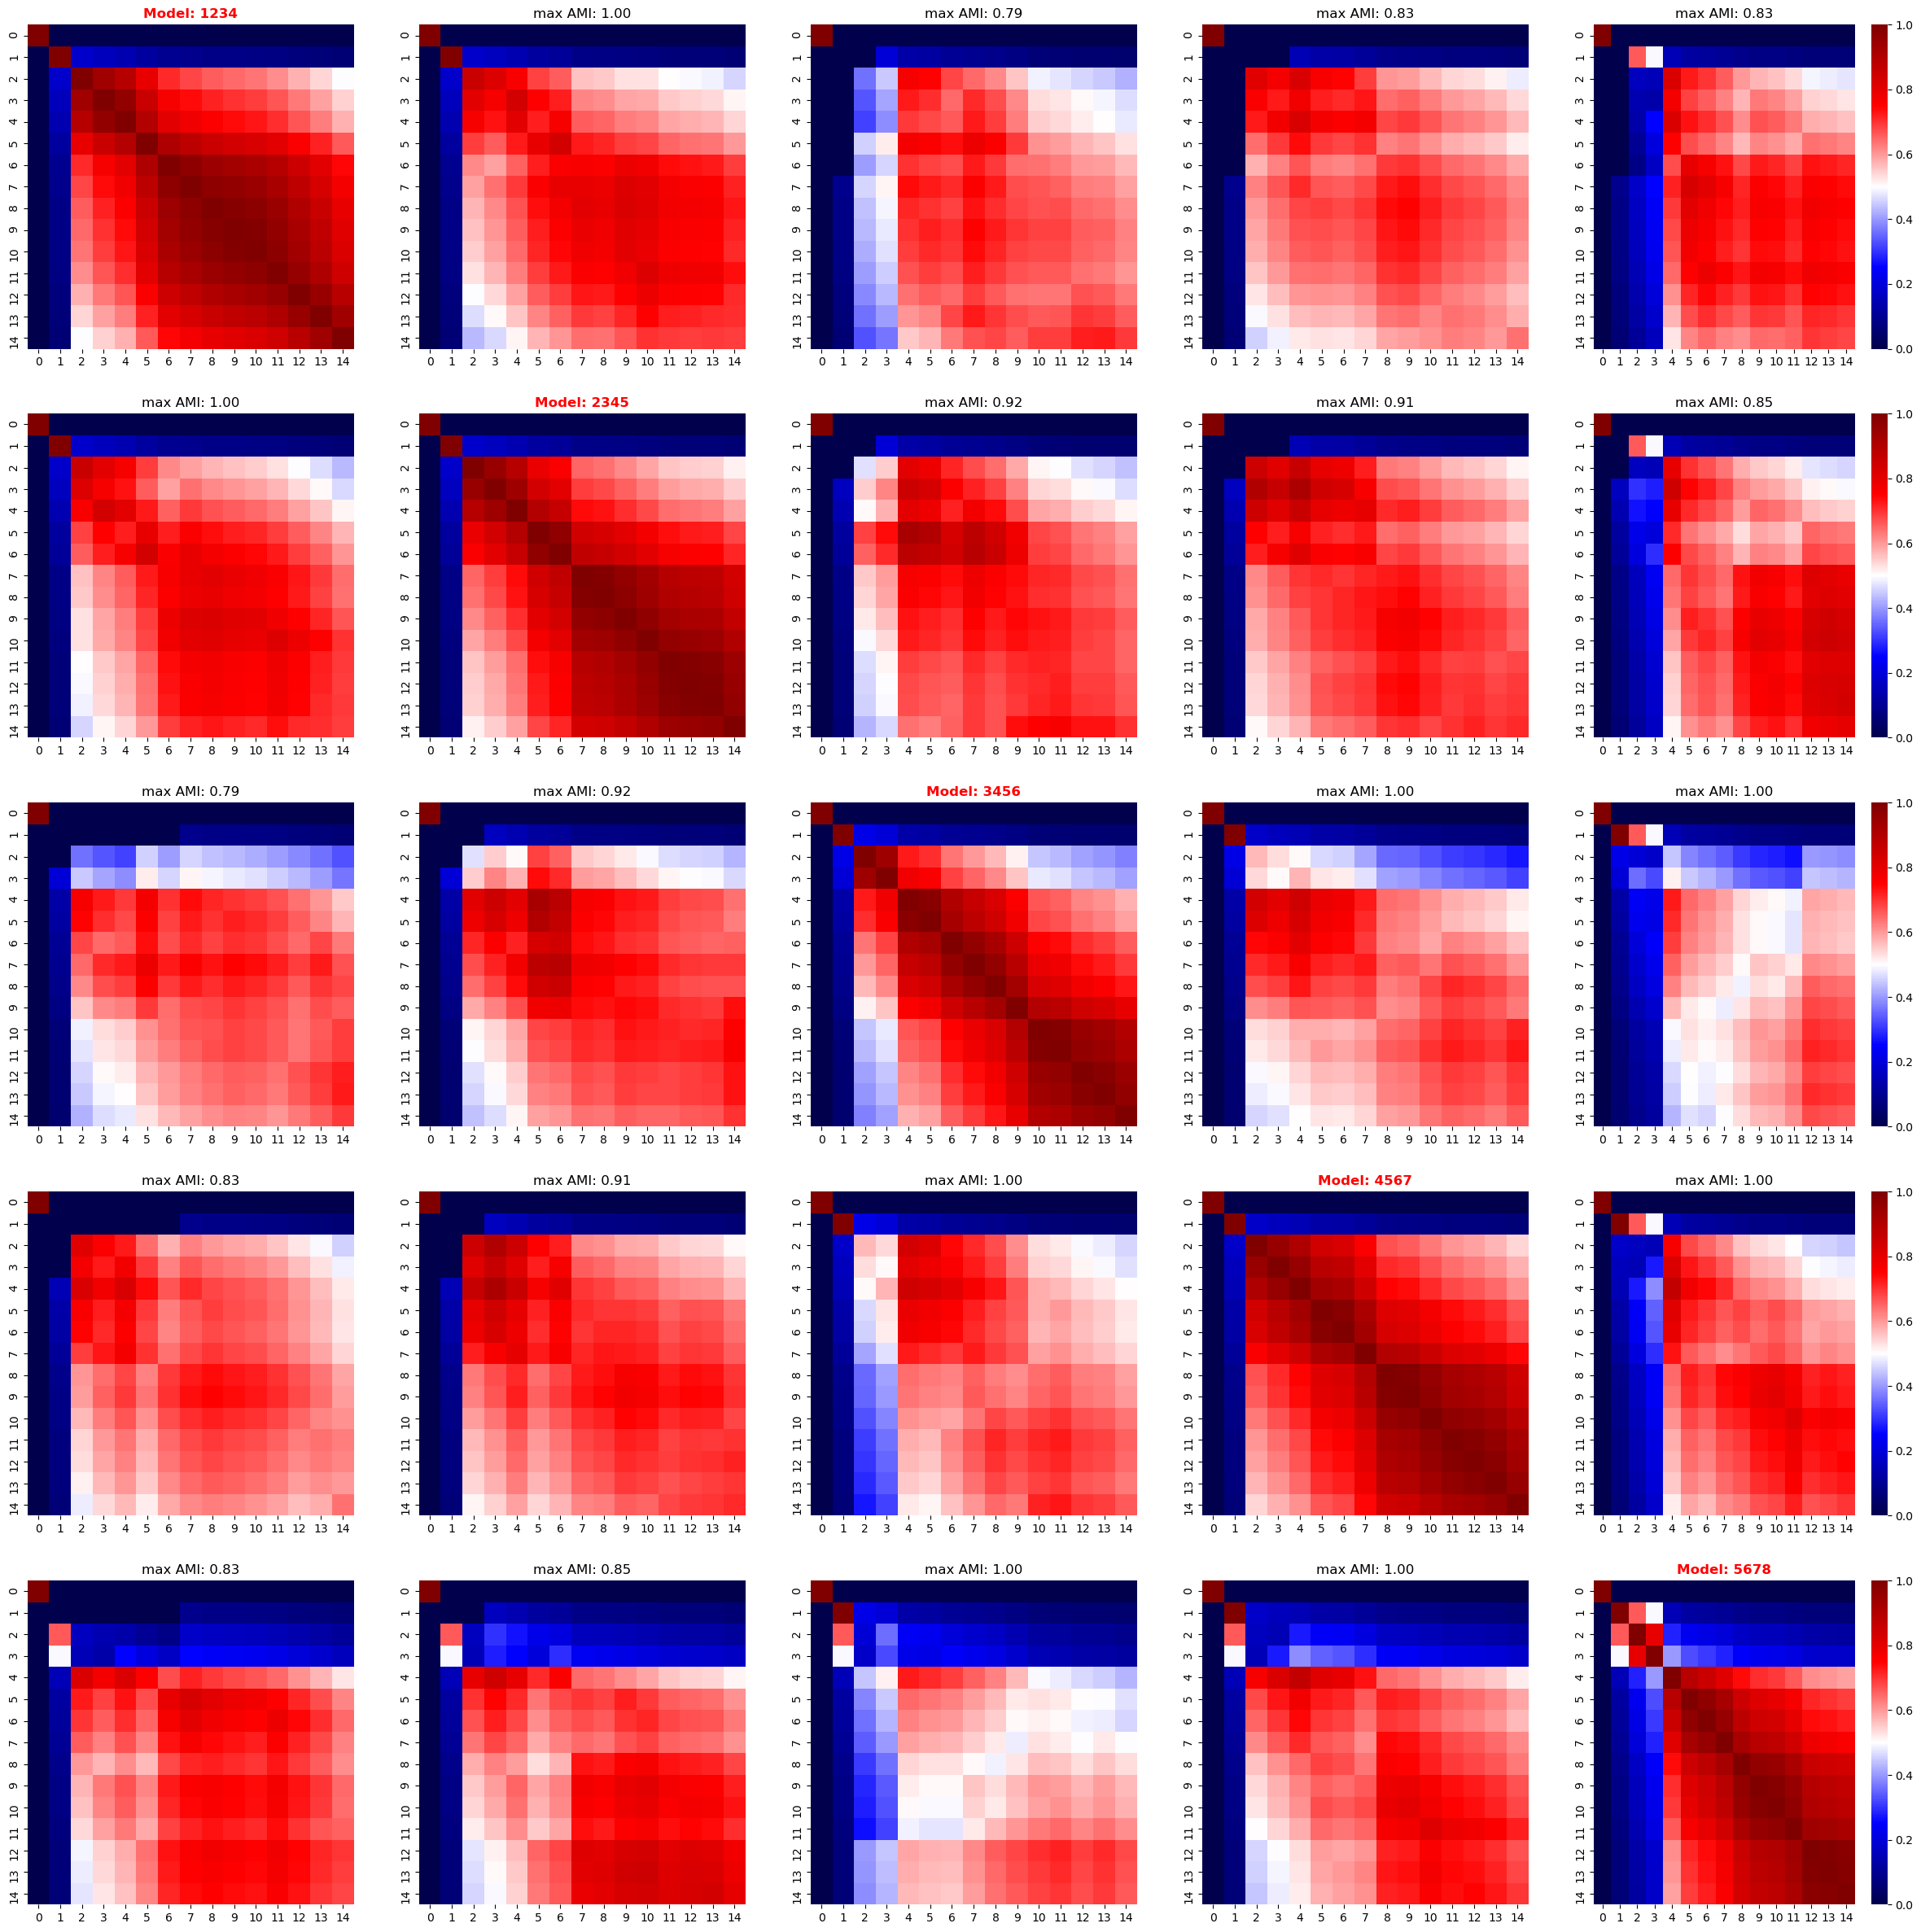

<IPython.core.display.Javascript object>

In [13]:
node_feature_key = "sc_gex_hallmark"
for latent_dim in latent_dims:
    latents_dict_hallgexgae_lp = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=1176,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        lr=0.00001,
        link_pred=True,
        plot_loss=False,
    )
    stability_amis_hallgexgae_lp = stability_cocluster_screen(
        latents_dict_hallgexgae_lp, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgexgae_lp)

---

##### Hallmark-GEX GAE (adjacency & feature reconstruction)

Next, we keep the previous model setup but train it on the task of feature reconstruction and the reconstruction of the adjacency matrix without any training-validation or test split of the data.

Latent dim: 32


 65%|██████▌   | 651/1000 [00:38<00:20, 17.10it/s]


------------------------------------------------------------


 48%|████▊     | 480/1000 [00:17<00:18, 27.81it/s]


------------------------------------------------------------


 50%|████▉     | 495/1000 [00:26<00:26, 18.71it/s]


------------------------------------------------------------


 55%|█████▍    | 548/1000 [00:31<00:26, 17.24it/s]


------------------------------------------------------------


 65%|██████▍   | 649/1000 [00:24<00:13, 25.99it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


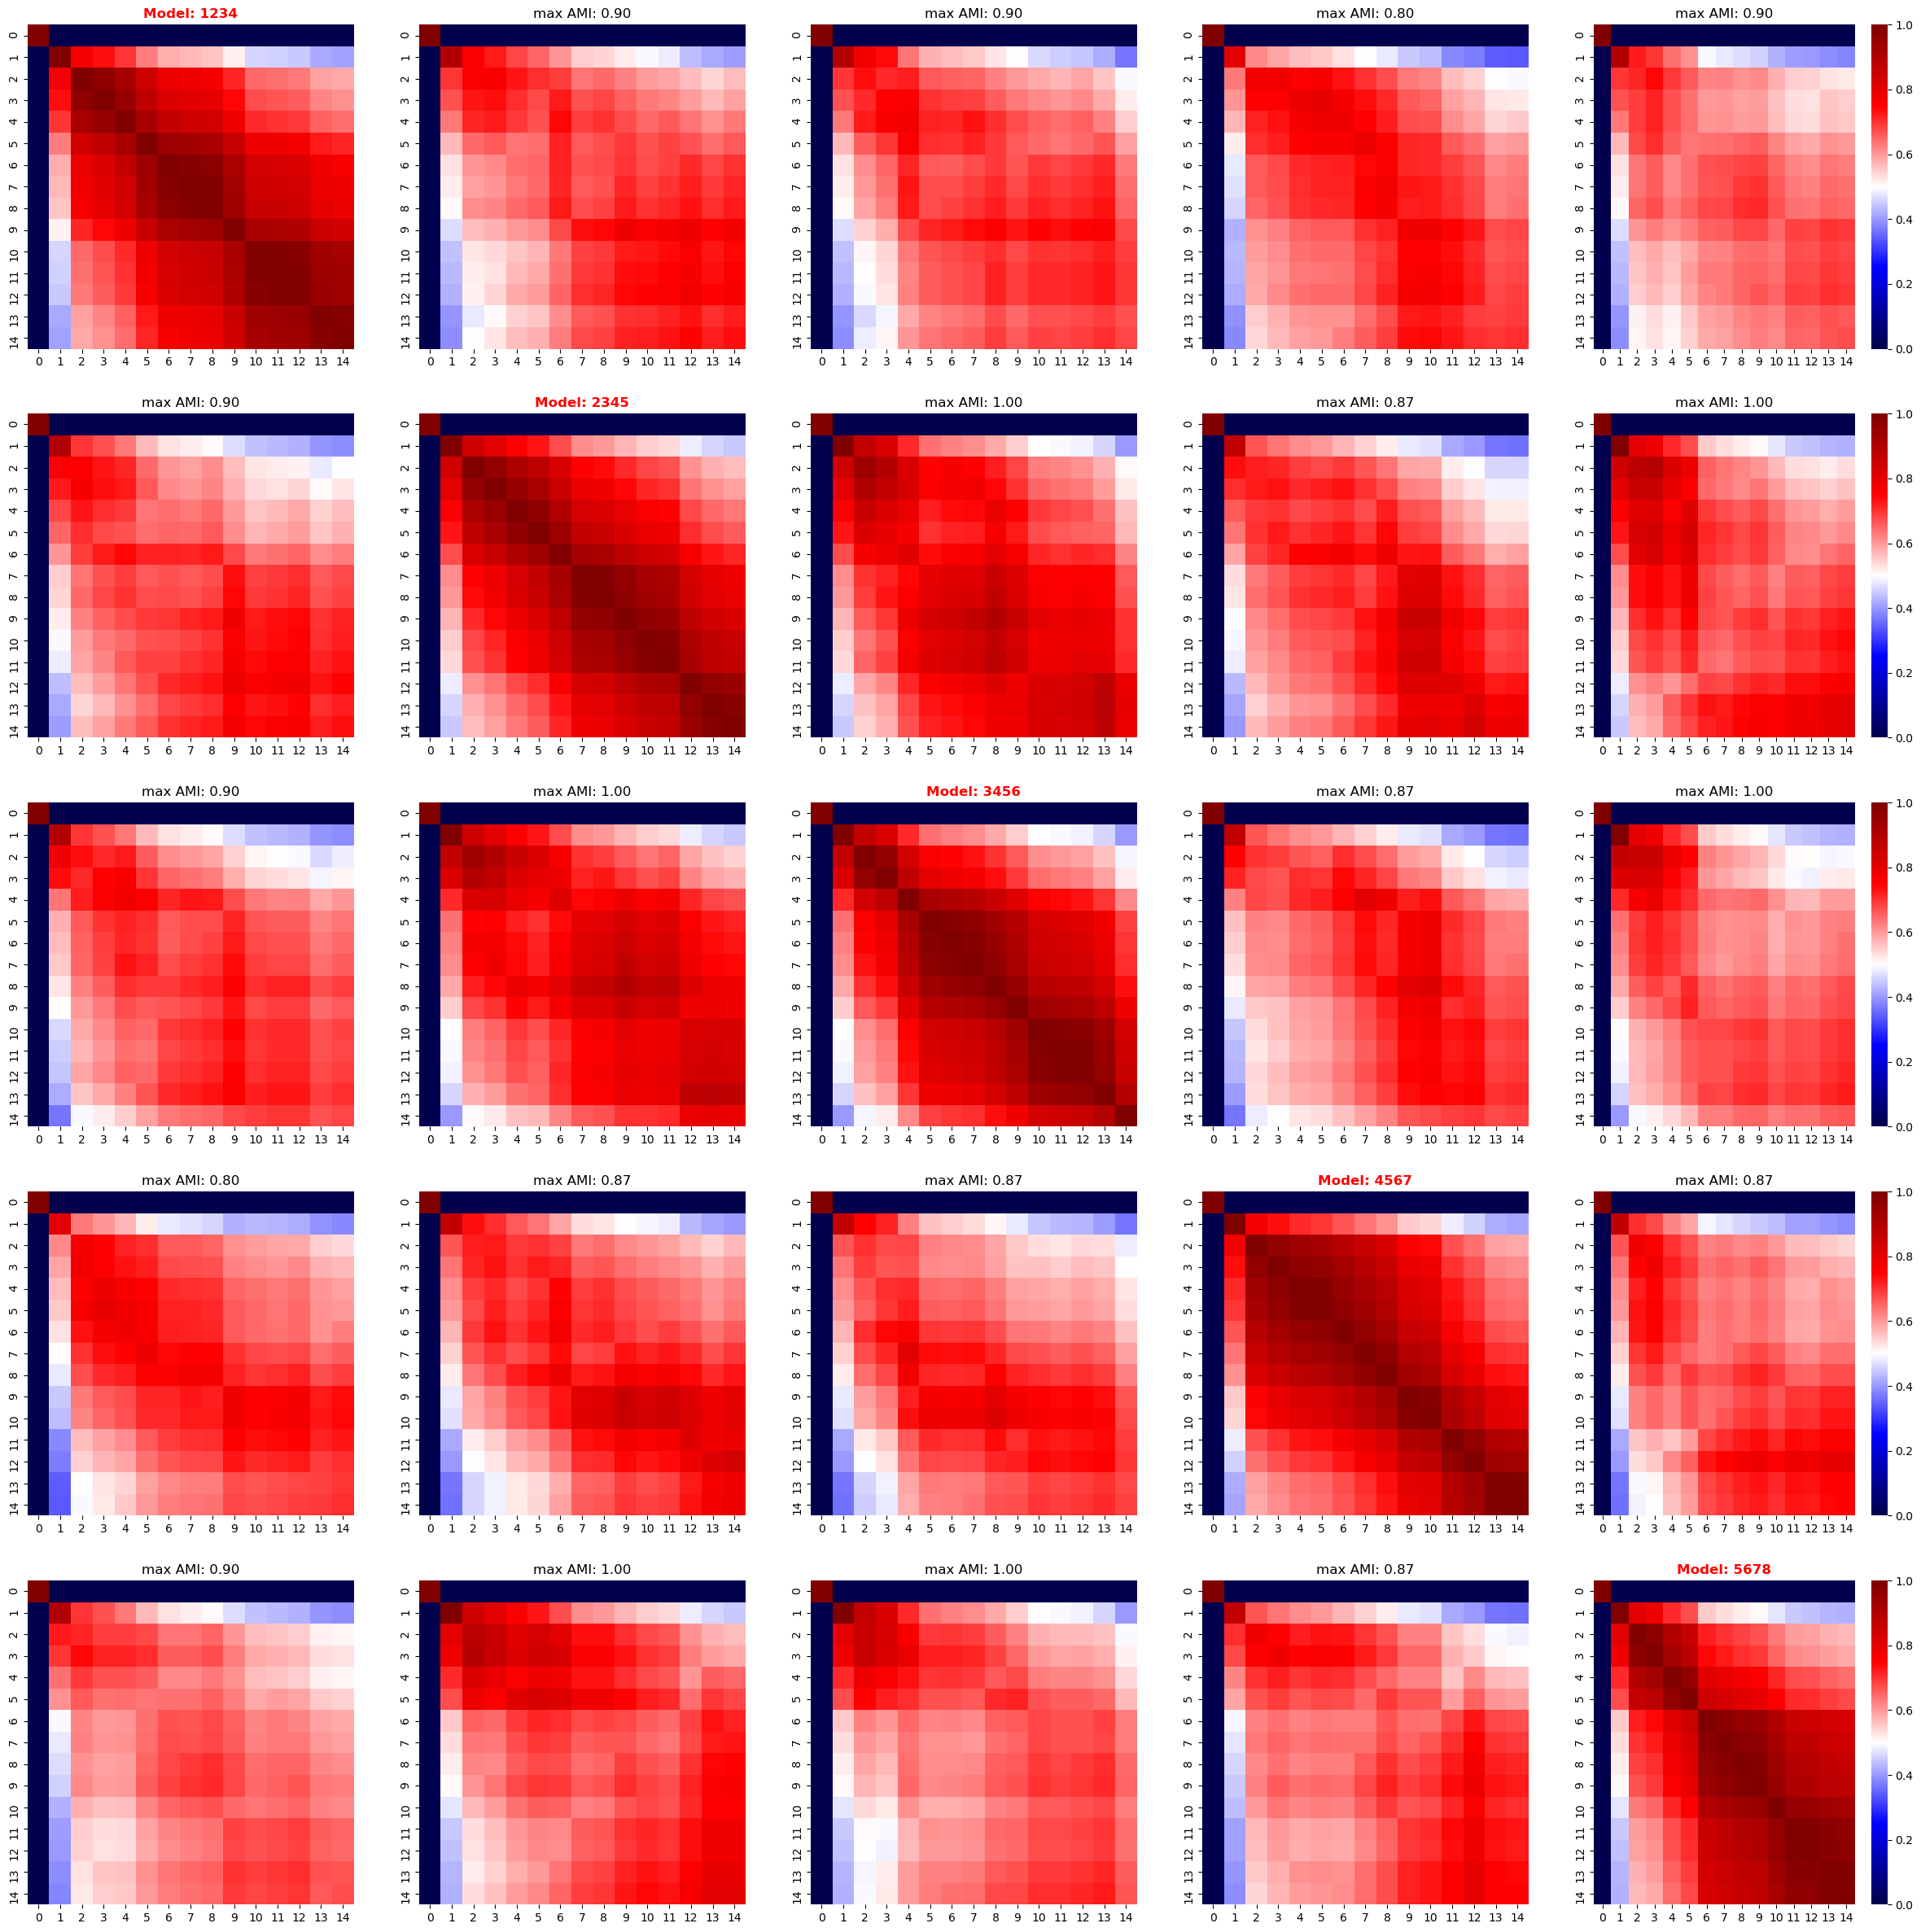

Latent dim: 64


 52%|█████▏    | 523/1000 [00:23<00:21, 22.59it/s]


------------------------------------------------------------


 50%|█████     | 504/1000 [00:23<00:22, 21.85it/s]


------------------------------------------------------------


 81%|████████  | 808/1000 [00:41<00:09, 19.66it/s]


------------------------------------------------------------


 66%|██████▌   | 661/1000 [00:29<00:15, 22.07it/s]


------------------------------------------------------------


 37%|███▋      | 366/1000 [00:20<00:36, 17.49it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


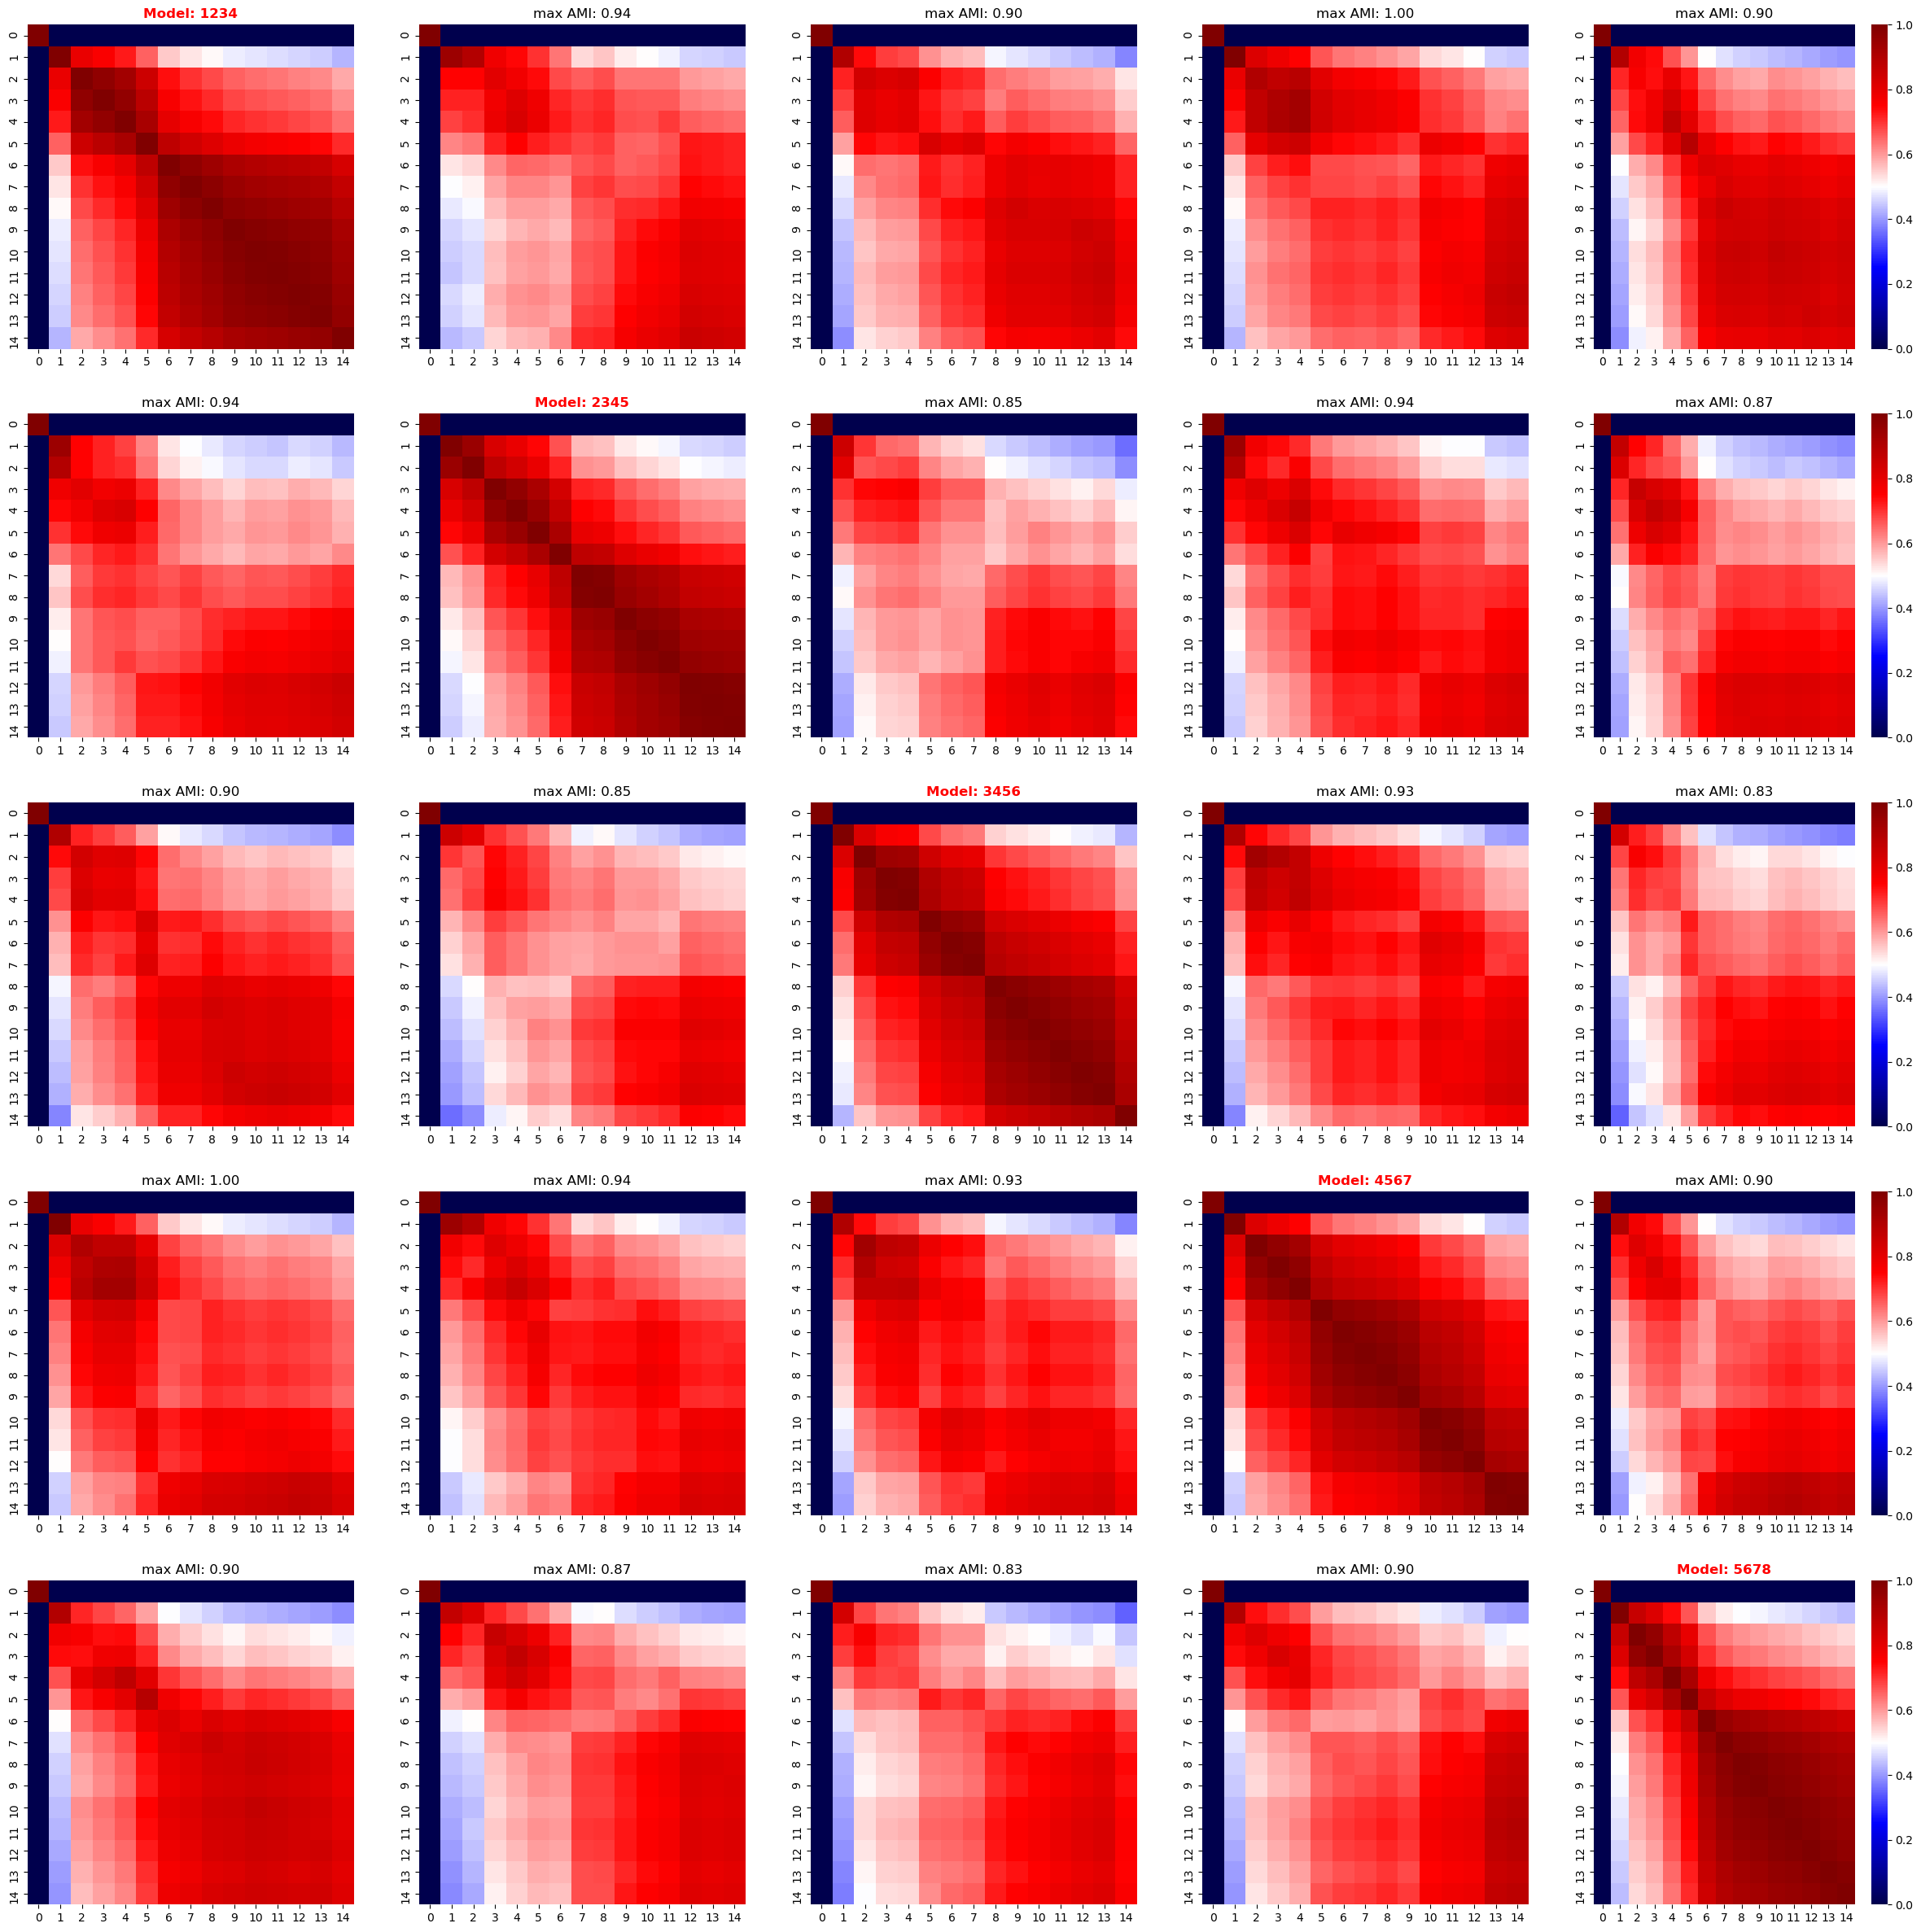

Latent dim: 128


 72%|███████▏  | 724/1000 [00:41<00:15, 17.41it/s]


------------------------------------------------------------


 83%|████████▎ | 831/1000 [00:28<00:05, 29.37it/s]


------------------------------------------------------------


100%|██████████| 1000/1000 [00:30<00:00, 32.54it/s]


------------------------------------------------------------


 43%|████▎     | 427/1000 [00:16<00:21, 26.61it/s]


------------------------------------------------------------


 41%|████      | 407/1000 [00:12<00:18, 31.80it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


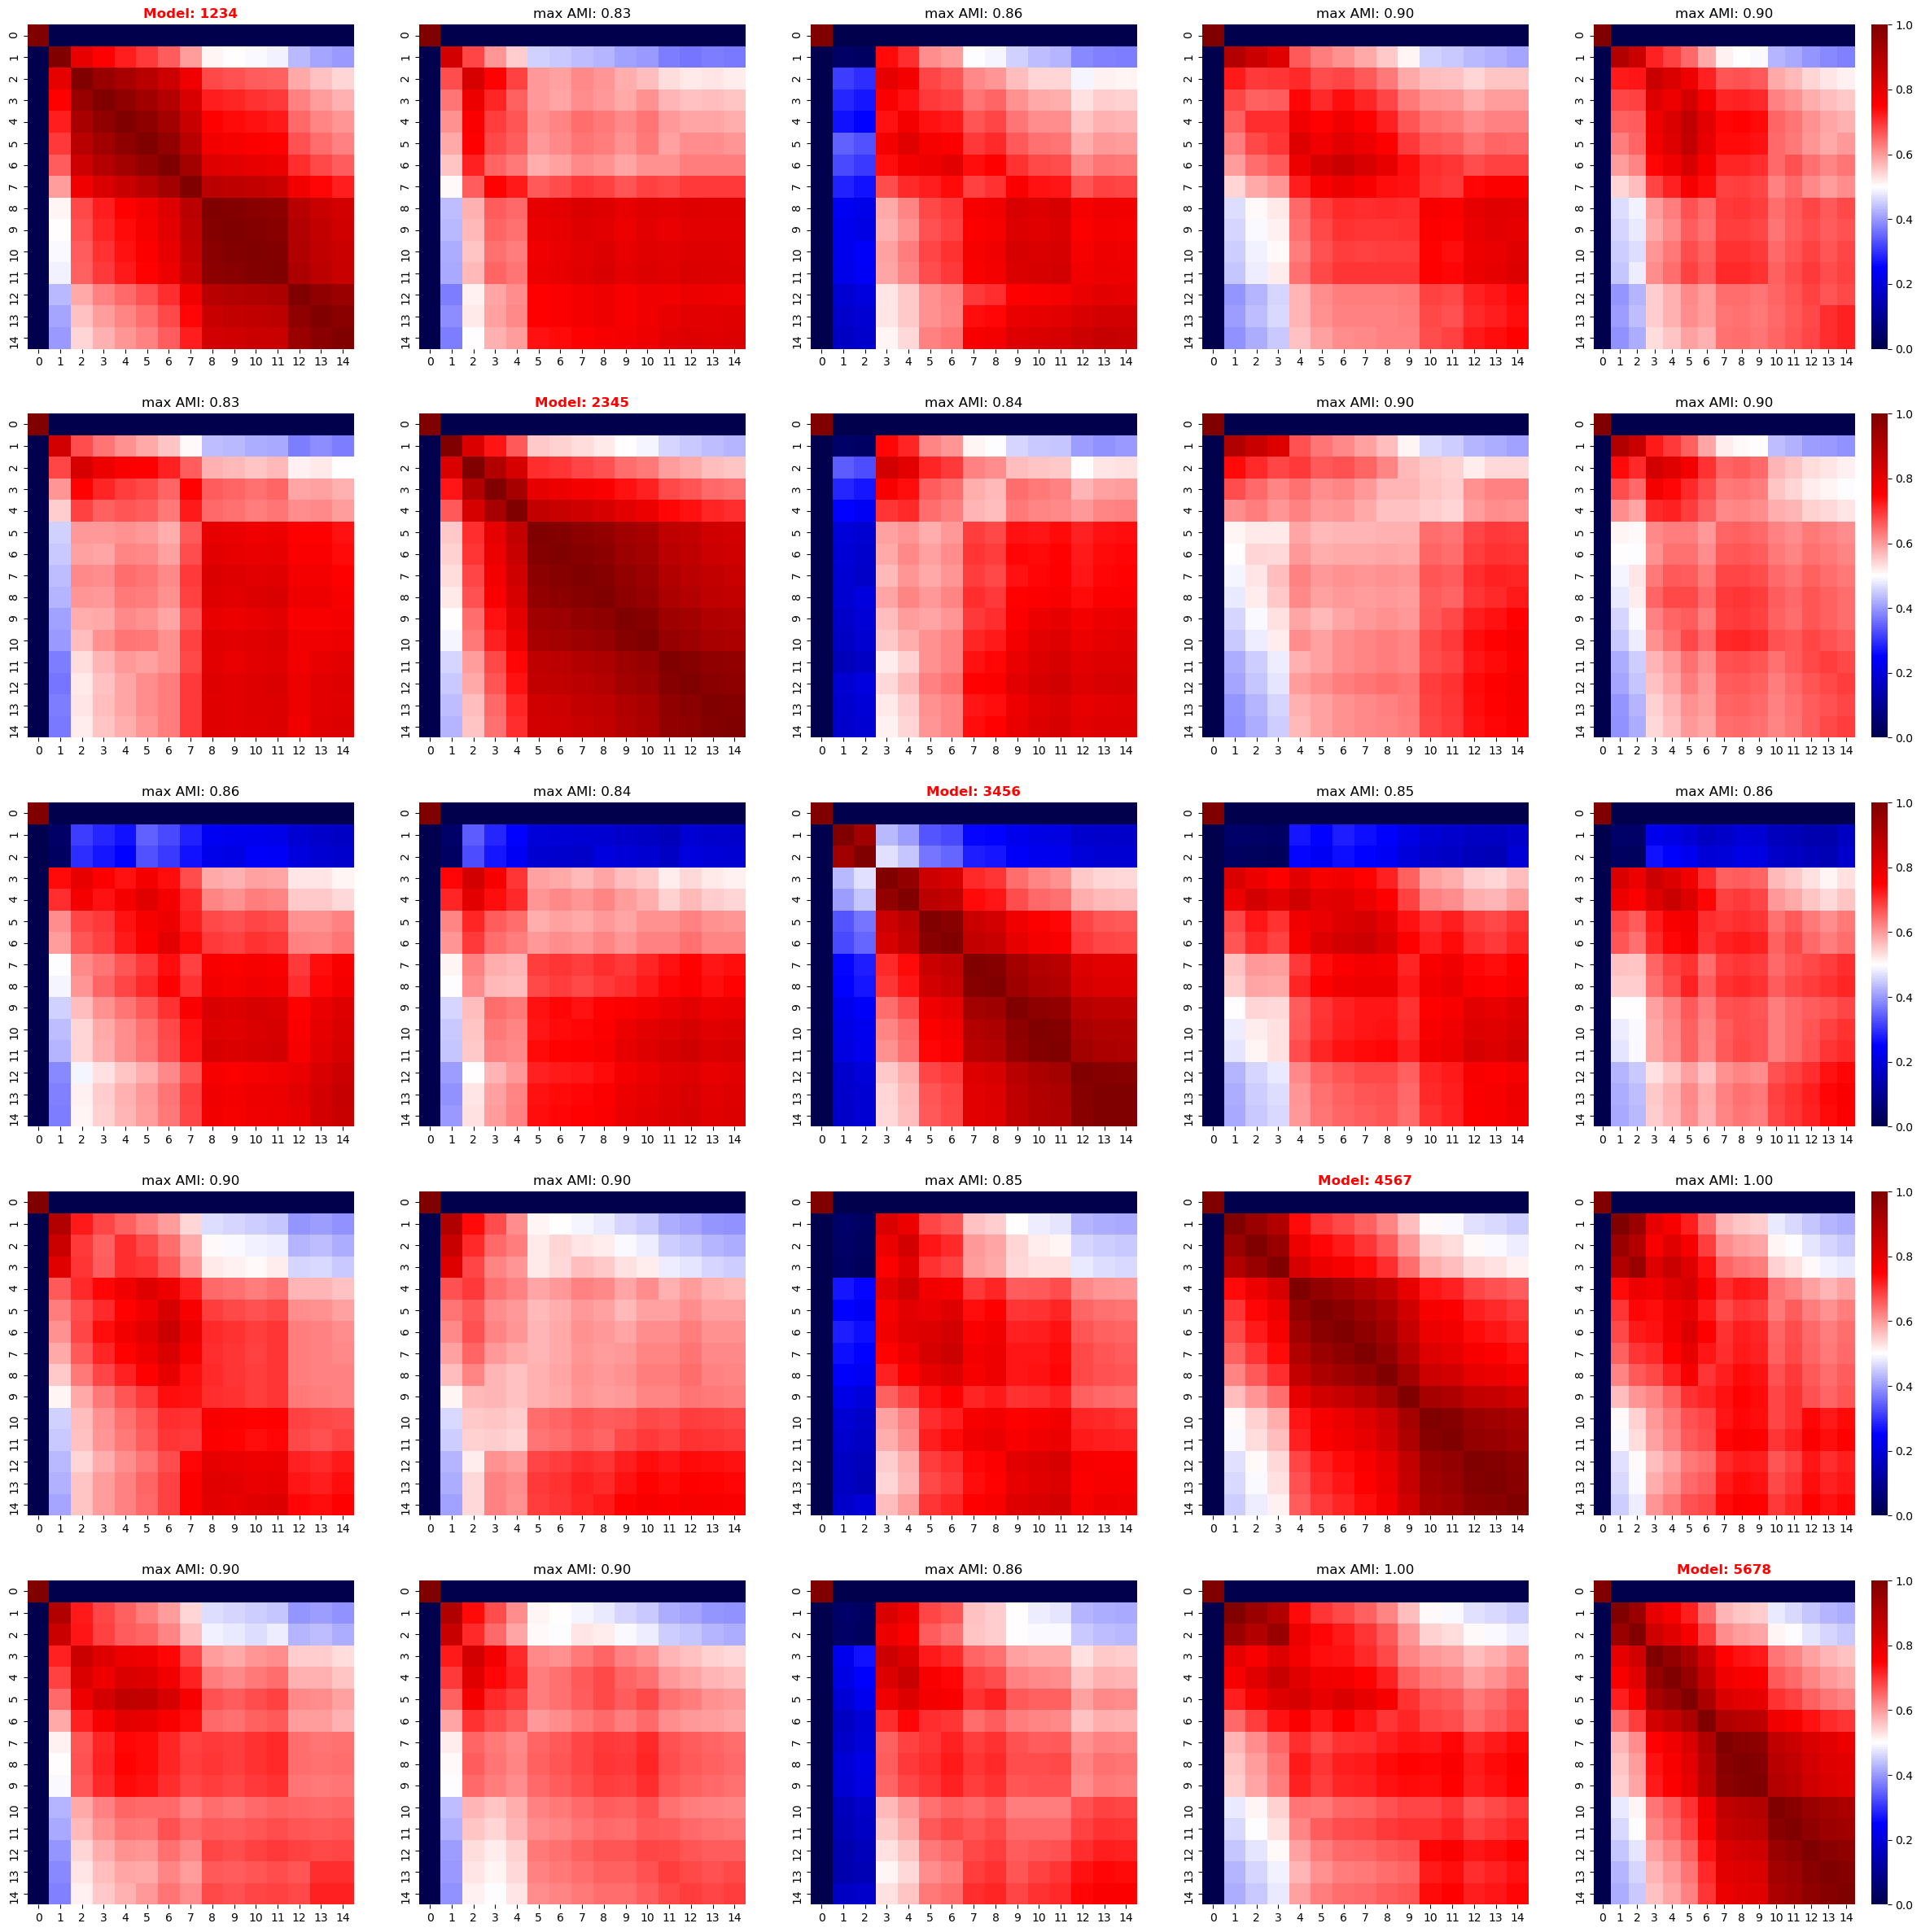

<IPython.core.display.Javascript object>

In [14]:
node_feature_key = "sc_gex_hallmark"

for latent_dim in latent_dims:
    print("Latent dim: {}".format(latent_dim))
    latents_dict_hallgexgae_feat = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=1176,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        lr=0.00005,
        link_pred=False,
        reconstruct_features=True,
        feature_decoder_params={
            "latent_dim": latent_dim,
            "output_dim": 1176,
            "hidden_dims": [128, 256, 512],
        },
        feat_loss=torch.nn.MSELoss(),
        alpha=1,
        beta=1,
        plot_loss=False,
    )
    stability_amis_hallgexgae_feat = stability_cocluster_screen(
        latents_dict_hallgexgae_feat, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgexgae_feat)

We find that adding the reconstruction loss as an additional supervisory signal seems to improve the stability of the inferred embeddings. As for all GAE variants we see more stable solutions for the largest embedding dimension considered in the study 128.

---

##### Hallmark-GEX-GAE ( only feature reconstruction)

The final setup is training the same model as above but only on the task of feature reconstruction, i.e. assigning zero-loss for the reconstruction of the adjacency matrix.

Latent dim: 32


 58%|█████▊    | 579/1000 [00:24<00:17, 24.05it/s]


------------------------------------------------------------


 57%|█████▋    | 569/1000 [00:24<00:18, 23.38it/s]


------------------------------------------------------------


 64%|██████▍   | 645/1000 [00:27<00:15, 23.66it/s]


------------------------------------------------------------


 50%|████▉     | 495/1000 [00:18<00:18, 26.72it/s]


------------------------------------------------------------


 73%|███████▎  | 733/1000 [00:33<00:12, 21.65it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


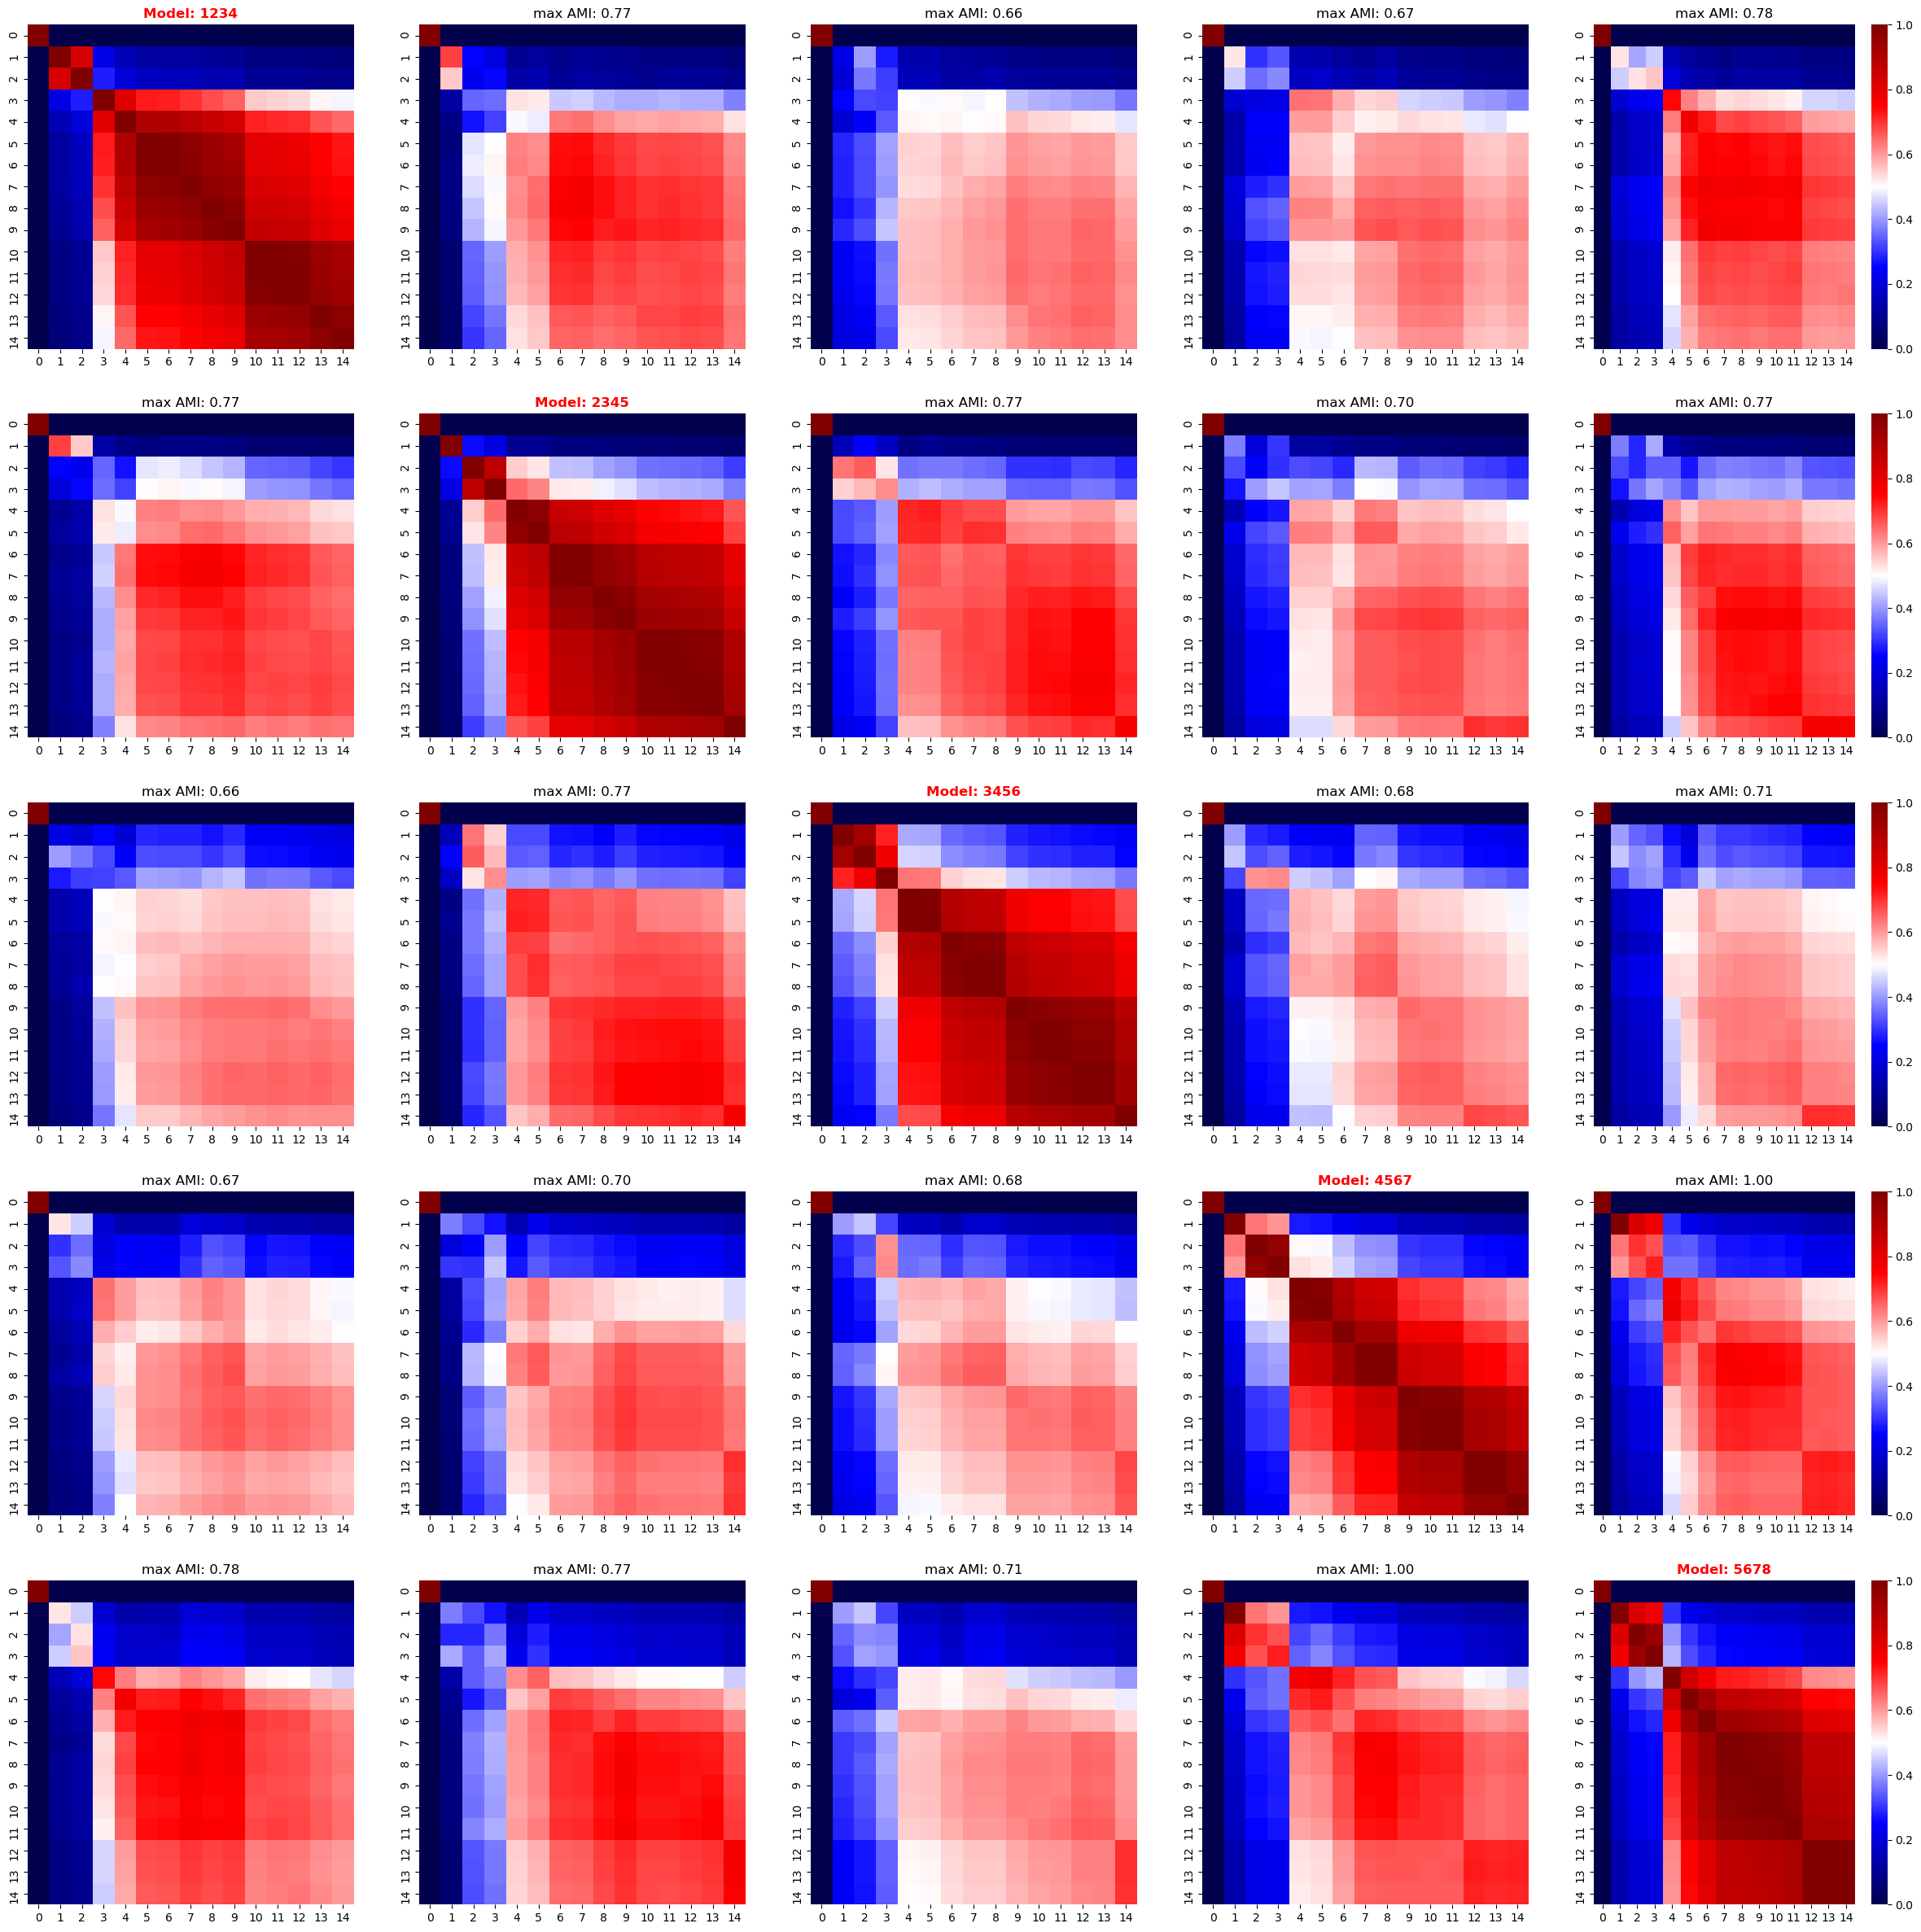

Latent dim: 64


 80%|████████  | 802/1000 [00:33<00:08, 23.76it/s]


------------------------------------------------------------


 66%|██████▌   | 656/1000 [00:26<00:13, 25.08it/s]


------------------------------------------------------------


 65%|██████▌   | 653/1000 [00:26<00:13, 25.10it/s]


------------------------------------------------------------


 47%|████▋     | 472/1000 [00:21<00:24, 21.73it/s]


------------------------------------------------------------


 65%|██████▌   | 651/1000 [00:26<00:14, 24.88it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


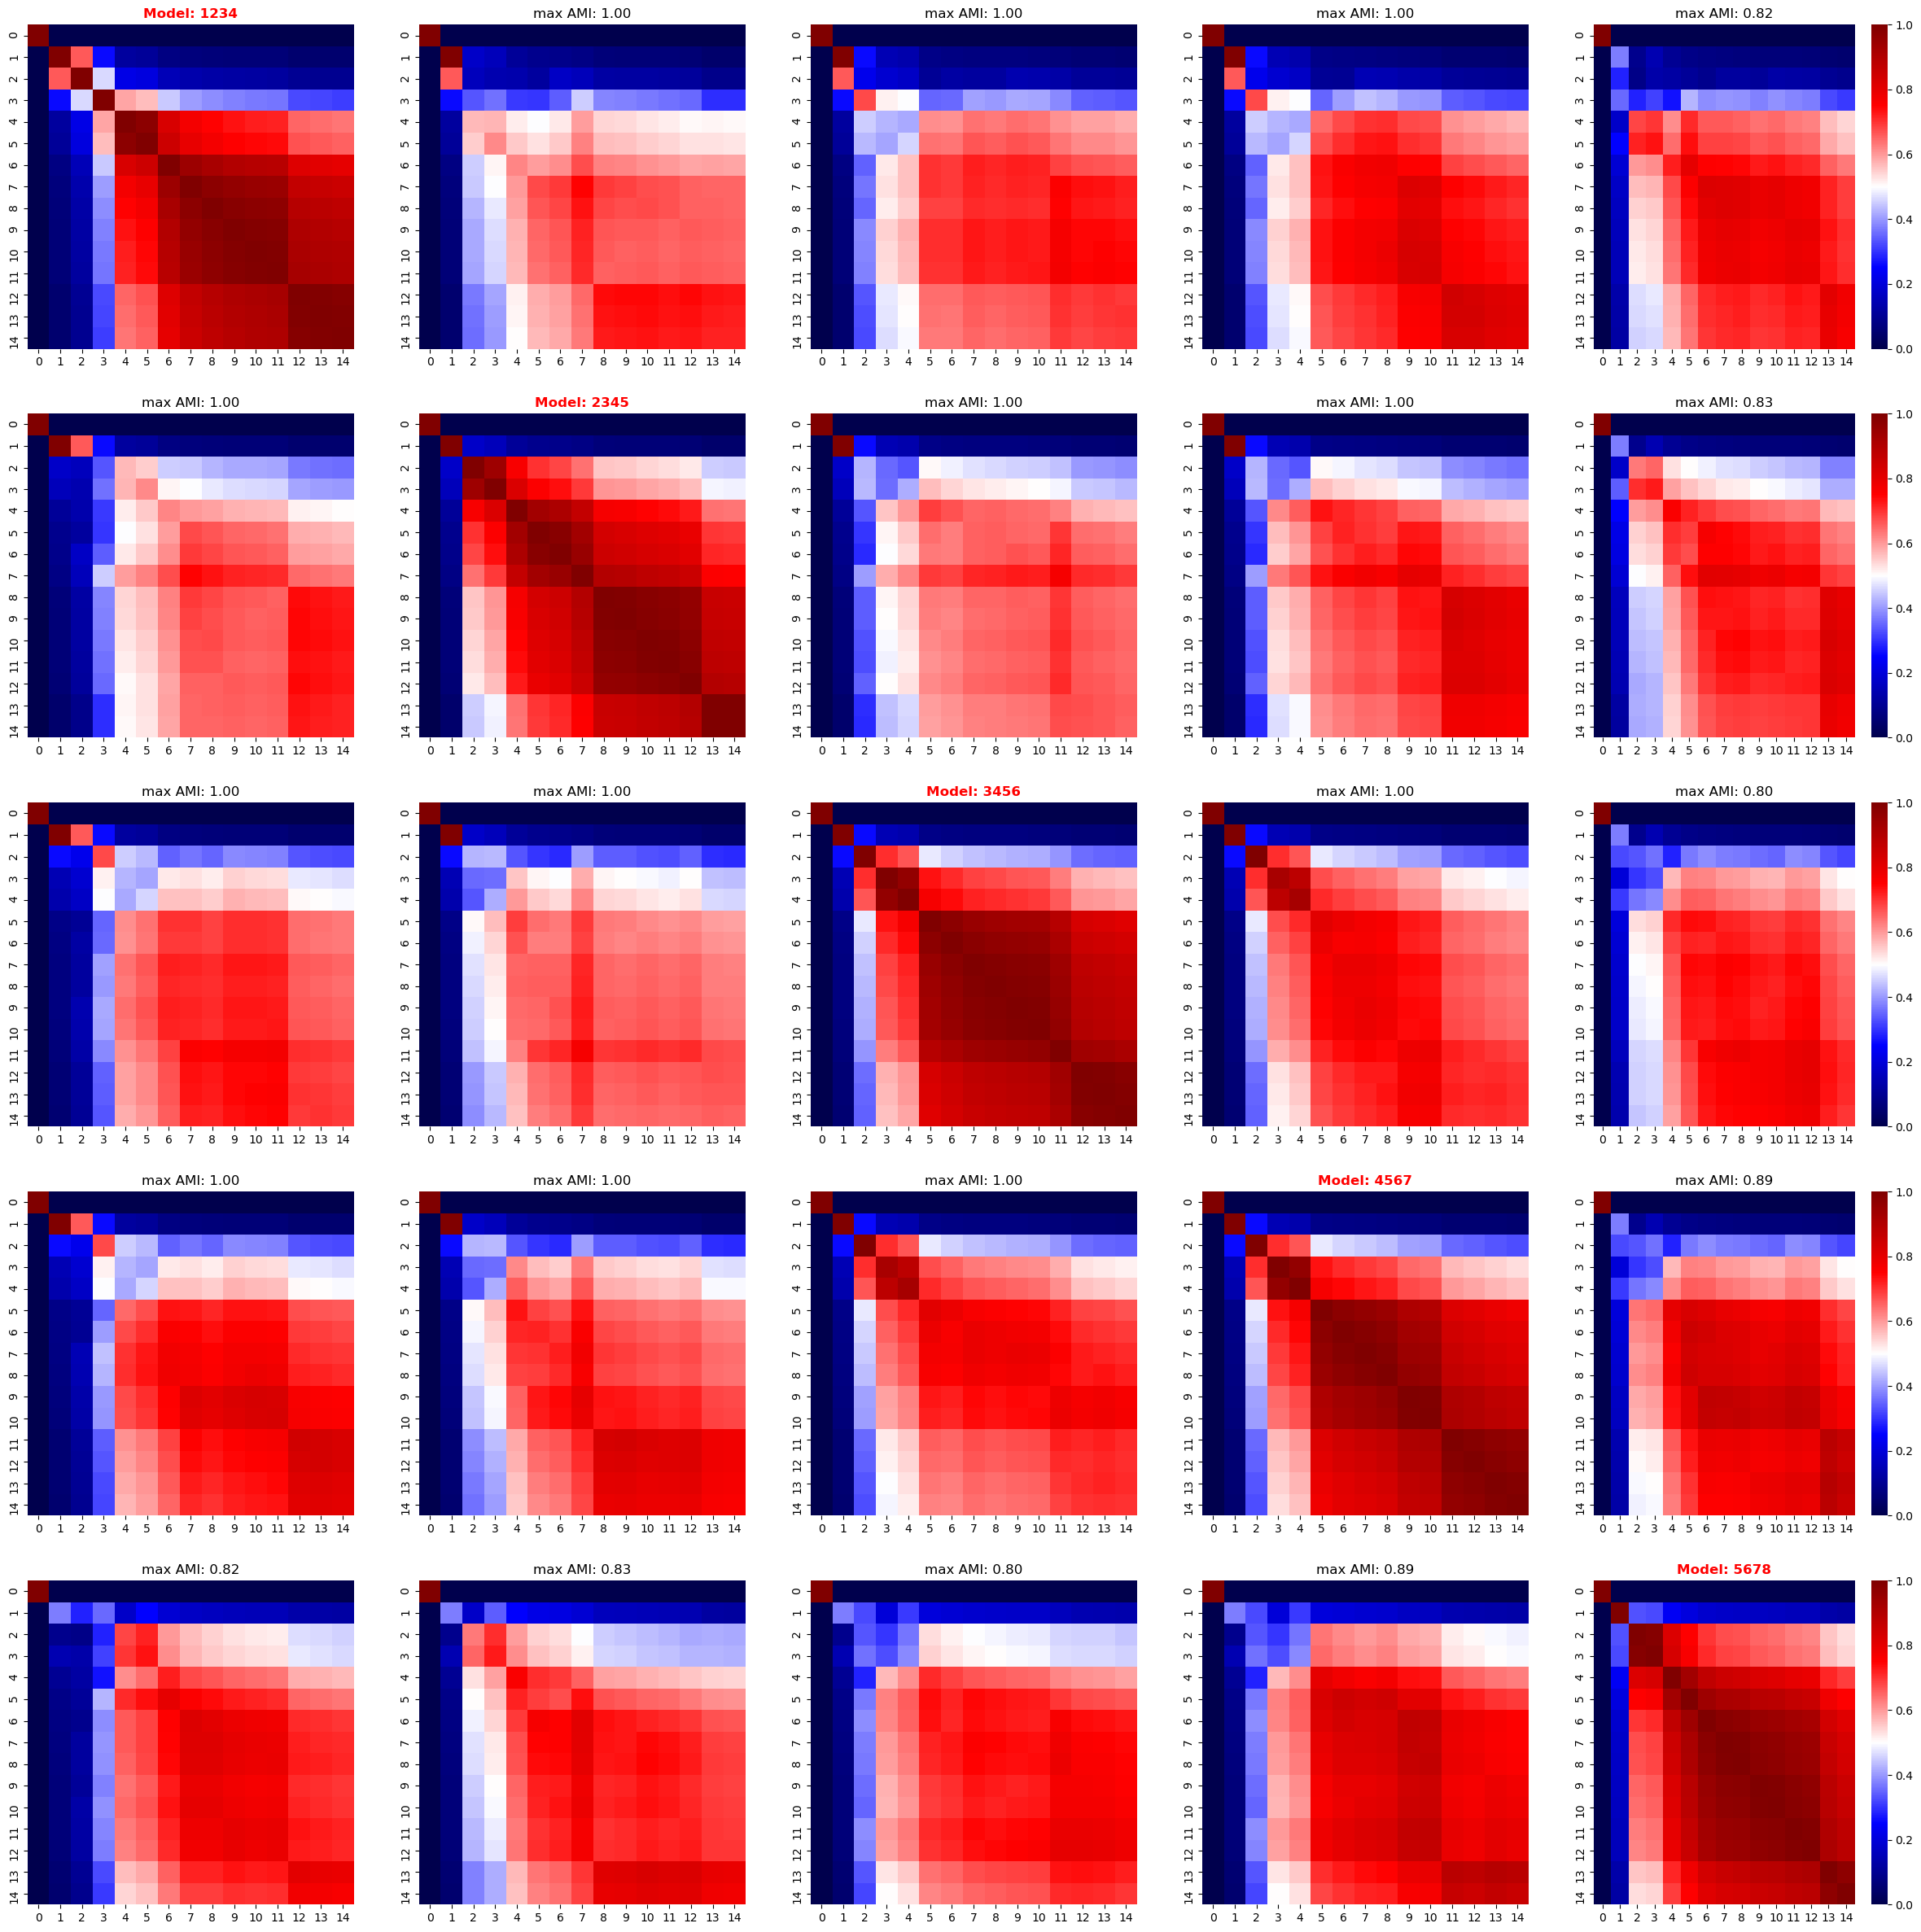

Latent dim: 128


 64%|██████▎   | 637/1000 [00:26<00:14, 24.47it/s]


------------------------------------------------------------


 74%|███████▍  | 743/1000 [00:31<00:10, 23.60it/s]


------------------------------------------------------------


 48%|████▊     | 484/1000 [00:19<00:20, 25.22it/s]


------------------------------------------------------------


 49%|████▉     | 489/1000 [00:22<00:23, 21.68it/s]


------------------------------------------------------------


 65%|██████▌   | 652/1000 [00:26<00:14, 24.26it/s]


------------------------------------------------------------


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


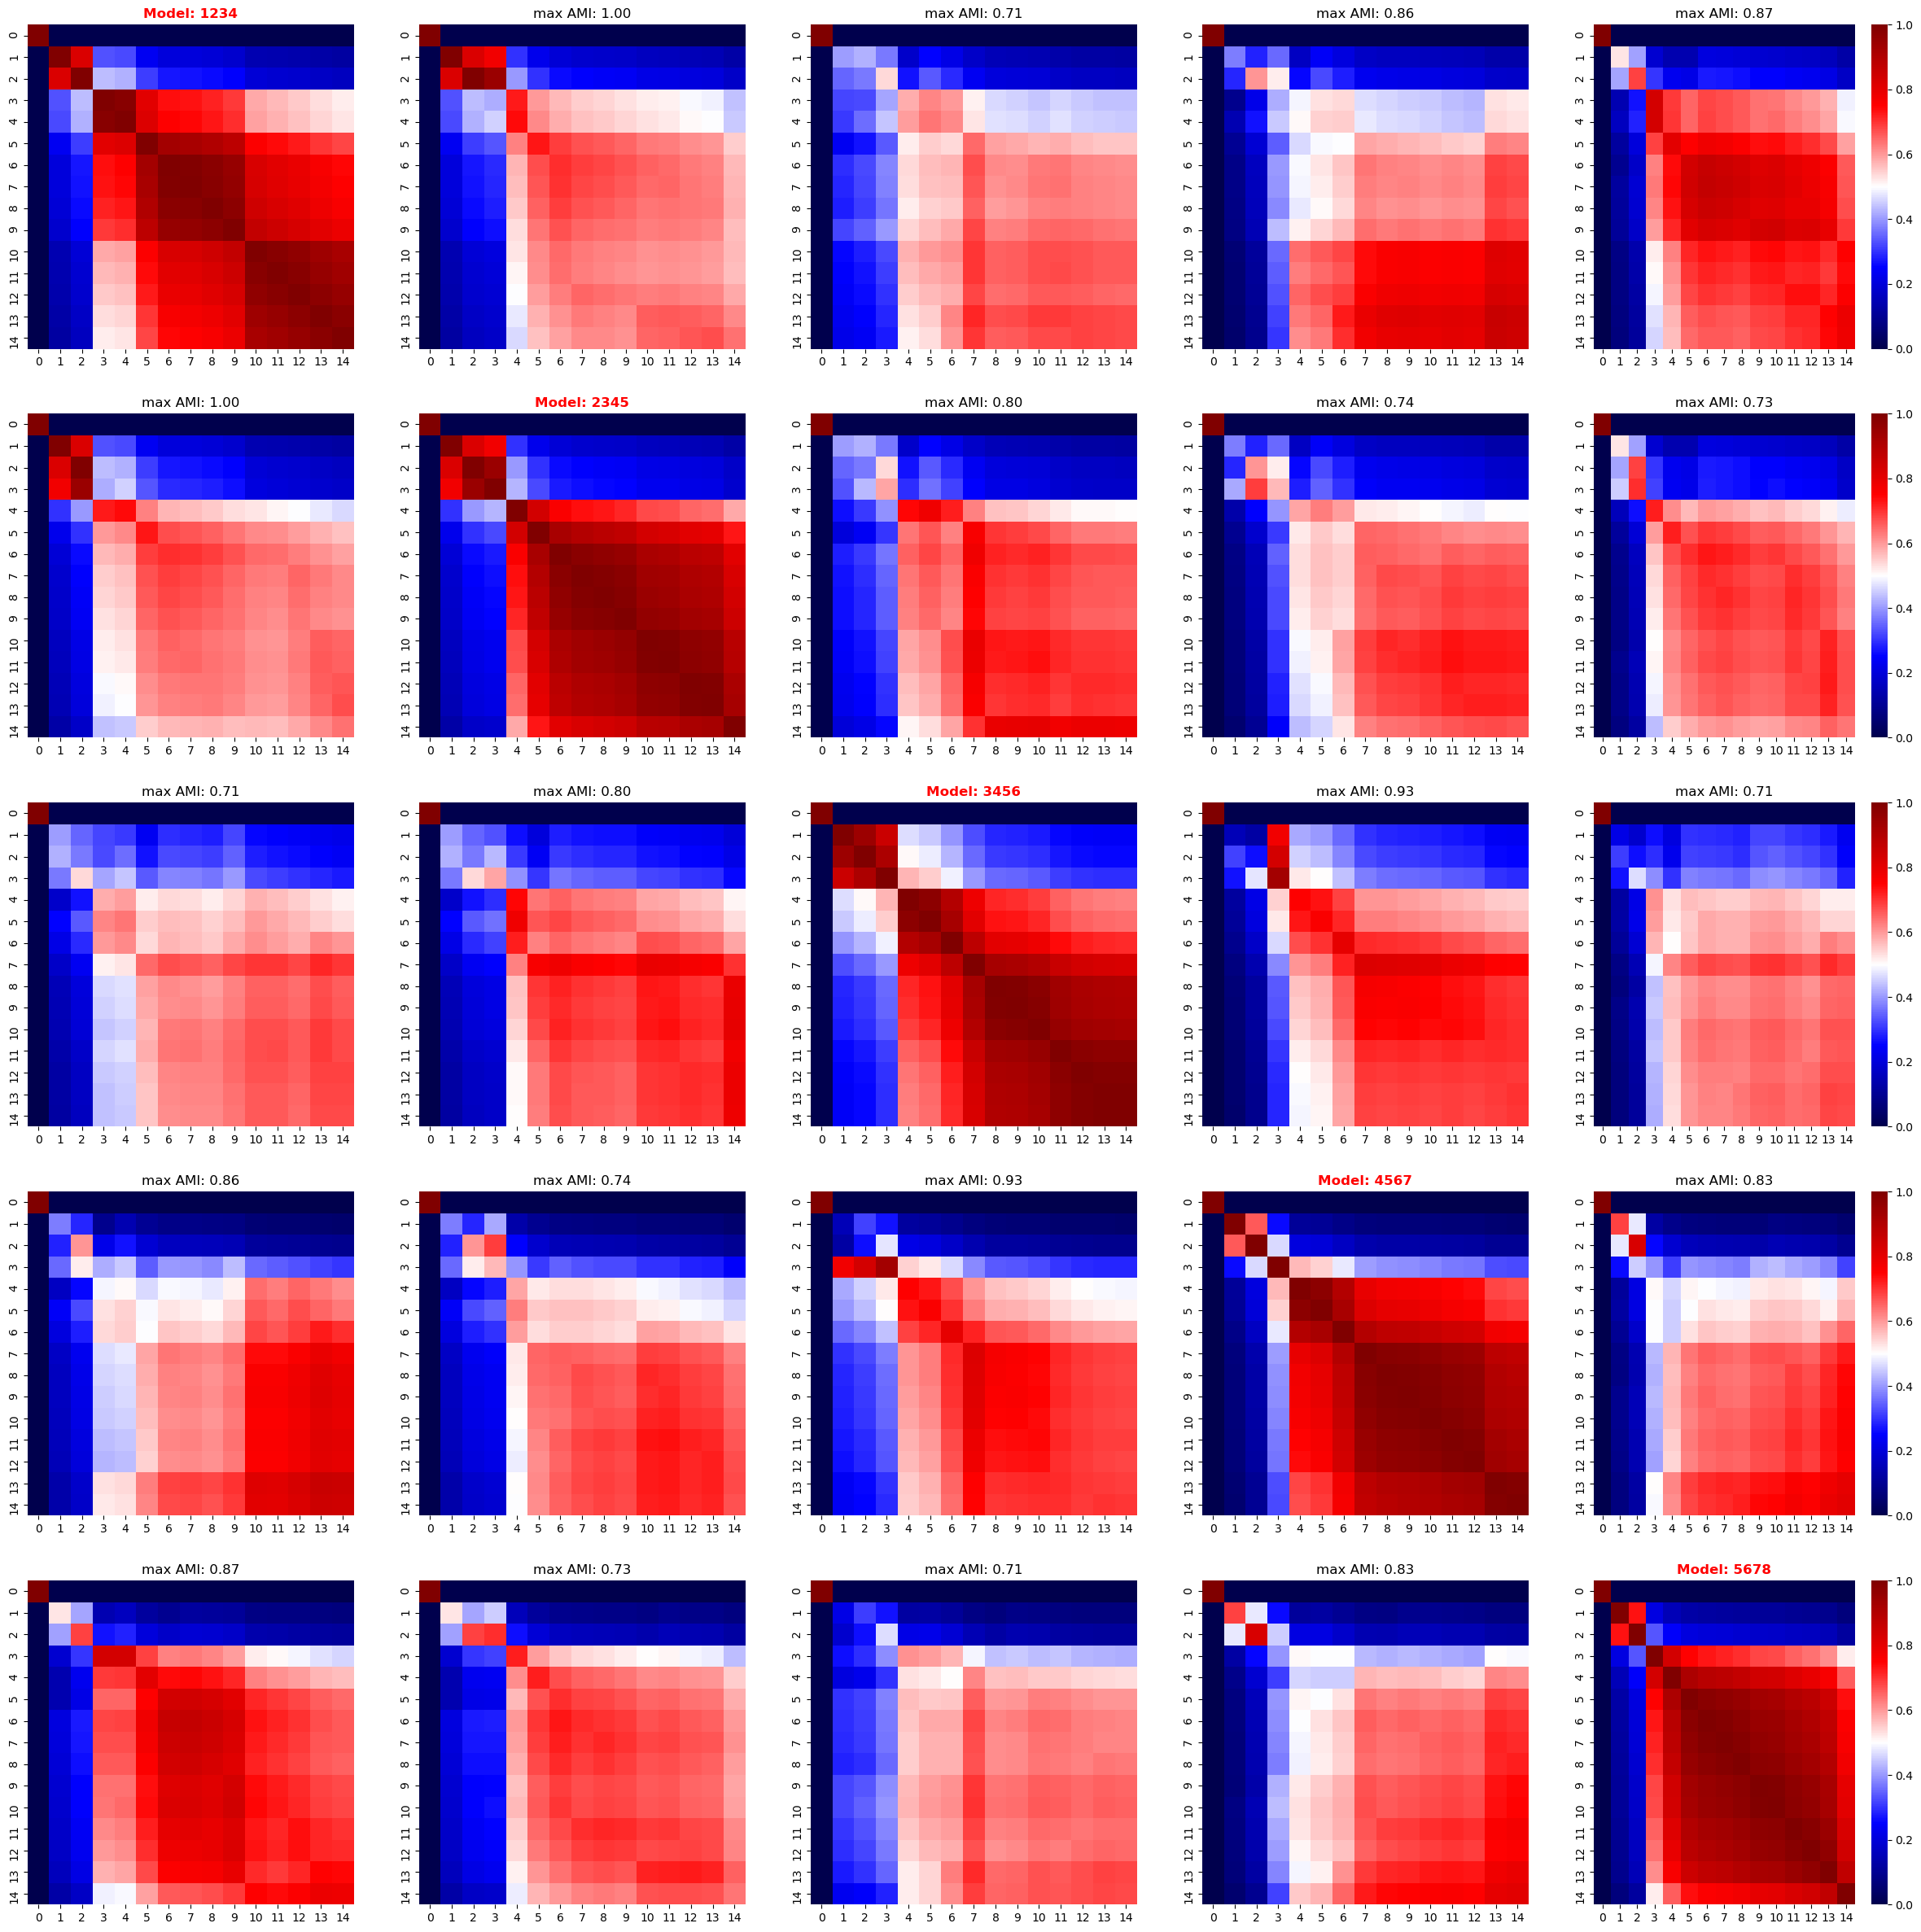

<IPython.core.display.Javascript object>

In [15]:
node_feature_key = "sc_gex_hallmark"

for latent_dim in latent_dims:
    print("Latent dim: {}".format(latent_dim))
    latents_dict_hallgexgae_feat_only = get_gae_latents_for_seed(
        graph_data=graph_data,
        seeds=seeds,
        node_feature_key=node_feature_key,
        input_dim=1176,
        latent_dim=latent_dim,
        hidden_dim=128,
        n_epochs=1000,
        lr=0.0005,
        link_pred=False,
        reconstruct_features=True,
        feature_decoder_params={
            "latent_dim": latent_dim,
            "output_dim": 1176,
            "hidden_dims": [128, 256, 512, 1024],
        },
        feat_loss=torch.nn.MSELoss(),
        alpha=0,
        beta=1,
        plot_loss=False,
    )
    stability_amis_hallgexgae_feat_only = stability_cocluster_screen(
        latents_dict_hallgexgae_feat_only, linkage="average", affinity="euclidean"
    )
    plot_amis_matrices(seeds, stability_amis_hallgexgae_feat_only)

Compared to the solution that also penalizes the mismatch of the reconstructed adjacency matrix, we see that the embeddings are more dissimilar while still highly stable in general. That is especially for a small number of clusters we often see lower adjusted mutual information scores. As we increase the dimensionality those become more stable. However at a certain point the curse of dimensionality yields to less stable cluster solutions again.

---


### 3.2. Comparison of the inferred latent spaces

We will now compare the inferred latent spaces from the different model setups introduced in the previous section. To this end, we will again assess the co-clustering of the respective models. However, this time we will only consider one random initialization for each model. We will use 128 latent dimensions for the GAE models and 32 latent dimensions for the Node2Vec model as we previously have seen that these provide the most stable results for the respective models. 

In [16]:
seed = 1234

# Since the last configuration was an embedding space of size 128, we can simply use the
# precomputed latents for those models
comp_latents_dict = {
    "gae_id": latents_dict_topogae[seed],
    "gae_hallmark": latents_dict_hallgae[seed],
    "gae_hallgex": latents_dict_hallgexgae[seed],
    "gae_hallgex_lp": latents_dict_hallgexgae_lp[seed],
    "gae_hallgex_feat": latents_dict_hallgexgae_feat[seed],
    "gae_hallgex_feat_only": latents_dict_hallgexgae_feat_only[seed],
}

# We quickly recompute the corresponding embeddings for the Node2Vec model
latents_dict_n2v = get_n2v_latents_for_seed(
    graph_data,
    [seed],
    latent_dim=32,
    walk_length=50,
    context_size=5,
    walks_per_node=20,
    batch_size=4,
    num_workers=4,
    lr=0.01,
    n_epochs=100,
    plot_loss=False,
)
comp_latents_dict["n2v"] = latents_dict_n2v[seed]

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

Final loss: 0.9565745039684016


<IPython.core.display.Javascript object>

100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


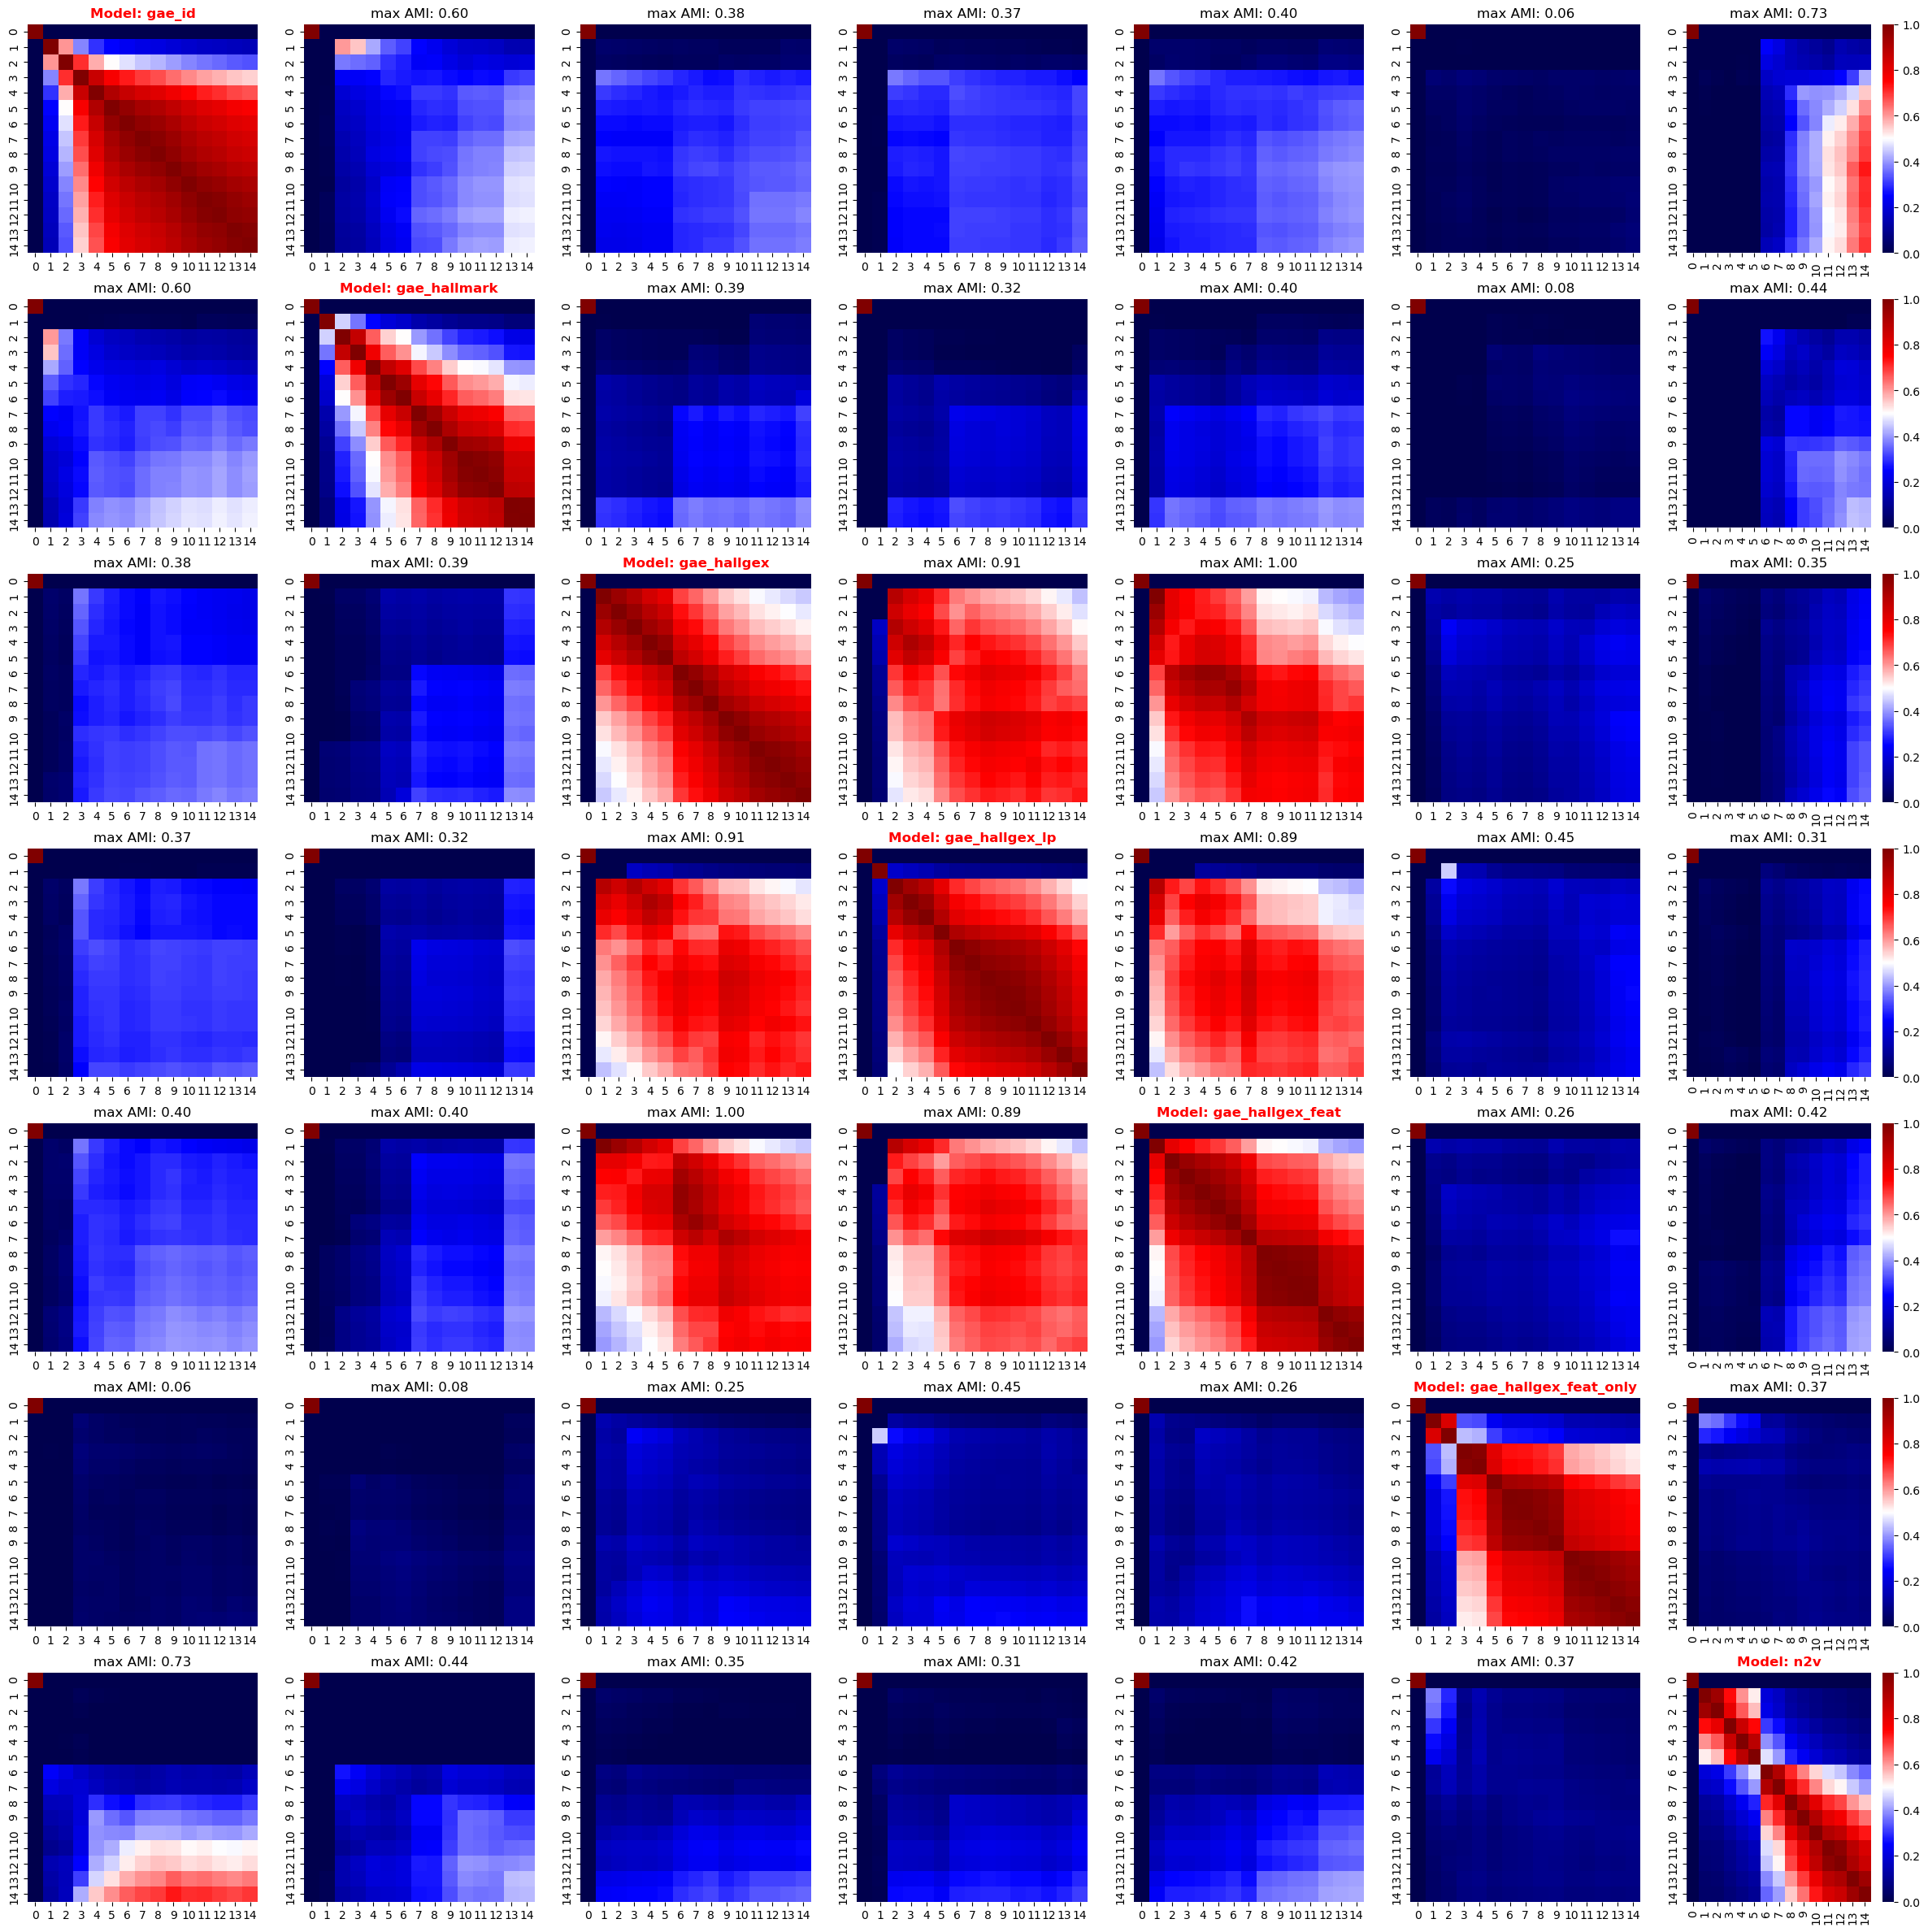

<IPython.core.display.Javascript object>

In [17]:
stability_amis_comparison = stability_cocluster_screen(
    comp_latents_dict, linkage="average", affinity="euclidean"
)
plot_amis_matrices(list(comp_latents_dict.keys()), stability_amis_comparison)

The plot above suggests that only the models that use the sc-RNAseq data as input features yield comparable latent spaces. The other modelsshow only limited co-clustering especially for a low-number of clusters. Thus, we suggest to use the embeddings obtained from the GAE using the Hallmark geneset membership and the single-cell gene expression data as input trained without a data split but on the task of the reconstruction of both the feature matrix and the adjacency matrix. Note that this solution also yielded us the most stable embeddings as seen in the previous analyses.

---

### 3.3. Analyses of the inferred node embeddings

As discussed earlier, we will select the embeddings obtained from the previously described model as the final embeddings of the nodes in our network. We now will visualize and analyze the node embeddings with respect to their clustering to validate that e.g. genes which are known to function together co-cluster in the embedding space.

#### Visualization of the inferred latent space

In [154]:
latents = comp_latents_dict["gae_hallgex_feat"]

NameError: name 'comp_latents_dict' is not defined

<IPython.core.display.Javascript object>

In [19]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [20]:
latents = pd.DataFrame(latents, index=node_names)

<IPython.core.display.Javascript object>

In [76]:
embs = TSNE(random_state=1234, perplexity=13).fit_transform(latents)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

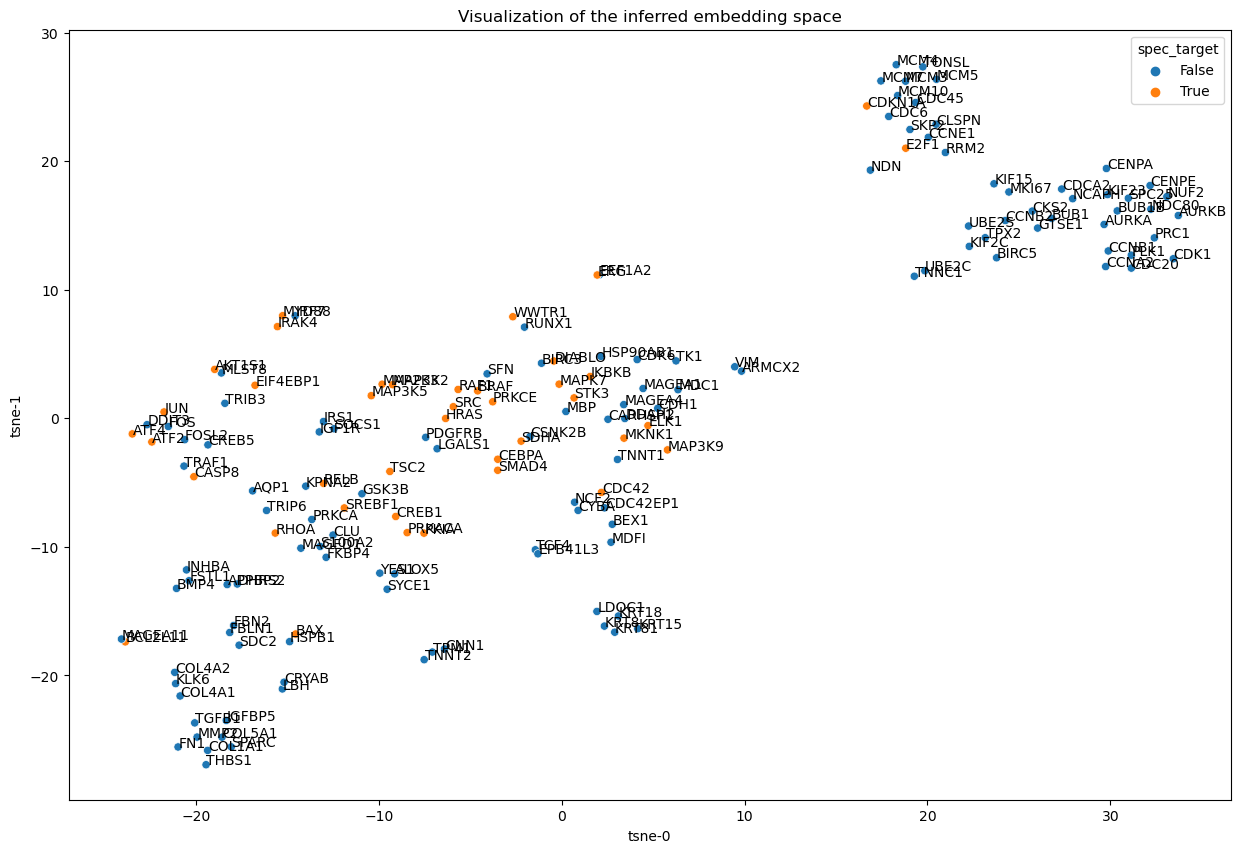

<IPython.core.display.Javascript object>

In [77]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne-0"]),
    np.array(embs.loc[:, "tsne-1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)
ax.set_title("Visualization of the inferred embedding space")
plt.show()

#### Clustering of the embedding space

We will now perform a cluster analyses using hierarchical clustering based on the euclidean distances of the individual node embeddings and average linkage.

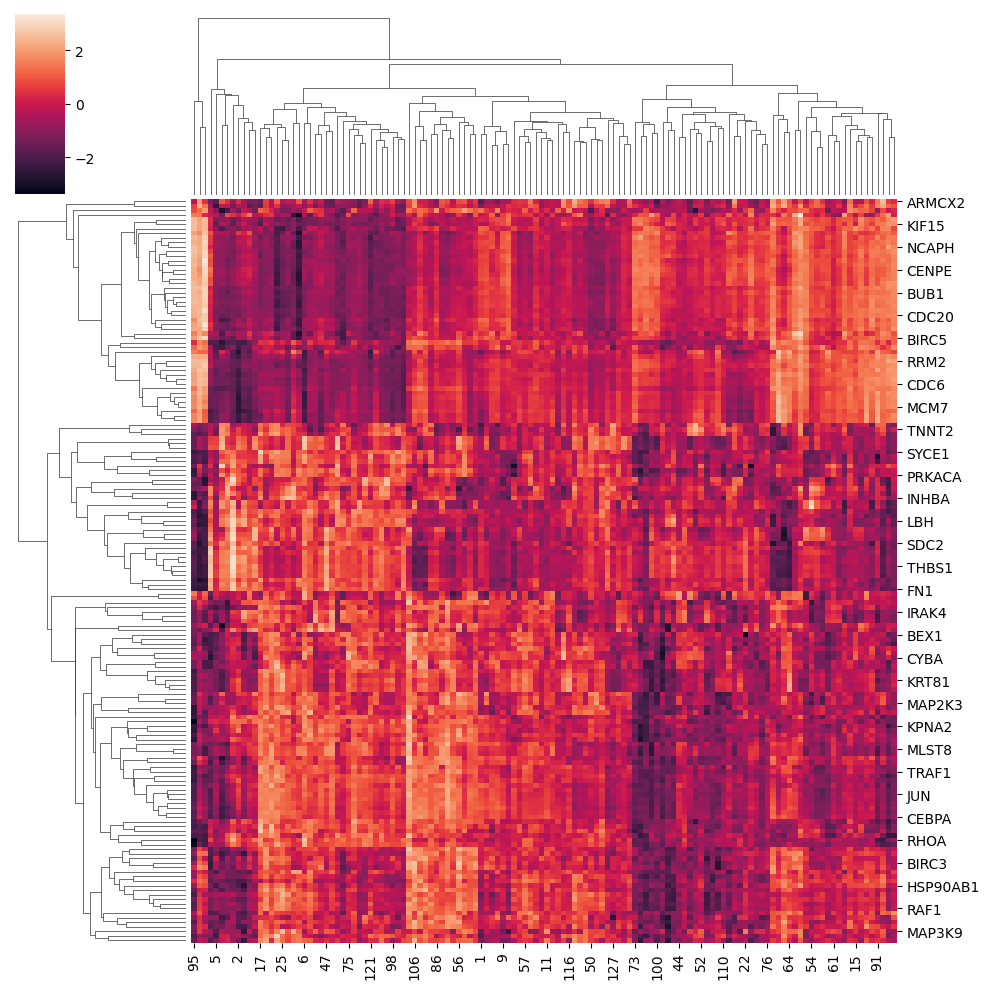

<IPython.core.display.Javascript object>

In [24]:
ax = sns.clustermap(
    latents,
    figsize=[10, 10],
    z_score=0,
    metric="euclidean",
    method="average",
)

To better understand the clustering of the latent space, we will run a agglomerative clustering analysis. To select the optimal number of clusters we look at a number of scores that have been proposed in the literature for a varying number of clusters. We set the range of clusters to 2-15 as in the previous study.

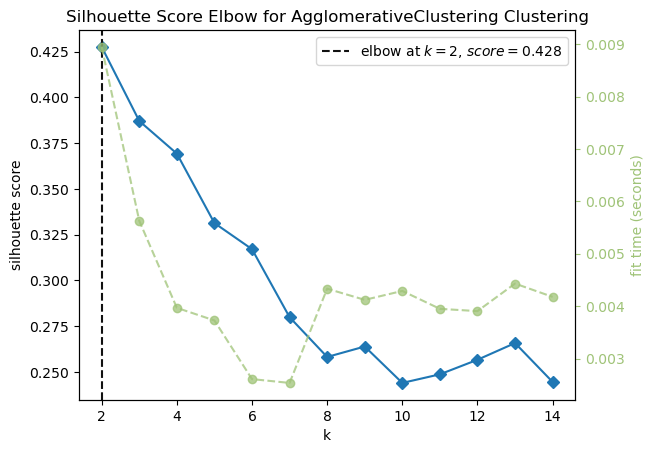

<IPython.core.display.Javascript object>

In [71]:
model = AgglomerativeClustering(linkage="average")
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="silhouette", timings=True, locate_elbow=True
)

visualizer.fit(latents)
ax = visualizer.show()

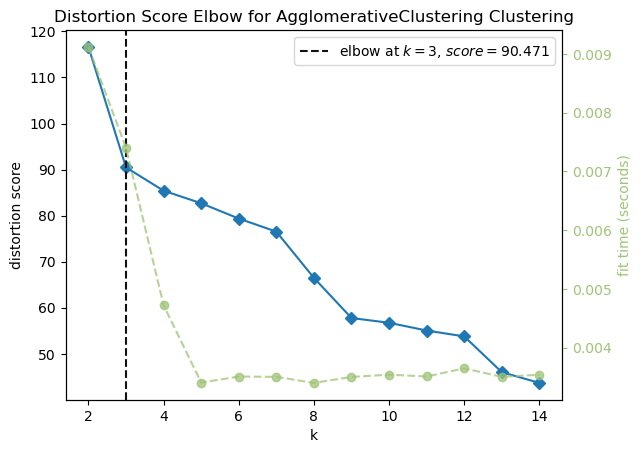

<IPython.core.display.Javascript object>

In [72]:
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="distortion", timings=True, locate_elbow=True
)

visualizer.fit(latents)
ax = visualizer.show()

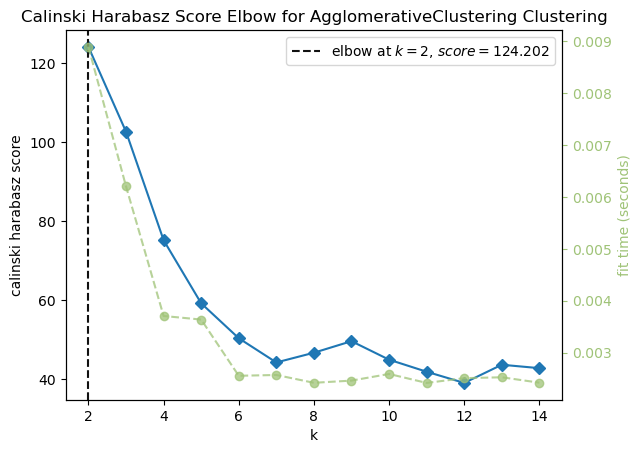

<IPython.core.display.Javascript object>

In [73]:
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="calinski_harabasz", timings=True, locate_elbow=True
)

visualizer.fit(latents)
ax = visualizer.show()

The support the impression from the previously plotted cluster map that shows to large clusters. Interestingly, the distortion score reaches its elbow at 8 clusters. We will assess these 8 clusters in more depth although these might slightly overcluster the embedding space.

In [45]:
model = AgglomerativeClustering(n_clusters=3, linkage="average")
cluster_labels = model.fit_predict(latents)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(latents.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, sorted(v)))
    print("")

Cluster 0: ['AKT1S1', 'ALOX5', 'APPBP2', 'AQP1', 'ARMCX2', 'ATF2', 'ATF4', 'BAX', 'BEX1', 'BIRC3', 'BMP4', 'BRAF', 'CARHSP1', 'CASP8', 'CDC42', 'CDC42EP1', 'CDH1', 'CDK6', 'CEBPA', 'CLU', 'CNN1', 'CREB1', 'CREB5', 'CSNK2B', 'CYBA', 'DDAH2', 'DDIT3', 'DHRS2', 'DIABLO', 'EEF1A2', 'EIF4EBP1', 'ELK1', 'EPB41L3', 'ERG', 'FBLN1', 'FBN2', 'FKBP4', 'FOS', 'FOSL2', 'FSTL1', 'GSK3B', 'HRAS', 'HSP90AB1', 'HSPB1', 'IGF1R', 'IKBKB', 'INHBA', 'IRAK4', 'IRF7', 'IRS1', 'JUN', 'KPNA2', 'KRT15', 'KRT18', 'KRT8', 'KRT81', 'LDOC1', 'LGALS1', 'MAGEA1', 'MAGEA4', 'MAGED1', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MBP', 'MDC1', 'MDFI', 'MKNK1', 'MLST8', 'MYD88', 'NCF2', 'NDN', 'PDGFRB', 'PKIA', 'PRKACA', 'PRKCA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'RUNX1', 'S100A2', 'SDC2', 'SDHA', 'SFN', 'SMAD4', 'SOCS1', 'SRC', 'SREBF1', 'STK3', 'SYCE1', 'TCF4', 'TK1', 'TNNC1', 'TNNT1', 'TNNT2', 'TPM1', 'TRAF1', 'TRIB3', 'TRIP6', 'TSC2', 'UBE2C', 'VIM', 'WWTR1', 'YES1']

Cluster 1: ['AURKA', 'AURKB', 'BIRC5', 'BUB1'

<IPython.core.display.Javascript object>

Performing a statistical over-representation test using the node set of the derived interactome as the background gene set and correcting for multiple testing using the Benjamini-Hochberg method (cut-off at 0.05), we find the following enrichment of the biological processes according to the org.Hs.eg.db in the respective clusters (shown here are the top-3 annotations when ordered by the FDR):

0. Regulation of transcription/apoptosis
    * Positive regulation of transcription by RNA polymerase II
    * Positive regulation of apoptotic process
    * Immune response-activating cell surface receptor signaling pathway
1. Cell cycle
    * Cell dividsion
    * Mitotic spindle organization
    * Negative regulation of mitotic cell cycle phase transition
2. ECM interactions
    * Extra-cellular matrix organization
    * Tissue development
    * Cellular response to organitrogen compound
    

In [46]:
cluster_label_dict = {
    0: "Regulation of transcription/apoptosis",
    1: "Cell cycle",
    2: "ECM interaction",
}

<IPython.core.display.Javascript object>

In [74]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")


embs = TSNE(random_state=1234, perplexity=13).fit_transform(latents)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()


embs["cluster"] = cluster_labels
embs["cluster"] = embs.cluster.map(cluster_label_dict)

<IPython.core.display.Javascript object>

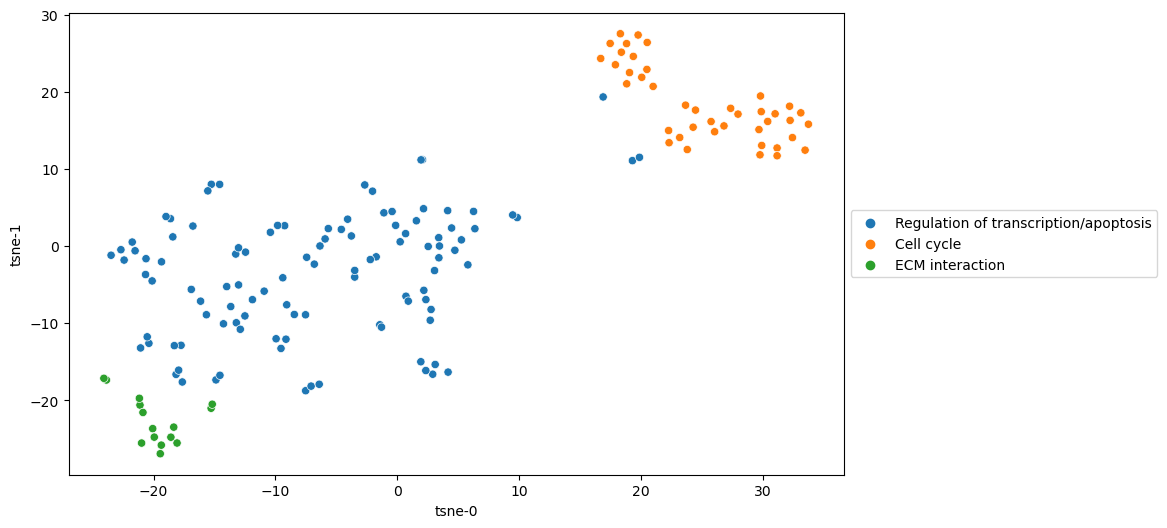

<IPython.core.display.Javascript object>

In [75]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=[10, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cluster")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

We see that the two major clusters are gene involved in cell-cycle regulation and transcriptional and apoptotic regulation.

---

### 3.4. Data export

We will now save the inferred node embeddings for later analyses.

In [33]:
latents.to_csv("../../../data/ppi/embedding/node_embeddings.csv")

<IPython.core.display.Javascript object>

---

## 4. Translational analyses

We will now look at the co-clustering of those embeddings with the ones we obtain for the imaging space.

### 4.1. Read in data

First, we read in the previously computed network embedding serving as a proxy for the regulatory space in U2OS cells as well as the respective image embeddings which we use to model the structural space of those cells. Since, we have many images corresponding to a single over-expression condition we will use their mean embeddings as a description of the structural profile in U2OS cells associated with the respective single-gene OE condition.

In [19]:
node_embs = pd.read_csv("../../../data/ppi/embedding/node_embeddings.csv", index_col=0)

<IPython.core.display.Javascript object>

In [121]:
val_latents = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specific_target_embs/resnet_ensemble_centercrops_newtargets_w_ctrl/val_latents.h5",
    index_col=0,
)
test_latents = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specific_target_embs/resnet_ensemble_centercrops_newtargets_w_ctrl/test_latents.h5",
    index_col=0,
)

label_dict = {
    "AKT1S1": 0,
    "ATF2": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CXXC4": 11,
    "DIABLO": 12,
    "E2F1": 13,
    "EIF4EBP1": 14,
    "ELK1": 15,
    "EMPTY": 16,
    "ERG": 17,
    "HRAS": 18,
    "IKBKB": 19,
    "IRAK4": 20,
    "JUN": 21,
    "MAP2K3": 22,
    "MAP3K2": 23,
    "MAP3K5": 24,
    "MAP3K9": 25,
    "MAPK7": 26,
    "MKNK1": 27,
    "MYD88": 28,
    "PKIA": 29,
    "PRKACA": 30,
    "PRKCE": 31,
    "RAF1": 32,
    "RELB": 33,
    "RHOA": 34,
    "SDHA": 35,
    "SMAD4": 36,
    "SRC": 37,
    "SREBF1": 38,
    "STK3": 39,
    "TSC2": 40,
    "WWTR1": 41,
}
label_dict = {v: k for k, v in label_dict.items()}
img_embs = val_latents.append(test_latents)
img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
img_embs = img_embs.groupby(by="labels").mean()

<IPython.core.display.Javascript object>

In [101]:
val_latents = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specific_target_embs/resnet_ensemble_centercrops_newtargets/val_latents.h5",
    index_col=0,
)
test_latents = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specific_target_embs/resnet_ensemble_centercrops_newtargets/test_latents.h5",
    index_col=0,
)

label_dict = {
    "AKT1S1": 0,
    "ATF2": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CXXC4": 11,
    "DIABLO": 12,
    "E2F1": 13,
    "EIF4EBP1": 14,
    "ELK1": 15,
    "ERG": 16,
    "HRAS": 17,
    "IKBKB": 18,
    "IRAK4": 19,
    "JUN": 20,
    "MAP2K3": 21,
    "MAP3K2": 22,
    "MAP3K5": 23,
    "MAP3K9": 24,
    "MAPK7": 25,
    "MKNK1": 26,
    "MYD88": 27,
    "PKIA": 28,
    "PRKACA": 29,
    "PRKCE": 30,
    "RAF1": 31,
    "RELB": 32,
    "RHOA": 33,
    "SDHA": 34,
    "SMAD4": 35,
    "SRC": 36,
    "SREBF1": 37,
    "STK3": 38,
    "TSC2": 39,
    "WWTR1": 40,
}
label_dict = {v: k for k, v in label_dict.items()}
img_embs = val_latents.append(test_latents)
img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
img_embs = img_embs.groupby(by="labels").mean()

<IPython.core.display.Javascript object>

---

### 4.2. Analyses of the structural space

To investigate the structural space we will run a similar analyses as in 3.3. First, we will visualize the embeddings using a tSNE plot. Second, we will run an clustering analysis to investigate the local structure of the space.

#### Visualization of the structural space

To visualize the structural space, we will plot the tSNE plot choosing a perplexitiy of 6 which is motivated by the power law for kNN, which is $perplexity \propto \sqrt(N)$.

In [122]:
struct_embs = TSNE(random_state=1234, perplexity=6).fit_transform(img_embs)
struct_embs = pd.DataFrame(
    struct_embs, columns=["tsne-0", "tsne-1"], index=img_embs.index
)

<IPython.core.display.Javascript object>

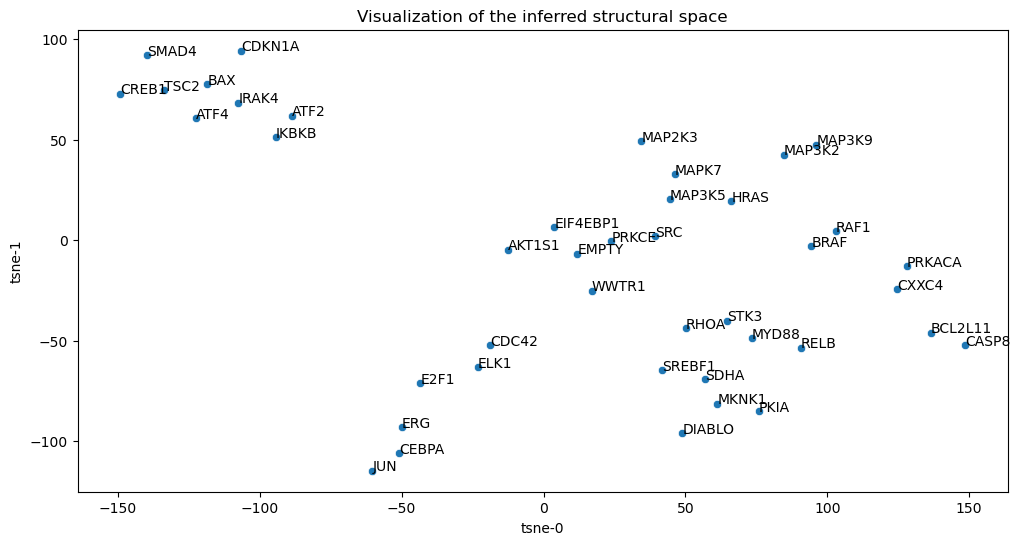

<IPython.core.display.Javascript object>

In [123]:
fig, ax = plt.subplots(figsize=[12, 6])
ax = sns.scatterplot(data=struct_embs, x="tsne-0", y="tsne-1", cmap="viridis")
label_point(
    np.array(struct_embs.loc[:, "tsne-0"]),
    np.array(struct_embs.loc[:, "tsne-1"]),
    np.array(struct_embs.index).astype("str"),
    ax=ax,
)
ax.set_title("Visualization of the inferred structural space")
plt.show()

---

#### Clustering of the structural space

To better understand the clustering of the latent space, we will again run a agglomerative clustering analysis. To select the optimal number of clusters we look at a number of scores that have been proposed in the literature for a varying number of clusters. We set the range of clusters to 2-15 as in the previous study.

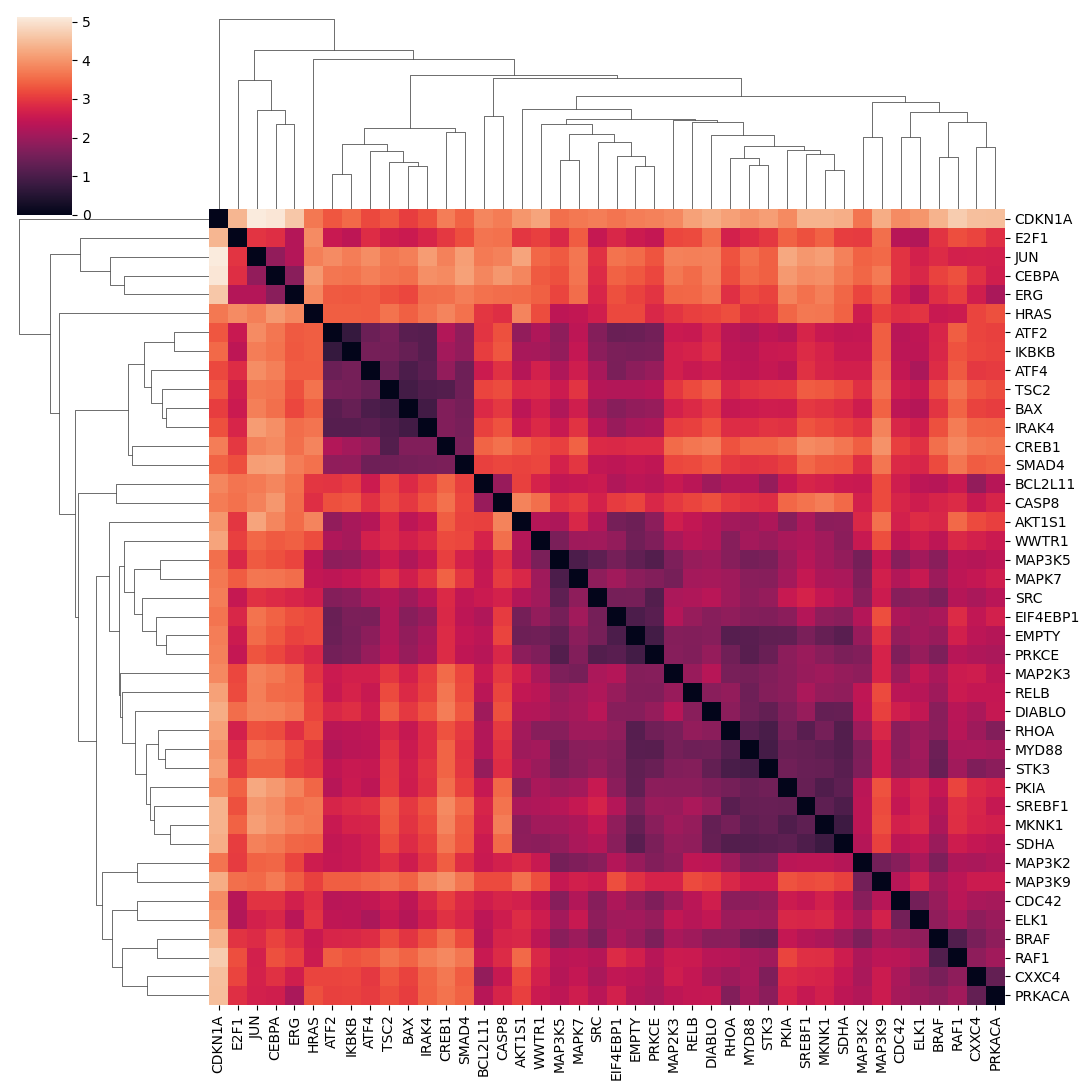

<IPython.core.display.Javascript object>

In [124]:
img_dist = pd.DataFrame(
    squareform(pdist(img_embs, metric="euclidean")),
    columns=list(img_embs.index),
    index=list(img_embs.index),
)
linkage = hc.linkage(sp.distance.squareform(img_dist), method="average")
ax = sns.clustermap(
    img_dist, row_linkage=linkage, col_linkage=linkage, figsize=[11, 11]
)

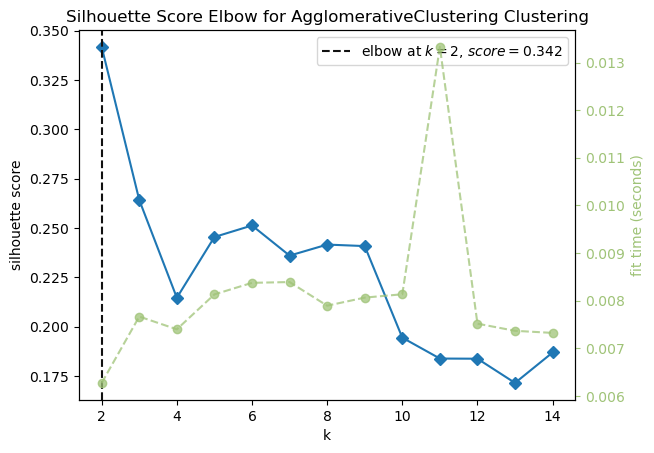

<IPython.core.display.Javascript object>

In [125]:
model = AgglomerativeClustering(linkage="average")
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="silhouette", timings=True, locate_elbow=True
)

visualizer.fit(img_embs)
ax = visualizer.show()

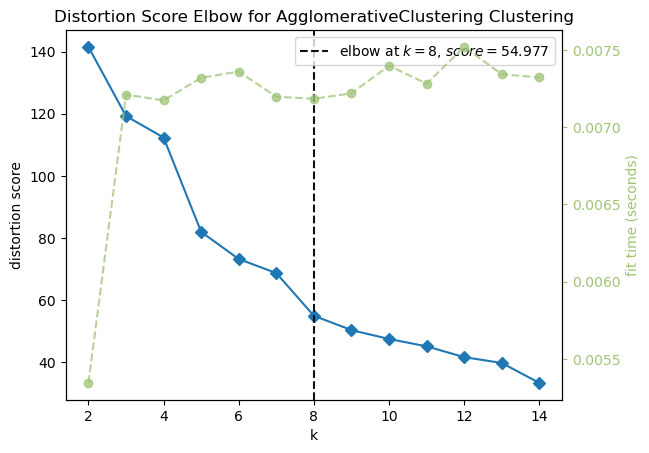

<IPython.core.display.Javascript object>

In [126]:
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="distortion", timings=True, locate_elbow=True
)

visualizer.fit(img_embs)
ax = visualizer.show()

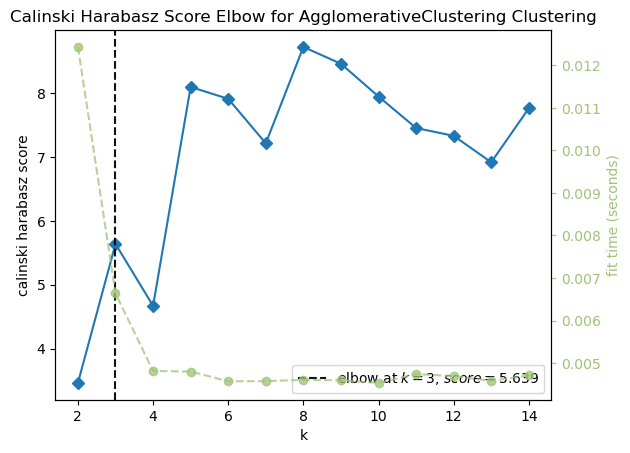

<IPython.core.display.Javascript object>

In [127]:
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="calinski_harabasz", timings=True, locate_elbow=True
)

visualizer.fit(img_embs)
ax = visualizer.show()

We see that depending on which score we look at the optimal number of clusters seem to be 2,3 or 9. We will choose 9 clusters although this is likely to overcluster the data.

In [129]:
model = AgglomerativeClustering(n_clusters=8, linkage="average")
cluster_labels = model.fit_predict(img_embs)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(img_embs.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, sorted(v)))
    print("")

Cluster 0: ['BRAF', 'CDC42', 'CXXC4', 'ELK1', 'MAP3K2', 'MAP3K9', 'PRKACA', 'RAF1']

Cluster 1: ['AKT1S1', 'DIABLO', 'EIF4EBP1', 'EMPTY', 'MAP2K3', 'MAP3K5', 'MAPK7', 'MKNK1', 'MYD88', 'PKIA', 'PRKCE', 'RELB', 'RHOA', 'SDHA', 'SRC', 'SREBF1', 'STK3', 'WWTR1']

Cluster 2: ['CEBPA', 'ERG', 'JUN']

Cluster 3: ['ATF2', 'ATF4', 'BAX', 'CREB1', 'IKBKB', 'IRAK4', 'SMAD4', 'TSC2']

Cluster 4: ['HRAS']

Cluster 5: ['BCL2L11', 'CASP8']

Cluster 6: ['E2F1']

Cluster 7: ['CDKN1A']



<IPython.core.display.Javascript object>

We see that the clustering includes a number of singeltons given by HRAS, CDKN1A, WWTR1, CASP8 and E2F1.
However, we also find 3 bigger clusters, which we analyze using a GO analysis to functionally annotate those. Similar to our approach in 3.3. we will report the top-3 terms of the GO analysis for those clusters that reach an FDR < 0.05.

0. MAPK signaling & stress response
    * positive regulation of MAPK cascade
    * positive regulation of protein serine/threonine kinase activity
    * Regulation of cellular response to stress

BCL2L11, BRAF, CDC42, CXXC4, ELK1, MAP2K3, MAP3K2, MAP3K5, MAP3K9, MAPK7, PRKACA, RAF1

1. Regulation of transcription (not significant)

AKT1S1, DIABLO, MKNK1, MYD88, PKIA, RELB, RHOA, SDHA, SREBF1, STK3

2. RNA polymerase (not significant)

CEBPA, ERG, JUN

3. Cellular component biogenesis
    * Cellular response to organic substance
    * Regulation of cellular component biogenesis
    * Response to oxygen levels

ATF2, ATF4, BAX, CREB1, EIF4EBP1, IKBKB, IRAK4, PRKCE, SMAD4, SRC, TSC2

---

### 4.3. Translation analysis

Next, we will assess the co-clustering of our inferred estimates of the structural and the regulatory space using a similar approach as described earlier to assess the structural similarity of the different network embeddings.

In [130]:
shared_nodes = set(img_embs.index).intersection(node_embs.index)

<IPython.core.display.Javascript object>

In [131]:
ami_img_node = compute_ami_matrix(
    img_embs.loc[shared_nodes], node_embs.loc[shared_nodes]
)

<IPython.core.display.Javascript object>

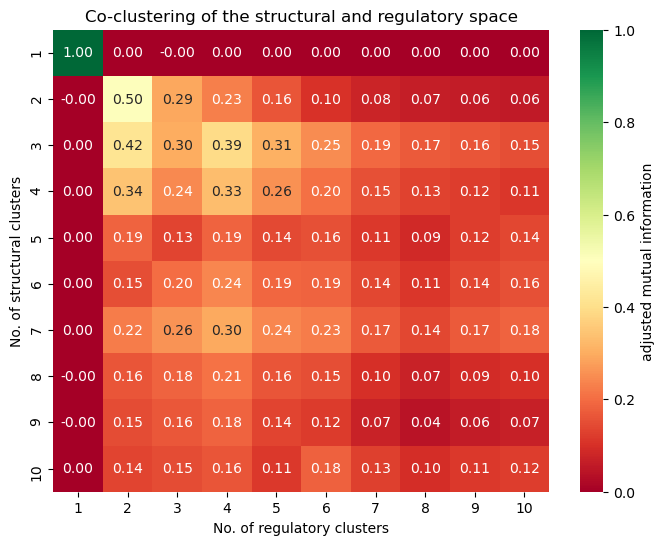

<IPython.core.display.Javascript object>

In [153]:
fig, ax = plt.subplots(figsize=[8, 6])
sns.heatmap(
    ami_img_node[:10, :10],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(10)])
ax.set_yticklabels([i + 1 for i in range(10)])
ax.set_xlabel("No. of regulatory clusters")
ax.set_ylabel("No. of structural clusters")
ax.set_title("Co-clustering of the structural and regulatory space")
plt.show()